/home/dbarker7752/perses/perses/foregrounds/HaslamGalaxy.py:83: HealpyDeprecationWarning: "verbose" was deprecated in version 1.15.0 and will be removed in a future version. 
  self._haslam_map_408 = hp.read_map(file_name, verbose=False)


Prepared Haslam map in 0.232 s.


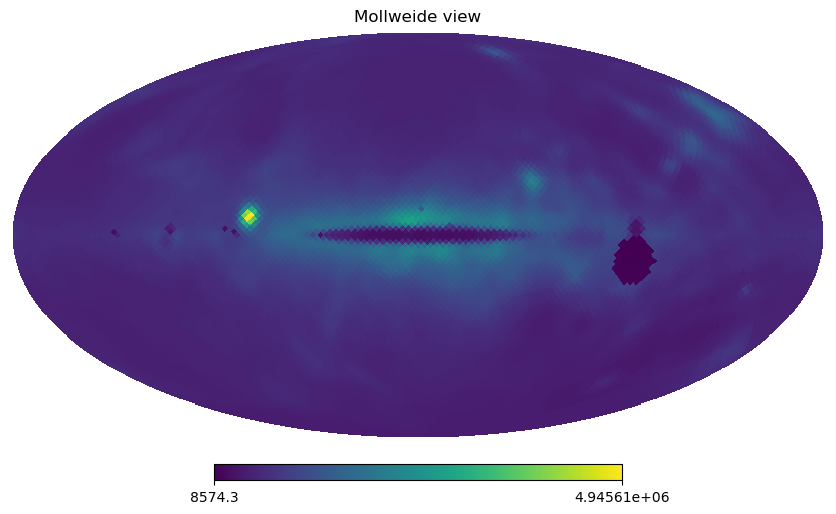

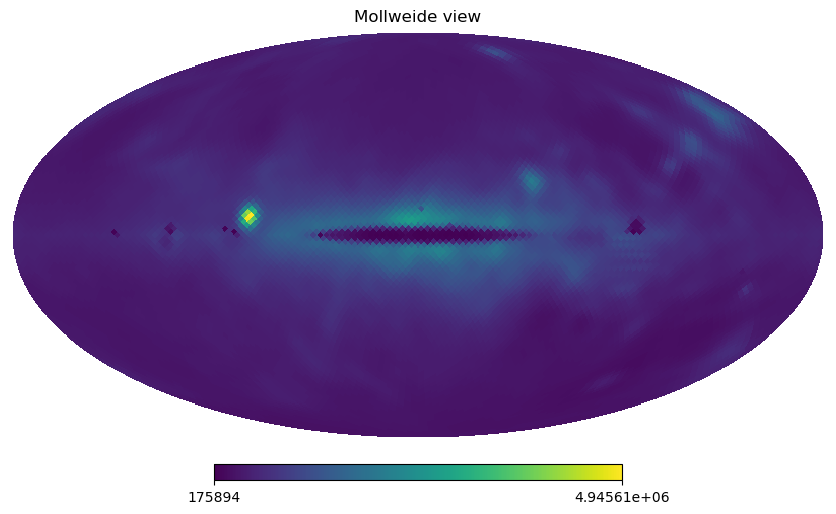

In [2]:
# boiler plate for most pylinex 21-cm stuff

import h5py
import numpy as np
import matplotlib.pyplot as plt
import scipy
from pylinex import Fitter, BasisSum, PolynomialBasis
import perses
from perses.models import PowerLawTimesPolynomialModel
from pylinex import Basis
import perses
import healpy as hp
from PIL import Image
import matplotlib.animation as animation
from astropy.io import fits
import os
import copy
from pylinex import Fitter, BasisSum, PolynomialBasis, MetaFitter, AttributeQuantity
from pylinex import Basis
from pylinex import TrainedBasis
import pylinex
import py21cmsig
import importlib
import corner
import lochness
from tqdm import tqdm
from matplotlib.animation import FuncAnimation
from importlib import reload
from pylinex import RepeatExpander, ShapedExpander, NullExpander,\
    PadExpander, CompiledQuantity, Extractor
import spiceypy as spice
from datetime import datetime
import enlighten

manager = enlighten.get_manager()
pbar = manager.counter(total=100, desc='Progress')

Prepared Haslam map in 0.189 s.


<module 'py21cmsig' from '/home/dbarker7752/21_cm_group/LuCEE-Night_Simulation/Beam_weighted_foreground/py21cmsig.py'>

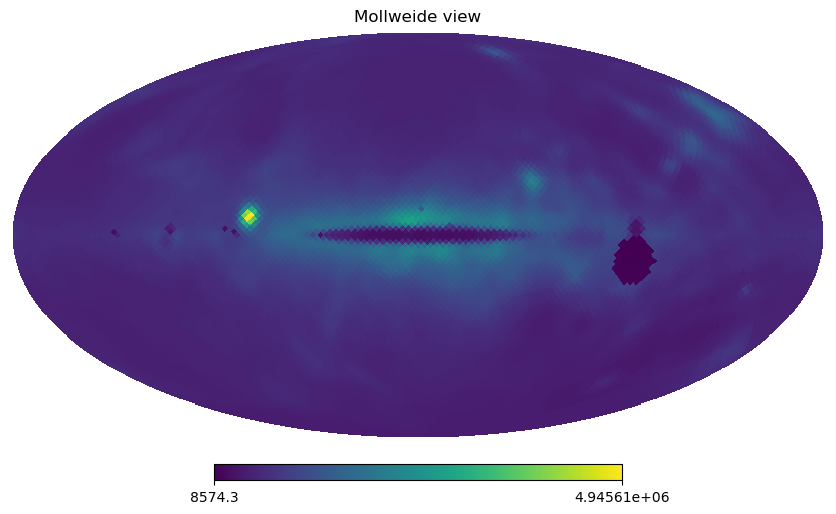

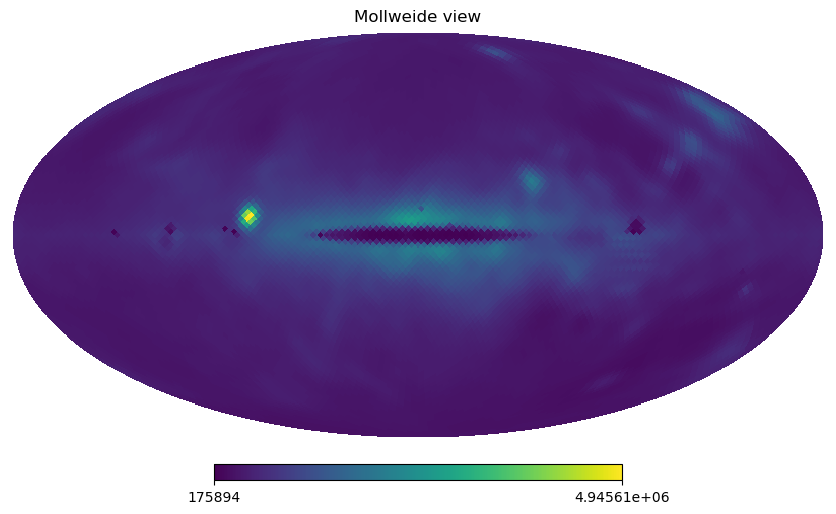

In [3]:
reload(py21cmsig)

Prepared Haslam map in 0.0887 s.


rms mean is 0.06351814531367783
rms std is 0.012067198629236471


100%|██████████| 1000/1000 [00:02<00:00, 340.20it/s]


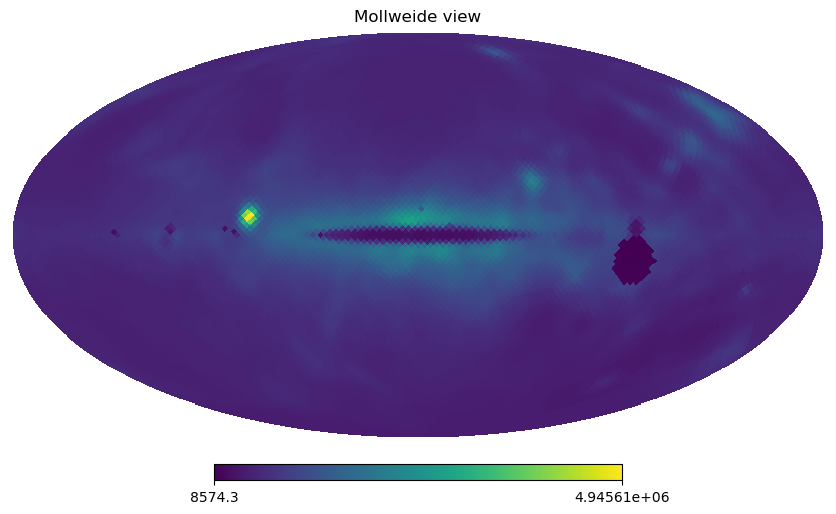

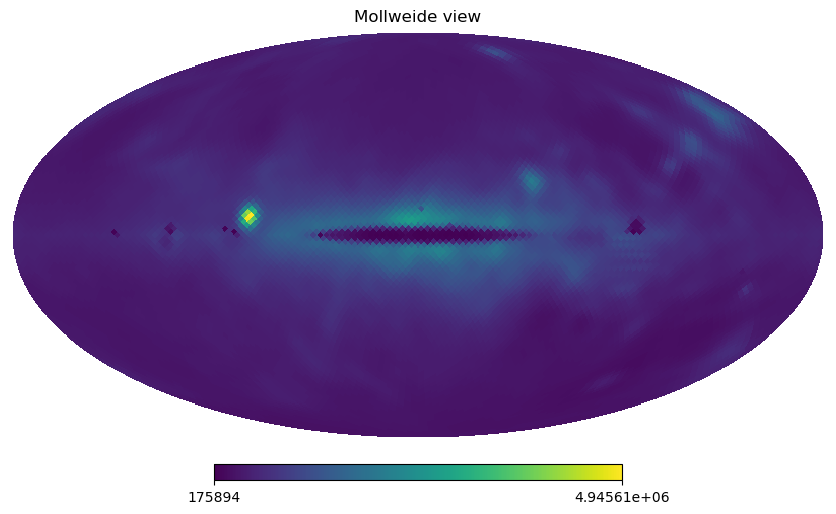

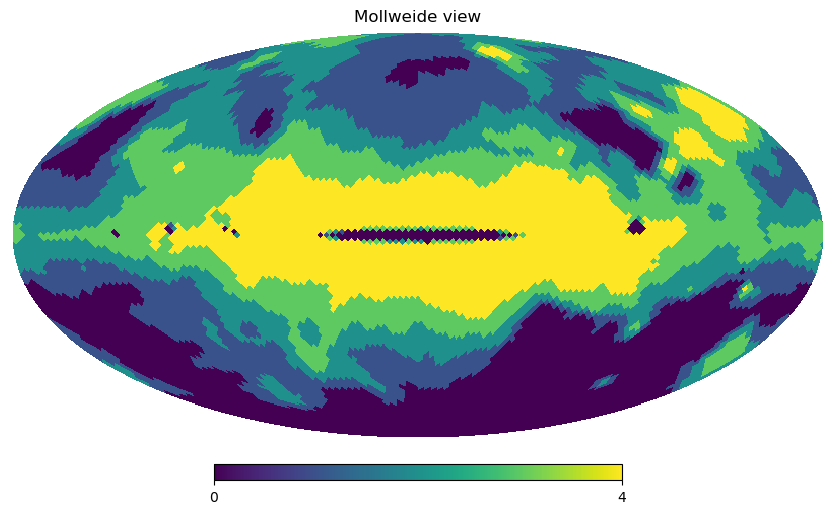

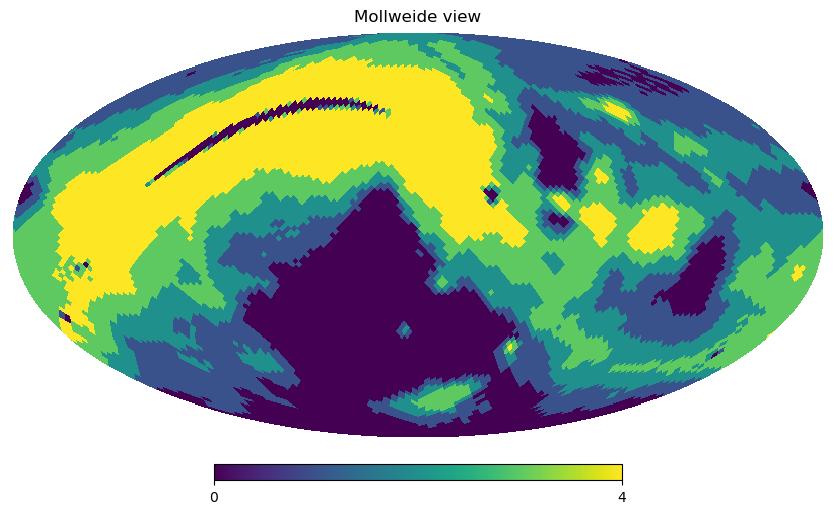

In [4]:
# Imporant constants
NSIDE = 32 # resolution of the map
NPIX = hp.nside2npix(NSIDE)
NPIX   # total number of pixels (size of the array being used)
location = (-23.815,182.25)  # The lat lon location of the moon landing site
spice_kernels = "/home/dbarker7752/lochness/input/spice_kernels/" #location of the spice kernels
frequencies = np.arange(6,50,0.1)

# Cosmological Parameters
H0 = 67.36     # Hubble constant 
h = H0/100     # H0
omM0 = 0.3152   # Omega matter today
omB0 = 0.0493   # Omega baryons today 
omK0 = 0        # Omega curvature today
omC0 = 0.2645   # Omega cold dark matter today 
#omR0 = 8.98e-5  # Omega radiation today
omR0=8.600000001024455e-05  # Omega radiation from 21cm FAST
omL0 = 0.6847   # Omega Dark Energy today

### Boilerplate arrays for healpy (changes with a change in resolution)
thetas = hp.pix2ang(NSIDE,np.arange(NPIX))[0]*(180/np.pi)
phis = hp.pix2ang(NSIDE,np.arange(NPIX))[1]*(180/np.pi)
coordinate_array = np.ones((NPIX,2))
for i in np.arange(NPIX):
    coordinate_array[i] = np.array([phis[i],thetas[i]])

# HASLAM map
gal = perses.foregrounds.HaslamGalaxy()
haslam_data=gal.get_map(39.93) # gets the actual array of the data for that haslam map

# ULSA map
ULSA_direction_raw = fits.open("/home/dbarker7752/21_cm_group/ULSA Maps/000.fits")
ULSA_frequency = fits.open("/home/dbarker7752/21_cm_group/ULSA Maps/210.fits")
ULSA_constant = fits.open("/home/dbarker7752/21_cm_group/ULSA Maps/220.fits")

# This cell fixes the hole in the ULSA data via an interpolation

# This identifies the pixels of the dead zone
vec = hp.ang2vec(np.pi/2*1.1, -np.pi/2*1.05)
indices=hp.query_disc(nside=NSIDE,vec=vec,radius=0.19)
hole_map = copy.deepcopy(ULSA_direction_raw[0].data[7])
hole_map[indices] = 10000000
hp.mollview(ULSA_direction_raw[0].data[7])
# These indices will be our region 10 which is the region we ignore
indices_deadzone = indices


x = np.arange(NPIX)
x = np.delete(x,indices_deadzone) # Gets rid of the dead zone
ULSA_min_deadzone = copy.deepcopy(ULSA_direction_raw[0].data)
for i,data in enumerate(ULSA_direction_raw[0].data):
    y = data
    y = np.delete(y,indices_deadzone)
    interpolator = scipy.interpolate.CubicSpline(x,y)
    for j in indices_deadzone:
        ULSA_min_deadzone[i][j] = interpolator(j)
hp.mollview(ULSA_min_deadzone[7])

ULSA_direction = ULSA_min_deadzone

# creates a list of all the beam file names.
path = "/home/dbarker7752/21_cm_group/Varied_Regolith/Beams"
files = []
for file in os.listdir(path):
    files.append(path+"/"+file)

# some other useful global variables
galaxy_map = ULSA_direction    # default galaxy map
test_times1 = [[2026,12,22,1,0,0]]   # list of times LOCHNESS will rotate the sky for 
frequency_array = np.array(range(1,51))   # list of frequencies we're evaluating at   

# modifies the galaxy map to not have the CMB (to make it consistent with the delta CMB convention of the signal)
galaxy_map_minCMB = copy.deepcopy(galaxy_map)
redshift_array = 1420.4/frequency_array-1
# This loop creates a CMB subtracted galaxy map to input into LOCHNESS
for i,j in enumerate(redshift_array):
    galaxy_map_minCMB[i] = galaxy_map[i] - py21cmsig.T_gamma(j)
galaxy_map_minCMB[np.where(galaxy_map_minCMB<0.0)] = 0   # Gets rid of the negatives that plague this ULSA map (not sure why they are they)
f = h5py.File("/home/dbarker7752/21_cm_group/foreground_array_minCMB","r")
foreground_array_minCMB = f["foreground_array"]


# radiometer noise
sigT = lambda T_b, dnu, dt: T_b/(np.sqrt(dnu*dt))
# Noise parameters
dnu = 1e6
dt = 5000*3600 # first number is the number of hours of integration time

# Synchrotron Equation
synch = lambda f,A,B,c : A*(f/408)**(B+c*np.log(f/408))  # taken from page 6 of Hibbard et al. 2023 Apj. Arbitrarily chose 25 as my v0

# This identifies the pixels of the absorption region
vec = hp.ang2vec(np.pi/2, 0)
indices=hp.query_disc(nside=NSIDE,vec=vec,radius=0.85)
absorp_map = copy.deepcopy(ULSA_direction[7])
# absorp_map[indices] = 10000000
absorp_indices = indices[np.where(absorp_map[indices] < 1450000)][750:906]
absorp_map[absorp_indices] = 10000000

manager = enlighten.get_manager()
pbar = manager.counter(total=100, desc='Progress')

n_regions = 5
reference_frequency = 25
sky_map = foreground_array_minCMB[0]

# frequencies = np.arange(6,50,0.1)
frequencies = np.arange(6,50,0.25)
## RMS ##
simulation_test = py21cmsig.simulation_run_raw(frequencies,files[0],foreground_array_minCMB,test_times1,dnu,dt,omR0,omM0,omK0,omL0,omB0) # needs to be run to get RMS, that's its only purpose

rms_array = np.array([])
frequency_bins = len(frequencies)
for n in range(10000):
    curve = np.ones(frequency_bins)
    for i in range(len(curve)):
        curve[i] = curve[i]*np.random.normal(scale=sigT(simulation_test[0][i],dnu,dt)) 
    rms = np.sqrt(np.mean(curve**2))
    rms_array = np.append(rms_array,rms)
rms_std = rms_array.std()
rms_mean = np.mean(rms_array)
print(f"rms mean is {rms_mean}")
print(f"rms std is {rms_std}")

# Shows the regions
best_foreground_model = py21cmsig.make_foreground_model(np.arange(5,51),5,ULSA_direction,7,rms_mean,rms_std,ev_num=10,scale=0.2, \
                                         show_region_map=True,absorption_region=False)
region_indices = best_foreground_model[10]

# Shows the rotated regions
best_foreground_model_rotated = py21cmsig.make_foreground_model(np.arange(5,51),5,foreground_array_minCMB[0],7,rms_mean,rms_std,ev_num=10,scale=0.2, \
                                         show_region_map=True,absorption_region=False)
region_indices_rotated = best_foreground_model_rotated[10]

# creates the fiducial Lambda CDM signal
# parameter_array = np.array([[omR0,0],[omM0,0.013],[omK0,0],[omL0,0.0062],[omB0,0.00014/h**2]])
parameter_array = np.array([[omR0,0],[omM0,0],[omK0,0],[omL0,0],[omB0,0/h**2]])
fiducial_signal = py21cmsig.lambdaCDM_training_set(frequencies,parameter_array,1)[0][0]

# This loads in your raw training set
f = h5py.File("/home/dbarker7752/21_cm_group/Varied_Regolith/Training_Set","r")
varied_regolith_training_set_raw= f["Foreground_Training_Set"]
varied_regolith_training_set_raw_params = f["Parameters_of_Beams"]

# Loads up the raw sky maps
hdf5 = h5py.File("/home/dbarker7752/21_cm_group/Varied_Regolith/varied_beams_ULSA_sky_maps","r")
raw_sky_maps = hdf5["sky_maps"]
raw_sky_maps.shape

# This creates the sky maps that are properly rotated and normalized
beams = np.zeros((len(files),50,NPIX))
beam_euler_angle = [0,90,90]
derp = h5py.File("/home/dbarker7752/21_cm_group/Varied_Regolith/Raw_Beam_Maps","r")
beam_maps= derp["raw_beam_maps"]

# for n in tqdm(range(len(files))):
#     for nu in range(50):
#         f=beam_maps[n][nu]
#         rotated_beam = hp.Rotator(rot=beam_euler_angle).rotate_map_pixel(f)
#         rotated_beam[np.where(rotated_beam<0.0)] = 0
#         normalized_beam = rotated_beam/np.sum(rotated_beam)
#         beams[n][nu] = normalized_beam

f = h5py.File("/home/dbarker7752/21_cm_group/normalized_beams","r")
beams = f["normalized_beams"]

beam_sky_training_set = beams[:,5:,:]
beam_sky_training_set_params = varied_regolith_training_set_raw_params
raw_beam_weighted_sky_maps = raw_sky_maps

B_value_functions = py21cmsig.B_value_interp(beam_sky_training_set,beam_sky_training_set_params,\
                         frequencies,sky_map,reference_frequency,n_regions)

# create signal training set for fiducial model
N=1000
parameter_array = np.array([[omR0,0],[omM0,0.013],[omK0,0],[omL0,0.0062],[omB0,0.00014/h**2]])
signal_training_set_lambdaCDM=py21cmsig.lambdaCDM_training_set(frequencies,parameter_array,N)

In [8]:

## Loaded in signal training sets

#lambda CDM
f = h5py.File("/home/dbarker7752/21_cm_group/signal_training_sets/lambdaCDM","r")
labmdaCDM_training_set = f["signal_training_set"]
labmdaCDM_training_set_params = f["signal_training_set_parameters"]

# Self-Annihilating Dark Matter
f = h5py.File("/home/dbarker7752/21_cm_group/signal_training_sets/DMAN","r")
DMAN_training_set = f["signal_training_set"]
DMAN_training_set_params = f["signal_training_set_parameters"]

# Decaying Dark Matter
f = h5py.File("/home/dbarker7752/21_cm_group/signal_training_sets/DMD","r")
DMD_training_set = f["signal_training_set"]
DMD_training_set_params = f["signal_training_set_parameters"]

# Early Dark Energy
f = h5py.File("/home/dbarker7752/21_cm_group/signal_training_sets/EDE","r")
EDE_training_set = f["signal_training_set"]
EDE_training_set_params = f["signal_training_set_parameters"]

# Extra Radio Background
f = h5py.File("/home/dbarker7752/21_cm_group/signal_training_sets/ERB","r")
ERB_training_set = f["signal_training_set"]
ERB_training_set_params = f["signal_training_set_parameters"]

# Baryon-Dark Matter Interaction (MCDM)
f = h5py.File("/home/dbarker7752/21_cm_group/signal_training_sets/MCDM","r")
MCDM_training_set = f["signal_training_set"]
MCDM_training_set_params = f["signal_training_set_parameters"]

# Let's make some different LSTs
LST = h5py.File("/home/dbarker7752/21_cm_group/Varied_Regolith/LST_10_Base_Foregrounds","r")
foreground_array_minCMB_2 = LST["LST_2"]
foreground_array_minCMB_3 = LST["LST_3"]
foreground_array_minCMB_4 = LST["LST_4"]
foreground_array_minCMB_5 = LST["LST_5"]
foreground_array_minCMB_6 = LST["LST_6"]
foreground_array_minCMB_7 = LST["LST_7"]
foreground_array_minCMB_8 = LST["LST_8"]
foreground_array_minCMB_9 = LST["LST_9"]
foreground_array_minCMB_10 = LST["LST_10"]

f = h5py.File("/home/dbarker7752/21_cm_group/Varied_Regolith/Training_Set_2","r")
varied_regolith_training_set_raw_2 = f["Foreground_Training_Set"]
varied_regolith_training_set_raw_parameters_2 = f["Parameters_of_Beams"]

f = h5py.File("/home/dbarker7752/21_cm_group/Varied_Regolith/Training_Set_3","r")
varied_regolith_training_set_raw_3 = f["Foreground_Training_Set"]
varied_regolith_training_set_raw_parameters_3 = f["Parameters_of_Beams"]

f = h5py.File("/home/dbarker7752/21_cm_group/Varied_Regolith/Training_Set_4","r")
varied_regolith_training_set_raw_4 = f["Foreground_Training_Set"]
varied_regolith_training_set_raw_parameters_4 = f["Parameters_of_Beams"]

f = h5py.File("/home/dbarker7752/21_cm_group/Varied_Regolith/Training_Set_5","r")
varied_regolith_training_set_raw_5 = f["Foreground_Training_Set"]
varied_regolith_training_set_raw_parameters_5 = f["Parameters_of_Beams"]

f = h5py.File("/home/dbarker7752/21_cm_group/Varied_Regolith/Training_Set_6","r")
varied_regolith_training_set_raw_6 = f["Foreground_Training_Set"]
varied_regolith_training_set_raw_parameters_6 = f["Parameters_of_Beams"]

f = h5py.File("/home/dbarker7752/21_cm_group/Varied_Regolith/Training_Set_7","r")
varied_regolith_training_set_raw_7 = f["Foreground_Training_Set"]
varied_regolith_training_set_raw_parameters_7 = f["Parameters_of_Beams"]

f = h5py.File("/home/dbarker7752/21_cm_group/Varied_Regolith/Training_Set_8","r")
varied_regolith_training_set_raw_8 = f["Foreground_Training_Set"]
varied_regolith_training_set_raw_parameters_8 = f["Parameters_of_Beams"]

f = h5py.File("/home/dbarker7752/21_cm_group/Varied_Regolith/Training_Set_9","r")
varied_regolith_training_set_raw_9 = f["Foreground_Training_Set"]
varied_regolith_training_set_raw_parameters_9 = f["Parameters_of_Beams"]

In [6]:
### uncomment to create the exotic training sets ###
N=10000
# parameter_array = np.array([[omR0,0],[omM0,0.013],[omK0,0],[omL0,0.0062],[omB0,0.00014/h**2]])
# signal_training_set_lambdaCDM=py21cmsig.lambdaCDM_training_set(frequencies,parameter_array,N)
# f = h5py.File("/home/dbarker7752/21_cm_group/signal_training_sets/lambdaCDM","w")
# dset01 = f.create_dataset("signal_training_set",data=signal_training_set_lambdaCDM[0])
# dset02 = f.create_dataset("signal_training_set_parameters",data=signal_training_set_lambdaCDM[1])
# f.close()

parameters_DMAN = [[2*10e-22,1*10e-22,5*10e-23,2*10e-23,5*10e-24,2*10e-24]]
DMAN_training_set=py21cmsig.DMAN_training_set(frequencies,parameters_DMAN,N)
f = h5py.File("/home/dbarker7752/21_cm_group/signal_training_sets/DMAN","w")
dset01 = f.create_dataset("signal_training_set",data=DMAN_training_set[0])
dset02 = f.create_dataset("signal_training_set_parameters",data=DMAN_training_set[1])
f.close()

parameters_DMD = [[0.5*10e26, 1*10e26, 3*10e26, 10*10e26, 30*10e26, 100*10e26, 500*10e26]]
DMD_training_set=py21cmsig.DMD_training_set(frequencies,parameters_DMD,N)
f = h5py.File("/home/dbarker7752/21_cm_group/signal_training_sets/DMD","w")
dset01 = f.create_dataset("signal_training_set",data=DMD_training_set[0])
dset02 = f.create_dataset("signal_training_set_parameters",data=DMD_training_set[1])
f.close()

parameters_MCDM = [[0.1,0.5,2,5,10]]
MCDM_training_set = py21cmsig.MCDM_training_set(frequencies,parameters_MCDM,N)
f = h5py.File("/home/dbarker7752/21_cm_group/signal_training_sets/MCDM","w")
dset01 = f.create_dataset("signal_training_set",data=MCDM_training_set[0])
dset02 = f.create_dataset("signal_training_set_parameters",data=MCDM_training_set[1])
f.close()

parameters_EDE = np.array([[2e-5,4e-5],[50,100]])
EDE_training_set = py21cmsig.EDE_training_set(frequencies,parameters_EDE,N)
f = h5py.File("/home/dbarker7752/21_cm_group/signal_training_sets/EDE","w")
dset01 = f.create_dataset("signal_training_set",data=EDE_training_set[0])
dset02 = f.create_dataset("signal_training_set_parameters",data=EDE_training_set[1])
f.close()

parameters_ERB = np.array([[0.1,10,375],[25,100,200]])
ERB_training_set = py21cmsig.ERB_training_set(frequencies,parameters_ERB,N)
f = h5py.File("/home/dbarker7752/21_cm_group/signal_training_sets/ERB","w")
dset01 = f.create_dataset("signal_training_set",data=ERB_training_set[0])
dset02 = f.create_dataset("signal_training_set_parameters",data=ERB_training_set[1])
f.close()

100%|██████████| 10000/10000 [07:18<00:00, 22.80it/s]


In [17]:
## Creates a foreground for the simulation:
sky_map = foreground_array_minCMB[0]
# custom_parameter_range = np.array([[0.5,3],[3.2,4.2],[3.8,4.8]])  # For making a random foreground
# parameter_variation = [0.05,0.025,0.05]                           # For making a random foreground
custom_parameter_range = np.array([[1,1],[3.4,3.4],[4.6,4.6]])
parameter_variation = [0,0,0]

signal_model = DMAN_training_set[0][0]

## Interpolate the varied beams to match the rest of the data
varied_regolith_training_set = np.zeros((len(varied_regolith_training_set_raw),len(frequencies)))
for n in range(len(varied_regolith_training_set_raw)):
    beam_regolith_interp = scipy.interpolate.CubicSpline(range(1,51),varied_regolith_training_set_raw[n,0,:])
    varied_regolith_training_set[n] = beam_regolith_interp(frequencies)
Nb = 2 # number of beams in the beam training set
exp_test=py21cmsig.expanded_training_set_no_t(varied_regolith_training_set,varied_regolith_training_set_raw_params,Nb,\
                               custom_parameter_range,show_parameter_ranges=False)

BTS_curves = exp_test[0]
BTS_params = exp_test[1]
beam_sky_training_set = beams[:,5:,:]
beam_sky_training_set_params = varied_regolith_training_set_raw_params
raw_beam_weighted_sky_maps = raw_sky_maps
N = 1
# parameter_variation = [0.05,0.025,0.05]
determine_parameter_range = True
new_FG_parameter_mean = None
foreground_run = py21cmsig.synchrotron_foreground_forsigex(n_regions,frequencies,reference_frequency,sky_map,BTS_curves,BTS_params,\
                                    beam_sky_training_set,beam_sky_training_set_params,N,parameter_variation,B_value_functions, \
                                        define_parameter_mean=False,parameter_mean=new_FG_parameter_mean)
foreground_for_sim = foreground_run[3][0]
parameters_for_sim = foreground_run[4][0]

# Our simulation function
simulation_test_beam_1 = py21cmsig.simulation_run(foreground_for_sim,signal_model,dnu,dt)

print(f"The parameters for this simulation are {parameters_for_sim}")

# Determine RMS
rms_array = np.array([])
frequency_bins = len(frequencies)
for n in range(10000):
    curve = np.ones(frequency_bins)
    for i in range(len(curve)):
        curve[i] = curve[i]*np.random.normal(scale=sigT(simulation_test_beam_1[0][i],dnu,dt)) 
    rms = np.sqrt(np.mean(curve**2))
    rms_array = np.append(rms_array,rms)
rms_std = rms_array.std()
rms_mean = np.mean(rms_array)
print(f"rms mean is {rms_mean}")
print(f"rms std is {rms_std}")

## Creates a foreground for the simulation:
sky_map = foreground_array_minCMB_2[0]


## Interpolate the varied beams to match the rest of the data
varied_regolith_training_set = np.zeros((len(varied_regolith_training_set_raw_2),len(frequencies)))
for n in range(len(varied_regolith_training_set_raw_2)):
    beam_regolith_interp = scipy.interpolate.CubicSpline(range(1,51),varied_regolith_training_set_raw_2[n,0,:])
    varied_regolith_training_set[n] = beam_regolith_interp(frequencies)
Nb = 2 # number of beams in the beam training set
exp_test=py21cmsig.expanded_training_set_no_t(varied_regolith_training_set,varied_regolith_training_set_raw_params,Nb,\
                               custom_parameter_range,show_parameter_ranges=False)

BTS_curves = exp_test[0]
BTS_params = exp_test[1]
beam_sky_training_set = beams[:,5:,:]
beam_sky_training_set_params = varied_regolith_training_set_raw_params
raw_beam_weighted_sky_maps = raw_sky_maps
N = 1
# parameter_variation = [0.05,0.025,0.05]
determine_parameter_range = True
new_FG_parameter_mean = None
foreground_run = py21cmsig.synchrotron_foreground_forsigex(n_regions,frequencies,reference_frequency,sky_map,BTS_curves,BTS_params,\
                                    beam_sky_training_set,beam_sky_training_set_params,N,parameter_variation,B_value_functions, \
                                        define_parameter_mean=False,parameter_mean=new_FG_parameter_mean)
foreground_for_sim = foreground_run[3][0]
parameters_for_sim = foreground_run[4][0]

# Our simulation function
simulation_test_beam_2 = py21cmsig.simulation_run(foreground_for_sim,signal_model,dnu,dt)

print(f"The parameters for this simulation are {parameters_for_sim}")

# Determine RMS
rms_array = np.array([])
frequency_bins = len(frequencies)
for n in range(10000):
    curve = np.ones(frequency_bins)
    for i in range(len(curve)):
        curve[i] = curve[i]*np.random.normal(scale=sigT(simulation_test_beam_2[0][i],dnu,dt)) 
    rms = np.sqrt(np.mean(curve**2))
    rms_array = np.append(rms_array,rms)
rms_std = rms_array.std()
rms_mean = np.mean(rms_array)
print(f"rms mean is {rms_mean}")
print(f"rms std is {rms_std}")

## Creates a foreground for the simulation:
sky_map = foreground_array_minCMB_3[0]


## Interpolate the varied beams to match the rest of the data
varied_regolith_training_set = np.zeros((len(varied_regolith_training_set_raw_3),len(frequencies)))
for n in range(len(varied_regolith_training_set_raw_3)):
    beam_regolith_interp = scipy.interpolate.CubicSpline(range(1,51),varied_regolith_training_set_raw_3[n,0,:])
    varied_regolith_training_set[n] = beam_regolith_interp(frequencies)
Nb = 2 # number of beams in the beam training set
exp_test=py21cmsig.expanded_training_set_no_t(varied_regolith_training_set,varied_regolith_training_set_raw_params,Nb,\
                               custom_parameter_range,show_parameter_ranges=False)

BTS_curves = exp_test[0]
BTS_params = exp_test[1]
beam_sky_training_set = beams[:,5:,:]
beam_sky_training_set_params = varied_regolith_training_set_raw_params
raw_beam_weighted_sky_maps = raw_sky_maps
N = 1
# parameter_variation = [0.05,0.025,0.05]
determine_parameter_range = True
new_FG_parameter_mean = None
foreground_run = py21cmsig.synchrotron_foreground_forsigex(n_regions,frequencies,reference_frequency,sky_map,BTS_curves,BTS_params,\
                                    beam_sky_training_set,beam_sky_training_set_params,N,parameter_variation,B_value_functions, \
                                        define_parameter_mean=False,parameter_mean=new_FG_parameter_mean)
foreground_for_sim = foreground_run[3][0]
parameters_for_sim = foreground_run[4][0]

# Our simulation function
simulation_test_beam_3 = py21cmsig.simulation_run(foreground_for_sim,signal_model,dnu,dt)

print(f"The parameters for this simulation are {parameters_for_sim}")

# Determine RMS
rms_array = np.array([])
frequency_bins = len(frequencies)
for n in range(10000):
    curve = np.ones(frequency_bins)
    for i in range(len(curve)):
        curve[i] = curve[i]*np.random.normal(scale=sigT(simulation_test_beam_3[0][i],dnu,dt)) 
    rms = np.sqrt(np.mean(curve**2))
    rms_array = np.append(rms_array,rms)
rms_std = rms_array.std()
rms_mean = np.mean(rms_array)
print(f"rms mean is {rms_mean}")
print(f"rms std is {rms_std}")

## Creates a foreground for the simulation:
sky_map = foreground_array_minCMB_4[0]




## Interpolate the varied beams to match the rest of the data
varied_regolith_training_set = np.zeros((len(varied_regolith_training_set_raw_4),len(frequencies)))
for n in range(len(varied_regolith_training_set_raw_4)):
    beam_regolith_interp = scipy.interpolate.CubicSpline(range(1,51),varied_regolith_training_set_raw_4[n,0,:])
    varied_regolith_training_set[n] = beam_regolith_interp(frequencies)
Nb = 2 # number of beams in the beam training set
exp_test=py21cmsig.expanded_training_set_no_t(varied_regolith_training_set,varied_regolith_training_set_raw_params,Nb,\
                               custom_parameter_range,show_parameter_ranges=False)

BTS_curves = exp_test[0]
BTS_params = exp_test[1]
beam_sky_training_set = beams[:,5:,:]
beam_sky_training_set_params = varied_regolith_training_set_raw_params
raw_beam_weighted_sky_maps = raw_sky_maps
N = 1
# parameter_variation = [0.05,0.025,0.05]
determine_parameter_range = True
new_FG_parameter_mean = None
foreground_run = py21cmsig.synchrotron_foreground_forsigex(n_regions,frequencies,reference_frequency,sky_map,BTS_curves,BTS_params,\
                                    beam_sky_training_set,beam_sky_training_set_params,N,parameter_variation,B_value_functions, \
                                        define_parameter_mean=False,parameter_mean=new_FG_parameter_mean)
foreground_for_sim = foreground_run[3][0]
parameters_for_sim = foreground_run[4][0]

# Our simulation function
simulation_test_beam_4 = py21cmsig.simulation_run(foreground_for_sim,signal_model,dnu,dt)

print(f"The parameters for this simulation are {parameters_for_sim}")

# Determine RMS
rms_array = np.array([])
frequency_bins = len(frequencies)
for n in range(10000):
    curve = np.ones(frequency_bins)
    for i in range(len(curve)):
        curve[i] = curve[i]*np.random.normal(scale=sigT(simulation_test_beam_4[0][i],dnu,dt)) 
    rms = np.sqrt(np.mean(curve**2))
    rms_array = np.append(rms_array,rms)
rms_std = rms_array.std()
rms_mean = np.mean(rms_array)
print(f"rms mean is {rms_mean}")
print(f"rms std is {rms_std}")

## Creates a foreground for the simulation:
sky_map = foreground_array_minCMB_5[0]
# custom_parameter_range = np.array([[0.5,3],[3.2,4.2],[3.8,4.8]])  # For making a random foreground
# parameter_variation = [0.05,0.025,0.05]                           # For making a random foreground


## Interpolate the varied beams to match the rest of the data
varied_regolith_training_set = np.zeros((len(varied_regolith_training_set_raw_5),len(frequencies)))
for n in range(len(varied_regolith_training_set_raw_5)):
    beam_regolith_interp = scipy.interpolate.CubicSpline(range(1,51),varied_regolith_training_set_raw_5[n,0,:])
    varied_regolith_training_set[n] = beam_regolith_interp(frequencies)
Nb = 2 # number of beams in the beam training set
exp_test=py21cmsig.expanded_training_set_no_t(varied_regolith_training_set,varied_regolith_training_set_raw_params,Nb,\
                               custom_parameter_range,show_parameter_ranges=False)

BTS_curves = exp_test[0]
BTS_params = exp_test[1]
beam_sky_training_set = beams[:,5:,:]
beam_sky_training_set_params = varied_regolith_training_set_raw_params
raw_beam_weighted_sky_maps = raw_sky_maps
N = 1
# parameter_variation = [0.05,0.025,0.05]
determine_parameter_range = True
new_FG_parameter_mean = None
foreground_run = py21cmsig.synchrotron_foreground_forsigex(n_regions,frequencies,reference_frequency,sky_map,BTS_curves,BTS_params,\
                                    beam_sky_training_set,beam_sky_training_set_params,N,parameter_variation,B_value_functions, \
                                        define_parameter_mean=False,parameter_mean=new_FG_parameter_mean)
foreground_for_sim = foreground_run[3][0]
parameters_for_sim = foreground_run[4][0]

# Our simulation function
simulation_test_beam_5 = py21cmsig.simulation_run(foreground_for_sim,signal_model,dnu,dt)

print(f"The parameters for this simulation are {parameters_for_sim}")

# Determine RMS
rms_array = np.array([])
frequency_bins = len(frequencies)
for n in range(10000):
    curve = np.ones(frequency_bins)
    for i in range(len(curve)):
        curve[i] = curve[i]*np.random.normal(scale=sigT(simulation_test_beam_5[0][i],dnu,dt)) 
    rms = np.sqrt(np.mean(curve**2))
    rms_array = np.append(rms_array,rms)
rms_std = rms_array.std()
rms_mean = np.mean(rms_array)
print(f"rms mean is {rms_mean}")
print(f"rms std is {rms_std}")

## Creates a foreground for the simulation:
sky_map = foreground_array_minCMB_6[0]


## Interpolate the varied beams to match the rest of the data
varied_regolith_training_set = np.zeros((len(varied_regolith_training_set_raw_6),len(frequencies)))
for n in range(len(varied_regolith_training_set_raw_6)):
    beam_regolith_interp = scipy.interpolate.CubicSpline(range(1,51),varied_regolith_training_set_raw_6[n,0,:])
    varied_regolith_training_set[n] = beam_regolith_interp(frequencies)
Nb = 2 # number of beams in the beam training set
exp_test=py21cmsig.expanded_training_set_no_t(varied_regolith_training_set,varied_regolith_training_set_raw_params,Nb,\
                               custom_parameter_range,show_parameter_ranges=False)

BTS_curves = exp_test[0]
BTS_params = exp_test[1]
beam_sky_training_set = beams[:,5:,:]
beam_sky_training_set_params = varied_regolith_training_set_raw_params
raw_beam_weighted_sky_maps = raw_sky_maps
N = 1
# parameter_variation = [0.05,0.025,0.05]
determine_parameter_range = True
new_FG_parameter_mean = None
foreground_run = py21cmsig.synchrotron_foreground_forsigex(n_regions,frequencies,reference_frequency,sky_map,BTS_curves,BTS_params,\
                                    beam_sky_training_set,beam_sky_training_set_params,N,parameter_variation,B_value_functions, \
                                        define_parameter_mean=False,parameter_mean=new_FG_parameter_mean)
foreground_for_sim = foreground_run[3][0]
parameters_for_sim = foreground_run[4][0]

# Our simulation function
simulation_test_beam_6 = py21cmsig.simulation_run(foreground_for_sim,signal_model,dnu,dt)

print(f"The parameters for this simulation are {parameters_for_sim}")

# Determine RMS
rms_array = np.array([])
frequency_bins = len(frequencies)
for n in range(10000):
    curve = np.ones(frequency_bins)
    for i in range(len(curve)):
        curve[i] = curve[i]*np.random.normal(scale=sigT(simulation_test_beam_1[0][i],dnu,dt)) 
    rms = np.sqrt(np.mean(curve**2))
    rms_array = np.append(rms_array,rms)
rms_std = rms_array.std()
rms_mean = np.mean(rms_array)
print(f"rms mean is {rms_mean}")
print(f"rms std is {rms_std}")

## Creates a foreground for the simulation:
sky_map = foreground_array_minCMB_7[0]


## Interpolate the varied beams to match the rest of the data
varied_regolith_training_set = np.zeros((len(varied_regolith_training_set_raw_7),len(frequencies)))
for n in range(len(varied_regolith_training_set_raw_7)):
    beam_regolith_interp = scipy.interpolate.CubicSpline(range(1,51),varied_regolith_training_set_raw_7[n,0,:])
    varied_regolith_training_set[n] = beam_regolith_interp(frequencies)
Nb = 2 # number of beams in the beam training set
exp_test=py21cmsig.expanded_training_set_no_t(varied_regolith_training_set,varied_regolith_training_set_raw_params,Nb,\
                               custom_parameter_range,show_parameter_ranges=False)

BTS_curves = exp_test[0]
BTS_params = exp_test[1]
beam_sky_training_set = beams[:,5:,:]
beam_sky_training_set_params = varied_regolith_training_set_raw_params
raw_beam_weighted_sky_maps = raw_sky_maps
N = 1
# parameter_variation = [0.05,0.025,0.05]
determine_parameter_range = True
new_FG_parameter_mean = None
foreground_run = py21cmsig.synchrotron_foreground_forsigex(n_regions,frequencies,reference_frequency,sky_map,BTS_curves,BTS_params,\
                                    beam_sky_training_set,beam_sky_training_set_params,N,parameter_variation, B_value_functions,\
                                        define_parameter_mean=False,parameter_mean=new_FG_parameter_mean)
foreground_for_sim = foreground_run[3][0]
parameters_for_sim = foreground_run[4][0]

# Our simulation function
simulation_test_beam_7 = py21cmsig.simulation_run(foreground_for_sim,signal_model,dnu,dt)

print(f"The parameters for this simulation are {parameters_for_sim}")

# Determine RMS
rms_array = np.array([])
frequency_bins = len(frequencies)
for n in range(10000):
    curve = np.ones(frequency_bins)
    for i in range(len(curve)):
        curve[i] = curve[i]*np.random.normal(scale=sigT(simulation_test_beam_1[0][i],dnu,dt)) 
    rms = np.sqrt(np.mean(curve**2))
    rms_array = np.append(rms_array,rms)
rms_std = rms_array.std()
rms_mean = np.mean(rms_array)
print(f"rms mean is {rms_mean}")
print(f"rms std is {rms_std}")

## Creates a foreground for the simulation:
sky_map = foreground_array_minCMB_8[0]


## Interpolate the varied beams to match the rest of the data
varied_regolith_training_set = np.zeros((len(varied_regolith_training_set_raw_8),len(frequencies)))
for n in range(len(varied_regolith_training_set_raw_8)):
    beam_regolith_interp = scipy.interpolate.CubicSpline(range(1,51),varied_regolith_training_set_raw_8[n,0,:])
    varied_regolith_training_set[n] = beam_regolith_interp(frequencies)
Nb = 2 # number of beams in the beam training set
exp_test=py21cmsig.expanded_training_set_no_t(varied_regolith_training_set,varied_regolith_training_set_raw_params,Nb,\
                               custom_parameter_range,show_parameter_ranges=False)

BTS_curves = exp_test[0]
BTS_params = exp_test[1]
beam_sky_training_set = beams[:,5:,:]
beam_sky_training_set_params = varied_regolith_training_set_raw_params
raw_beam_weighted_sky_maps = raw_sky_maps
N = 1
# parameter_variation = [0.05,0.025,0.05]
determine_parameter_range = True
new_FG_parameter_mean = None
foreground_run = py21cmsig.synchrotron_foreground_forsigex(n_regions,frequencies,reference_frequency,sky_map,BTS_curves,BTS_params,\
                                    beam_sky_training_set,beam_sky_training_set_params,N,parameter_variation,B_value_functions, \
                                        define_parameter_mean=False,parameter_mean=new_FG_parameter_mean)
foreground_for_sim = foreground_run[3][0]
parameters_for_sim = foreground_run[4][0]

# Our simulation function
simulation_test_beam_8 = py21cmsig.simulation_run(foreground_for_sim,signal_model,dnu,dt)

print(f"The parameters for this simulation are {parameters_for_sim}")

# Determine RMS
rms_array = np.array([])
frequency_bins = len(frequencies)
for n in range(10000):
    curve = np.ones(frequency_bins)
    for i in range(len(curve)):
        curve[i] = curve[i]*np.random.normal(scale=sigT(simulation_test_beam_1[0][i],dnu,dt)) 
    rms = np.sqrt(np.mean(curve**2))
    rms_array = np.append(rms_array,rms)
rms_std = rms_array.std()
rms_mean = np.mean(rms_array)
print(f"rms mean is {rms_mean}")
print(f"rms std is {rms_std}")

## Creates a foreground for the simulation:
sky_map = foreground_array_minCMB_9[0]


## Interpolate the varied beams to match the rest of the data
varied_regolith_training_set = np.zeros((len(varied_regolith_training_set_raw_9),len(frequencies)))
for n in range(len(varied_regolith_training_set_raw_9)):
    beam_regolith_interp = scipy.interpolate.CubicSpline(range(1,51),varied_regolith_training_set_raw_9[n,0,:])
    varied_regolith_training_set[n] = beam_regolith_interp(frequencies)
Nb = 2 # number of beams in the beam training set
exp_test=py21cmsig.expanded_training_set_no_t(varied_regolith_training_set,varied_regolith_training_set_raw_params,Nb,\
                               custom_parameter_range,show_parameter_ranges=False)

BTS_curves = exp_test[0]
BTS_params = exp_test[1]
beam_sky_training_set = beams[:,5:,:]
beam_sky_training_set_params = varied_regolith_training_set_raw_params
raw_beam_weighted_sky_maps = raw_sky_maps
N = 1
# parameter_variation = [0.05,0.025,0.05]
determine_parameter_range = True
new_FG_parameter_mean = None
foreground_run = py21cmsig.synchrotron_foreground_forsigex(n_regions,frequencies,reference_frequency,sky_map,BTS_curves,BTS_params,\
                                    beam_sky_training_set,beam_sky_training_set_params,N,parameter_variation,B_value_functions, \
                                        define_parameter_mean=False,parameter_mean=new_FG_parameter_mean)
foreground_for_sim = foreground_run[3][0]
parameters_for_sim = foreground_run[4][0]

# Our simulation function
simulation_test_beam_9 = py21cmsig.simulation_run(foreground_for_sim,signal_model,dnu,dt)

print(f"The parameters for this simulation are {parameters_for_sim}")

# Determine RMS
rms_array = np.array([])
frequency_bins = len(frequencies)
for n in range(10000):
    curve = np.ones(frequency_bins)
    for i in range(len(curve)):
        curve[i] = curve[i]*np.random.normal(scale=sigT(simulation_test_beam_1[0][i],dnu,dt)) 
    rms = np.sqrt(np.mean(curve**2))
    rms_array = np.append(rms_array,rms)
rms_std = rms_array.std()
rms_mean = np.mean(rms_array)
print(f"rms mean is {rms_mean}")
print(f"rms std is {rms_std}")

  0%|          | 0/176 [00:00<?, ?it/s]

100%|██████████| 2/2 [00:00<00:00, 9915.61it/s]


[0, 0, 0]
The parameters for this simulation are [ 1.59202418e+01 -2.65279830e+00 -1.37293590e-02  1.66130589e+01
 -2.69062579e+00 -1.47582387e-02  1.89769800e+01 -2.68235795e+00
 -1.34495335e-02  2.42115565e+01 -2.66682587e+00 -1.20169084e-02
  5.22431891e+01 -2.65055339e+00 -2.42275191e-02  1.00000000e+00
  3.40000000e+00  4.60000000e+00]
rms mean is 0.06316008128017105
rms std is 0.012159730974147352


100%|██████████| 2/2 [00:00<00:00, 16480.57it/s]


[0, 0, 0]
The parameters for this simulation are [ 1.59280901e+01 -2.65245437e+00 -1.36709202e-02  1.66185863e+01
 -2.69051177e+00 -1.47624161e-02  1.90420074e+01 -2.68048752e+00
 -1.32106454e-02  2.43977173e+01 -2.66231916e+00 -1.14122613e-02
  5.19342605e+01 -2.65390532e+00 -2.46599299e-02  1.00000000e+00
  3.40000000e+00  4.60000000e+00]
rms mean is 0.051718307849068584
rms std is 0.009663450186530316


100%|██████████| 2/2 [00:00<00:00, 5329.48it/s]


[0, 0, 0]
The parameters for this simulation are [ 1.58763248e+01 -2.65454951e+00 -1.39802429e-02  1.66197586e+01
 -2.69039055e+00 -1.47288410e-02  1.89772651e+01 -2.68251891e+00
 -1.34935464e-02  2.43580532e+01 -2.66291547e+00 -1.13890083e-02
  5.20797564e+01 -2.65246347e+00 -2.45300151e-02  1.00000000e+00
  3.40000000e+00  4.60000000e+00]
rms mean is 0.055538152031361324
rms std is 0.010384236567848098


100%|██████████| 2/2 [00:00<00:00, 5675.65it/s]


[0, 0, 0]
The parameters for this simulation are [ 1.59246051e+01 -2.65270889e+00 -1.37350431e-02  1.66162488e+01
 -2.69045120e+00 -1.47234912e-02  1.89737963e+01 -2.68278334e+00
 -1.35766306e-02  2.44410790e+01 -2.66118795e+00 -1.12346545e-02
  5.19606311e+01 -2.65360484e+00 -2.46124036e-02  1.00000000e+00
  3.40000000e+00  4.60000000e+00]
rms mean is 0.0634063136398378
rms std is 0.012061826061920267


100%|██████████| 2/2 [00:00<00:00, 7300.79it/s]


[0, 0, 0]
The parameters for this simulation are [ 1.59214249e+01 -2.65275872e+00 -1.37228529e-02  1.66024553e+01
 -2.69086971e+00 -1.47693988e-02  1.89958066e+01 -2.68230500e+00
 -1.35522636e-02  2.42946029e+01 -2.66448855e+00 -1.16593663e-02
  5.21193413e+01 -2.65182889e+00 -2.43758612e-02  1.00000000e+00
  3.40000000e+00  4.60000000e+00]
rms mean is 0.07185819088165481
rms std is 0.013482782937752062


100%|██████████| 2/2 [00:00<00:00, 11155.06it/s]


[0, 0, 0]
The parameters for this simulation are [ 1.58787984e+01 -2.65442819e+00 -1.39627576e-02  1.65998816e+01
 -2.69102887e+00 -1.48026221e-02  1.90649135e+01 -2.68011276e+00
 -1.32257805e-02  2.42898647e+01 -2.66476818e+00 -1.16975298e-02
  5.21040274e+01 -2.65193332e+00 -2.43968885e-02  1.00000000e+00
  3.40000000e+00  4.60000000e+00]
rms mean is 0.06344783987626876
rms std is 0.011891973245877966


100%|██████████| 2/2 [00:00<00:00, 4251.70it/s]


[0, 0, 0]
The parameters for this simulation are [ 1.58778323e+01 -2.65449655e+00 -1.39780781e-02  1.66156757e+01
 -2.69047437e+00 -1.47194286e-02  1.90599807e+01 -2.68021361e+00
 -1.32384181e-02  2.43396470e+01 -2.66349603e+00 -1.15348242e-02
  5.20215635e+01 -2.65291258e+00 -2.45251821e-02  1.00000000e+00
  3.40000000e+00  4.60000000e+00]
rms mean is 0.06327965083757188
rms std is 0.01203823651349902


100%|██████████| 2/2 [00:00<00:00, 6543.38it/s]


[0, 0, 0]
The parameters for this simulation are [ 1.59388960e+01 -2.65222619e+00 -1.36661110e-02  1.66190456e+01
 -2.69045678e+00 -1.47439486e-02  1.89783343e+01 -2.68256641e+00
 -1.35346760e-02  2.46145918e+01 -2.65715671e+00 -1.07441219e-02
  5.17220512e+01 -2.65613280e+00 -2.49107962e-02  1.00000000e+00
  3.40000000e+00  4.60000000e+00]
rms mean is 0.0631340006551345
rms std is 0.012041837576104776


100%|██████████| 2/2 [00:00<00:00, 4350.94it/s]


[0, 0, 0]
The parameters for this simulation are [ 1.58859643e+01 -2.65421423e+00 -1.39395034e-02  1.65858743e+01
 -2.69150716e+00 -1.48621106e-02  1.89892904e+01 -2.68227103e+00
 -1.34903315e-02  2.43878175e+01 -2.66221272e+00 -1.12976381e-02
  5.20526610e+01 -2.65273297e+00 -2.45555885e-02  1.00000000e+00
  3.40000000e+00  4.60000000e+00]
rms mean is 0.06363788972881465
rms std is 0.012080677085121066


100%|██████████| 176/176 [00:01<00:00, 110.27it/s]


[[0.5 3. ]
 [3.2 4.2]
 [3.8 4.8]]


100%|██████████| 500/500 [00:02<00:00, 240.54it/s]


[0.05, 0.025, 0.05]


100%|██████████| 176/176 [00:01<00:00, 119.80it/s]


[[0.5 3. ]
 [3.2 4.2]
 [3.8 4.8]]


100%|██████████| 500/500 [00:02<00:00, 243.78it/s]


[0.05, 0.025, 0.05]


100%|██████████| 176/176 [00:01<00:00, 117.70it/s]


[[0.5 3. ]
 [3.2 4.2]
 [3.8 4.8]]


100%|██████████| 500/500 [00:02<00:00, 244.81it/s]


[0.05, 0.025, 0.05]


100%|██████████| 176/176 [00:01<00:00, 116.44it/s]


[[0.5 3. ]
 [3.2 4.2]
 [3.8 4.8]]


100%|██████████| 500/500 [00:02<00:00, 242.90it/s]


[0.05, 0.025, 0.05]


100%|██████████| 176/176 [00:01<00:00, 115.03it/s]


[[0.5 3. ]
 [3.2 4.2]
 [3.8 4.8]]


100%|██████████| 500/500 [00:02<00:00, 243.03it/s]


[0.05, 0.025, 0.05]


100%|██████████| 176/176 [00:01<00:00, 120.18it/s]


[[0.5 3. ]
 [3.2 4.2]
 [3.8 4.8]]


100%|██████████| 500/500 [00:02<00:00, 244.67it/s]


[0.05, 0.025, 0.05]


100%|██████████| 176/176 [00:01<00:00, 118.79it/s]


[[0.5 3. ]
 [3.2 4.2]
 [3.8 4.8]]


100%|██████████| 500/500 [00:02<00:00, 244.40it/s]


[0.05, 0.025, 0.05]


100%|██████████| 176/176 [00:01<00:00, 119.65it/s]


[[0.5 3. ]
 [3.2 4.2]
 [3.8 4.8]]


100%|██████████| 500/500 [00:01<00:00, 251.47it/s]


[0.05, 0.025, 0.05]


100%|██████████| 176/176 [00:01<00:00, 119.35it/s]


[[0.5 3. ]
 [3.2 4.2]
 [3.8 4.8]]


100%|██████████| 500/500 [00:01<00:00, 251.65it/s]


[0.05, 0.025, 0.05]


100%|██████████| 250000/250000 [00:01<00:00, 221298.91it/s]


Minimizing BPIC over grid.
The MetaFitter chose 447 foreground terms based on BPIC minimization.
The MetaFitter chose 1 signal terms based on BPIC minimization.
-105.8332971317096 Temperature of lowest point of the trough 
6.55474273073064 Channel error at lowest point of the trough 
499546744.77556026 log evidence
27544.309612155004 Chi Squared
2360.496590169986 Psi Squared
True PearsonRResult(statistic=-0.999999776830104, pvalue=0.0)


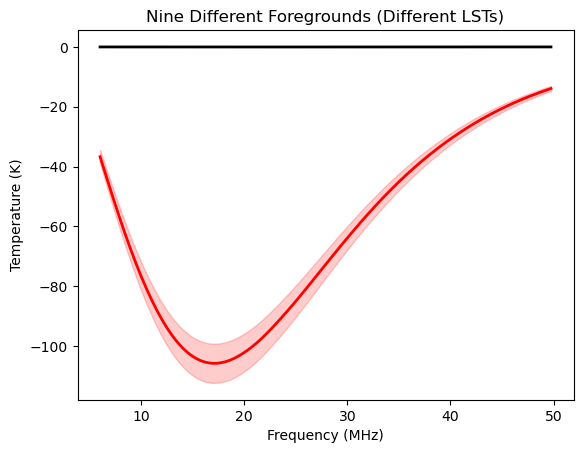

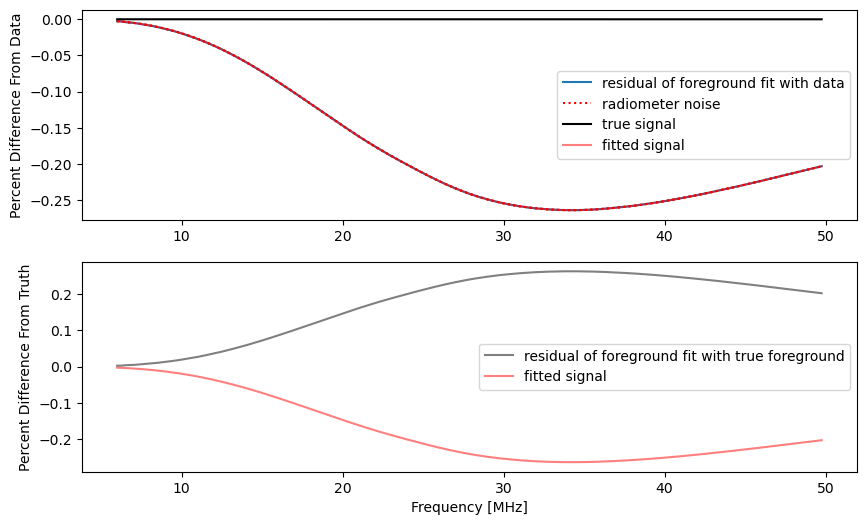

In [ ]:
### 9 LSTs ###

## Creates a training set with varied foreground and beams for all 4 different foregrounds:
Nb = 800
N = 800

IC = "DIC"

custom_parameter_range = np.array([[0.5,3],[3.2,4.2],[3.8,4.8]])  
# custom_parameter_range = np.array([[1,1.1],[3.4,3.41],[4.6,4.61]])# For making a random foreground
parameter_variation = [0.05,0.025,0.05]                           # For making a random foreground
# custom_parameter_range = np.array([[1,1],[3.4,3.4],[4.6,4.6]])
# custom_parameter_range = np.array([[1,1.1],[3.4,3.5],[4.6,4.7]])
# custom_parameter_range = np.array([[0.995,1.005],[3.3997,3.40027],[4.598,4.60128]])
# parameter_variation = [0.0002,0.0001,0.0002]
# parameter_variation = [0,0,0]
## Interpolate the varied beams to match the rest of the data
varied_regolith_training_set = np.zeros((len(varied_regolith_training_set_raw),len(frequencies)))
for n in range(len(varied_regolith_training_set_raw)):
    beam_regolith_interp = scipy.interpolate.CubicSpline(range(1,51),varied_regolith_training_set_raw[n,0,:])
    varied_regolith_training_set[n] = beam_regolith_interp(frequencies)
 # number of beams in the beam training set
exp_test=py21cmsig.expanded_training_set_no_t(varied_regolith_training_set,varied_regolith_training_set_raw_params,Nb,\
                               custom_parameter_range,show_parameter_ranges=True)


n_regions = 5
reference_frequency = 25
sky_map = foreground_array_minCMB[0]
BTS_curves = exp_test[0]
BTS_params = exp_test[1]
beam_sky_training_set = beams[:,5:,:]
beam_sky_training_set_params = varied_regolith_training_set_raw_params
raw_beam_weighted_sky_maps = raw_sky_maps

# parameter_variation = [0.05,0.025,0.05]
determine_parameter_range = True
new_FG_parameter_mean = None
foreground_run_set_1 = py21cmsig.synchrotron_foreground_forsigex(n_regions,frequencies,reference_frequency,sky_map,BTS_curves,BTS_params,\
                                    beam_sky_training_set,beam_sky_training_set_params,N,parameter_variation,B_value_functions, \
                                        define_parameter_mean=False,parameter_mean=new_FG_parameter_mean)
rms_values = py21cmsig.narrowed_training_set(simulation_test_beam_1[0],rms_mean,rms_std,foreground_run_set_1[3],foreground_run_set_1[4])[2]
new_parameter_mean = np.zeros((n_regions,3))
fg_range_array = np.zeros((n_regions,6))
foreground_parameter_variation = np.array(parameter_variation)

## Foreground 2

## Creates a training set with varied foreground and beams:

## Interpolate the varied beams to match the rest of the data
varied_regolith_training_set_2 = np.zeros((len(varied_regolith_training_set_raw_2),len(frequencies)))
for n in range(len(varied_regolith_training_set_raw_2)):
    beam_regolith_interp = scipy.interpolate.CubicSpline(range(1,51),varied_regolith_training_set_raw_2[n,0,:])
    varied_regolith_training_set[n] = beam_regolith_interp(frequencies)
 # number of beams in the beam training set
exp_test=py21cmsig.expanded_training_set_no_t(varied_regolith_training_set,varied_regolith_training_set_raw_params,Nb,\
                               custom_parameter_range,show_parameter_ranges=True)
n_regions = 5
reference_frequency = 25
sky_map = foreground_array_minCMB_2[0]
BTS_curves = exp_test[0]
BTS_params = exp_test[1]
beam_sky_training_set = beams[:,5:,:]
beam_sky_training_set_params = varied_regolith_training_set_raw_params
raw_beam_weighted_sky_maps = raw_sky_maps

# parameter_variation = [0.05,0.025,0.05]
determine_parameter_range = True
new_FG_parameter_mean = None
foreground_run_set_2 = py21cmsig.synchrotron_foreground_forsigex(n_regions,frequencies,reference_frequency,sky_map,BTS_curves,BTS_params,\
                                    beam_sky_training_set,beam_sky_training_set_params,N,parameter_variation, B_value_functions,\
                                        define_parameter_mean=False,parameter_mean=new_FG_parameter_mean)
rms_values = py21cmsig.narrowed_training_set(simulation_test_beam_2[0],rms_mean,rms_std,foreground_run_set_2[3],foreground_run_set_2[4])[2]
new_parameter_mean = np.zeros((n_regions,3))
fg_range_array = np.zeros((n_regions,6))
foreground_parameter_variation = np.array(parameter_variation)

## Foreground 3

## Creates a training set with varied foreground and beams:


## Interpolate the varied beams to match the rest of the data
varied_regolith_training_set_3 = np.zeros((len(varied_regolith_training_set_raw_3),len(frequencies)))
for n in range(len(varied_regolith_training_set_raw_3)):
    beam_regolith_interp = scipy.interpolate.CubicSpline(range(1,51),varied_regolith_training_set_raw_3[n,0,:])
    varied_regolith_training_set[n] = beam_regolith_interp(frequencies)
 # number of beams in the beam training set
exp_test=py21cmsig.expanded_training_set_no_t(varied_regolith_training_set,varied_regolith_training_set_raw_params,Nb,\
                               custom_parameter_range,show_parameter_ranges=True)
n_regions = 5
reference_frequency = 25
sky_map = foreground_array_minCMB_3[0]
BTS_curves = exp_test[0]
BTS_params = exp_test[1]
beam_sky_training_set = beams[:,5:,:]
beam_sky_training_set_params = varied_regolith_training_set_raw_params
raw_beam_weighted_sky_maps = raw_sky_maps

# parameter_variation = [0.05,0.025,0.05]
determine_parameter_range = True
new_FG_parameter_mean = None
foreground_run_set_3 = py21cmsig.synchrotron_foreground_forsigex(n_regions,frequencies,reference_frequency,sky_map,BTS_curves,BTS_params,\
                                    beam_sky_training_set,beam_sky_training_set_params,N,parameter_variation, B_value_functions,\
                                        define_parameter_mean=False,parameter_mean=new_FG_parameter_mean)
rms_values = py21cmsig.narrowed_training_set(simulation_test_beam_3[0],rms_mean,rms_std,foreground_run_set_3[3],foreground_run_set_3[4])[2]
new_parameter_mean = np.zeros((n_regions,3))
fg_range_array = np.zeros((n_regions,6))
foreground_parameter_variation = np.array(parameter_variation)

## Foreground 4

## Creates a training set with varied foreground and beams:


## Interpolate the varied beams to match the rest of the data
varied_regolith_training_set_4 = np.zeros((len(varied_regolith_training_set_raw_4),len(frequencies)))
for n in range(len(varied_regolith_training_set_raw_4)):
    beam_regolith_interp = scipy.interpolate.CubicSpline(range(1,51),varied_regolith_training_set_raw_4[n,0,:])
    varied_regolith_training_set[n] = beam_regolith_interp(frequencies)
 # number of beams in the beam training set
exp_test=py21cmsig.expanded_training_set_no_t(varied_regolith_training_set,varied_regolith_training_set_raw_params,Nb,\
                               custom_parameter_range,show_parameter_ranges=True)
n_regions = 5
reference_frequency = 25
sky_map = foreground_array_minCMB_4[0]
BTS_curves = exp_test[0]
BTS_params = exp_test[1]
beam_sky_training_set = beams[:,5:,:]
beam_sky_training_set_params = varied_regolith_training_set_raw_params
raw_beam_weighted_sky_maps = raw_sky_maps


determine_parameter_range = True
new_FG_parameter_mean = None
foreground_run_set_4 = py21cmsig.synchrotron_foreground_forsigex(n_regions,frequencies,reference_frequency,sky_map,BTS_curves,BTS_params,\
                                    beam_sky_training_set,beam_sky_training_set_params,N,parameter_variation,B_value_functions, \
                                        define_parameter_mean=False,parameter_mean=new_FG_parameter_mean)
rms_values =py21cmsig.narrowed_training_set(simulation_test_beam_4[0],rms_mean,rms_std,foreground_run_set_4[3],foreground_run_set_4[4])[2]
new_parameter_mean = np.zeros((n_regions,3))
fg_range_array = np.zeros((n_regions,6))
foreground_parameter_variation = np.array(parameter_variation)

## Foreground 5

## Creates a training set with varied foreground and beams:


## Interpolate the varied beams to match the rest of the data
varied_regolith_training_set_5 = np.zeros((len(varied_regolith_training_set_raw_5),len(frequencies)))
for n in range(len(varied_regolith_training_set_raw_5)):
    beam_regolith_interp = scipy.interpolate.CubicSpline(range(1,51),varied_regolith_training_set_raw_5[n,0,:])
    varied_regolith_training_set[n] = beam_regolith_interp(frequencies)
 # number of beams in the beam training set
exp_test=py21cmsig.expanded_training_set_no_t(varied_regolith_training_set,varied_regolith_training_set_raw_params,Nb,\
                               custom_parameter_range,show_parameter_ranges=True)
n_regions = 5
reference_frequency = 25
sky_map = foreground_array_minCMB_5[0]
BTS_curves = exp_test[0]
BTS_params = exp_test[1]
beam_sky_training_set = beams[:,5:,:]
beam_sky_training_set_params = varied_regolith_training_set_raw_params
raw_beam_weighted_sky_maps = raw_sky_maps


determine_parameter_range = True
new_FG_parameter_mean = None
foreground_run_set_5 = py21cmsig.synchrotron_foreground_forsigex(n_regions,frequencies,reference_frequency,sky_map,BTS_curves,BTS_params,\
                                    beam_sky_training_set,beam_sky_training_set_params,N,parameter_variation,B_value_functions, \
                                        define_parameter_mean=False,parameter_mean=new_FG_parameter_mean)
rms_values = py21cmsig.narrowed_training_set(simulation_test_beam_5[0],rms_mean,rms_std,foreground_run_set_5[3],foreground_run_set_5[4])[2]
new_parameter_mean = np.zeros((n_regions,3))
fg_range_array = np.zeros((n_regions,6))
foreground_parameter_variation = np.array(parameter_variation)

## Foreground 6

## Creates a training set with varied foreground and beams:


## Interpolate the varied beams to match the rest of the data
varied_regolith_training_set_6 = np.zeros((len(varied_regolith_training_set_raw_6),len(frequencies)))
for n in range(len(varied_regolith_training_set_raw_6)):
    beam_regolith_interp = scipy.interpolate.CubicSpline(range(1,51),varied_regolith_training_set_raw_6[n,0,:])
    varied_regolith_training_set[n] = beam_regolith_interp(frequencies)
 # number of beams in the beam training set
exp_test=py21cmsig.expanded_training_set_no_t(varied_regolith_training_set,varied_regolith_training_set_raw_params,Nb,\
                               custom_parameter_range,show_parameter_ranges=True)
n_regions = 5
reference_frequency = 25
sky_map = foreground_array_minCMB_6[0]
BTS_curves = exp_test[0]
BTS_params = exp_test[1]
beam_sky_training_set = beams[:,5:,:]
beam_sky_training_set_params = varied_regolith_training_set_raw_params
raw_beam_weighted_sky_maps = raw_sky_maps


determine_parameter_range = True
new_FG_parameter_mean = None
foreground_run_set_6 = py21cmsig.synchrotron_foreground_forsigex(n_regions,frequencies,reference_frequency,sky_map,BTS_curves,BTS_params,\
                                    beam_sky_training_set,beam_sky_training_set_params,N,parameter_variation,B_value_functions, \
                                        define_parameter_mean=False,parameter_mean=new_FG_parameter_mean)
rms_values = py21cmsig.narrowed_training_set(simulation_test_beam_6[0],rms_mean,rms_std,foreground_run_set_6[3],foreground_run_set_6[4])[2]
new_parameter_mean = np.zeros((n_regions,3))
fg_range_array = np.zeros((n_regions,6))
foreground_parameter_variation = np.array(parameter_variation)

## Foreground 7

## Creates a training set with varied foreground and beams:


## Interpolate the varied beams to match the rest of the data
varied_regolith_training_set_7 = np.zeros((len(varied_regolith_training_set_raw_7),len(frequencies)))
for n in range(len(varied_regolith_training_set_raw_7)):
    beam_regolith_interp = scipy.interpolate.CubicSpline(range(1,51),varied_regolith_training_set_raw_7[n,0,:])
    varied_regolith_training_set[n] = beam_regolith_interp(frequencies)
 # number of beams in the beam training set
exp_test=py21cmsig.expanded_training_set_no_t(varied_regolith_training_set,varied_regolith_training_set_raw_params,Nb,\
                               custom_parameter_range,show_parameter_ranges=True)
n_regions = 5
reference_frequency = 25
sky_map = foreground_array_minCMB_7[0]
BTS_curves = exp_test[0]
BTS_params = exp_test[1]
beam_sky_training_set = beams[:,5:,:]
beam_sky_training_set_params = varied_regolith_training_set_raw_params
raw_beam_weighted_sky_maps = raw_sky_maps


determine_parameter_range = True
new_FG_parameter_mean = None
foreground_run_set_7 = py21cmsig.synchrotron_foreground_forsigex(n_regions,frequencies,reference_frequency,sky_map,BTS_curves,BTS_params,\
                                    beam_sky_training_set,beam_sky_training_set_params,N,parameter_variation, B_value_functions,\
                                        define_parameter_mean=False,parameter_mean=new_FG_parameter_mean)
rms_values = py21cmsig.narrowed_training_set(simulation_test_beam_7[0],rms_mean,rms_std,foreground_run_set_7[3],foreground_run_set_7[4])[2]
new_parameter_mean = np.zeros((n_regions,3))
fg_range_array = np.zeros((n_regions,6))
foreground_parameter_variation = np.array(parameter_variation)

## Foreground 8

## Creates a training set with varied foreground and beams:


## Interpolate the varied beams to match the rest of the data
varied_regolith_training_set_8 = np.zeros((len(varied_regolith_training_set_raw_8),len(frequencies)))
for n in range(len(varied_regolith_training_set_raw_8)):
    beam_regolith_interp = scipy.interpolate.CubicSpline(range(1,51),varied_regolith_training_set_raw_8[n,0,:])
    varied_regolith_training_set[n] = beam_regolith_interp(frequencies)
 # number of beams in the beam training set
exp_test=py21cmsig.expanded_training_set_no_t(varied_regolith_training_set,varied_regolith_training_set_raw_params,Nb,\
                               custom_parameter_range,show_parameter_ranges=True)
n_regions = 5
reference_frequency = 25
sky_map = foreground_array_minCMB_8[0]
BTS_curves = exp_test[0]
BTS_params = exp_test[1]
beam_sky_training_set = beams[:,5:,:]
beam_sky_training_set_params = varied_regolith_training_set_raw_params
raw_beam_weighted_sky_maps = raw_sky_maps


determine_parameter_range = True
new_FG_parameter_mean = None
foreground_run_set_8 = py21cmsig.synchrotron_foreground_forsigex(n_regions,frequencies,reference_frequency,sky_map,BTS_curves,BTS_params,\
                                    beam_sky_training_set,beam_sky_training_set_params,N,parameter_variation,B_value_functions, \
                                        define_parameter_mean=False,parameter_mean=new_FG_parameter_mean)
rms_values = py21cmsig.narrowed_training_set(simulation_test_beam_8[0],rms_mean,rms_std,foreground_run_set_8[3],foreground_run_set_8[4])[2]
new_parameter_mean = np.zeros((n_regions,3))
fg_range_array = np.zeros((n_regions,6))
foreground_parameter_variation = np.array(parameter_variation)

## Foreground 9

## Creates a training set with varied foreground and beams:


## Interpolate the varied beams to match the rest of the data
varied_regolith_training_set_9 = np.zeros((len(varied_regolith_training_set_raw_9),len(frequencies)))
for n in range(len(varied_regolith_training_set_raw_9)):
    beam_regolith_interp = scipy.interpolate.CubicSpline(range(1,51),varied_regolith_training_set_raw_9[n,0,:])
    varied_regolith_training_set[n] = beam_regolith_interp(frequencies)
 # number of beams in the beam training set
exp_test=py21cmsig.expanded_training_set_no_t(varied_regolith_training_set,varied_regolith_training_set_raw_params,Nb,\
                               custom_parameter_range,show_parameter_ranges=True)
n_regions = 5
reference_frequency = 25
sky_map = foreground_array_minCMB_9[0]
BTS_curves = exp_test[0]
BTS_params = exp_test[1]
beam_sky_training_set = beams[:,5:,:]
beam_sky_training_set_params = varied_regolith_training_set_raw_params
raw_beam_weighted_sky_maps = raw_sky_maps


determine_parameter_range = True
new_FG_parameter_mean = None
foreground_run_set_9 = py21cmsig.synchrotron_foreground_forsigex(n_regions,frequencies,reference_frequency,sky_map,BTS_curves,BTS_params,\
                                    beam_sky_training_set,beam_sky_training_set_params,N,parameter_variation, B_value_functions,\
                                        define_parameter_mean=False,parameter_mean=new_FG_parameter_mean)
rms_values = py21cmsig.narrowed_training_set(simulation_test_beam_9[0],rms_mean,rms_std,foreground_run_set_9[3],foreground_run_set_9[4])[2]
new_parameter_mean = np.zeros((n_regions,3))
fg_range_array = np.zeros((n_regions,6))
foreground_parameter_variation = np.array(parameter_variation)

### Combine them all
foreground_run_combined_9 = np.zeros((Nb*N,9,len(frequencies)))
foreground_run_combined_9[:,0,:] = foreground_run_set_1[3]
foreground_run_combined_9[:,1,:] = foreground_run_set_2[3]
foreground_run_combined_9[:,2,:] = foreground_run_set_3[3]
foreground_run_combined_9[:,3,:] = foreground_run_set_4[3]
foreground_run_combined_9[:,4,:] = foreground_run_set_5[3]
foreground_run_combined_9[:,5,:] = foreground_run_set_6[3]
foreground_run_combined_9[:,6,:] = foreground_run_set_7[3]
foreground_run_combined_9[:,7,:] = foreground_run_set_8[3]
foreground_run_combined_9[:,8,:] = foreground_run_set_9[3]
# foreground_run_combined = np.concatenate((foreground_run_set_1[3],foreground_run_set_2[3],foreground_run_set_3[3],foreground_run_set_4[3]),axis=0)

# #Let's first start by combining the two arrays for the two separate signals:
fg_training_set = copy.deepcopy(foreground_run_combined_9)
flattened_foreground_training_set = np.reshape(fg_training_set, (len(fg_training_set), -1))
signal_training_set_4LST = copy.deepcopy(DMAN_training_set[0])

total_signal = np.zeros((9,len(frequencies)))
total_signal[0,:] = simulation_test_beam_1[0]
total_signal[1,:] = simulation_test_beam_2[0]
total_signal[2,:] = simulation_test_beam_3[0]
total_signal[3,:] = simulation_test_beam_4[0]
total_signal[4,:] = simulation_test_beam_5[0]
total_signal[5,:] = simulation_test_beam_6[0]
total_signal[6,:] = simulation_test_beam_7[0]
total_signal[7,:] = simulation_test_beam_8[0]
total_signal[8,:] = simulation_test_beam_9[0]

total_noise = np.zeros((9,len(frequencies)))
noise_level_1 = sigT(simulation_test_beam_1[0],dnu,dt)
noise_level_2 = sigT(simulation_test_beam_2[0],dnu,dt)
noise_level_3 = sigT(simulation_test_beam_3[0],dnu,dt)
noise_level_4 = sigT(simulation_test_beam_4[0],dnu,dt)
noise_level_5 = sigT(simulation_test_beam_5[0],dnu,dt)
noise_level_6 = sigT(simulation_test_beam_6[0],dnu,dt)
noise_level_7 = sigT(simulation_test_beam_7[0],dnu,dt)
noise_level_8 = sigT(simulation_test_beam_8[0],dnu,dt)
noise_level_9 = sigT(simulation_test_beam_9[0],dnu,dt)
total_noise[0,:] = noise_level_1
total_noise[1,:] = noise_level_2
total_noise[2,:] = noise_level_3
total_noise[3,:] = noise_level_4
total_noise[4,:] = noise_level_5
total_noise[5,:] = noise_level_6
total_noise[6,:] = noise_level_7
total_noise[7,:] = noise_level_8
total_noise[8,:] = noise_level_9



# pylinex requires 1D arrays, so let's flatten the noise_level and temperatures matrices (i.e. collapse the spectra)
temperatures_flat = total_signal.flatten()
noise_level_flat = total_noise.flatten()

# same as in Problem 3, let's use PowerLawTimesLogPolynomialModel for the foreground and a Gaussian for the signal


# across the 8 spectra, the signal is the same, but the foreground changes
# so, we have to make a different basis vector for each of the foreground spectra, but one basis for the sinal
names = ['foreground','signal']

                  # to transform the basis vectors from one space to another (e.g. into the data space), we use the Expander objects. 
                  # for the foreground, we will use PadExpander, which pads each foreground basis vector with zeros for the other spectra
                  # for the signal, we will use RepeatExpander, which expands vectors by repeating them multiple times
                  # (i.e. the signal is constant over the 8 pointings)

bases = [TrainedBasis(flattened_foreground_training_set,num_basis_vectors=600, expander=NullExpander()),\
TrainedBasis(signal_training_set_4LST,num_basis_vectors=40, expander=RepeatExpander(9))]
bases[0].generate_gaussian_prior()
bases[1].generate_gaussian_prior()

# define BasisSum object for pylinex's Fitter class 
# again using multiple bases, 8 for the foreground and one for the signal Gaussian
basis_sum = BasisSum(names, bases)

# same as in Problems 2 and 3,
# we optimize the number of terms by minimizing the Bayesian predictive information criterion (BPIC)
quantity = AttributeQuantity(IC)

# now set the number of terms to search numerically to minimize the BPIC
# choosing between 1 and 10 terms for each of the foregrounds, and 1 term for the signal
# placing the foreground spectra in the same dictionary,
# so that MetaFitter knows each will use the same number of terms (decreasing number of fits to perform)
dimension = [{"foreground": np.arange(1,600)},
{'signal': np.arange(1,30)}]

# now use MetaFitter to perform fits over the grid and choose the optimal fit based on minimizing the BPIC
# priors = {"signal_prior" : bases[1].gaussian_prior}
meta_fitter = MetaFitter(basis_sum, temperatures_flat, noise_level_flat, quantity,\
quantity.name, *dimension)

# grab the Fitter object that corresponds to the fit that minimized the BPIC statistic
fitter_9 = meta_fitter.fitter_from_indices(meta_fitter.minimize_quantity(IC))
num_foreground_terms = fitter_9.sizes['foreground']
num_signal_terms = fitter_9.sizes["signal"]
print(f'The MetaFitter chose %i foreground terms based on {IC} minimization.' % num_foreground_terms)
print(f'The MetaFitter chose %i signal terms based on {IC} minimization.' % num_signal_terms)
print(f"{fitter_9.subbasis_channel_mean("signal").min()} Temperature of lowest point of the trough ")
print(f"{fitter_9.subbasis_channel_error("signal")[np.where(fitter_9.subbasis_channel_mean("signal")==fitter_9.subbasis_channel_mean("signal").min())][0]} Channel error at lowest point of the trough ")
print(f"{fitter_9.log_evidence} log evidence")
print(f"{fitter_9.chi_squared} Chi Squared")
print(f"{fitter_9.psi_squared} Psi Squared")
pearsonr=scipy.stats.pearsonr(fitter_9.subbasis_channel_mean("signal")/simulation_test_beam_1[2],(fitter_9.subbasis_channel_mean("foreground")[0:len(frequencies)]-simulation_test_beam_1[2])/simulation_test_beam_1[2])
print(f"True {pearsonr}")
fitter_9.plot_subbasis_fit(nsigma=1, name='signal', x_values=frequencies,\
colors='r', xlabel='Frequency (MHz)', ylabel='Temperature (K)',\
title='Nine Different Foregrounds (Different LSTs)', show=True,true_curve = simulation_test_beam_1[1])


fig, (ax1, ax2) = plt.subplots(2,1,figsize=(10, 6))
plt.subplot(2,1,1)
plt.plot(frequencies,(simulation_test_beam_1[0]-fitter_9.subbasis_channel_mean("foreground")[0:len(frequencies)])/simulation_test_beam_1[0]*100,label="residual of foreground fit with data")
plt.plot(frequencies,(fitter_9.subbasis_channel_mean("signal")+sigT(simulation_test_beam_1[0],dnu,dt))/simulation_test_beam_1[0]*100,color="red",ls=":" ,label="radiometer noise")
plt.plot(frequencies,(fitter_9.subbasis_channel_mean("signal")-sigT(simulation_test_beam_1[0],dnu,dt))/simulation_test_beam_1[0]*100,color="red", ls=":")
plt.plot(frequencies,simulation_test_beam_1[1]/simulation_test_beam_1[0]*100,label="true signal",c="black")
plt.plot(frequencies,fitter_9.subbasis_channel_mean("signal")/simulation_test_beam_1[0]*100,label="fitted signal",alpha=0.5,c='red')
plt.ylabel("Percent Difference From Data")

plt.legend()

# Plots a handy plot of the true foreground residual from the simulation minus the foreground fit compared to the signal fit
# Good for identifying degeneracy by eye (pearson r is quantifying this)
plt.subplot(2,1,2)
plt.title("")
plt.plot(frequencies,((fitter_9.subbasis_channel_mean("foreground")[0:len(frequencies)]-simulation_test_beam_1[2]))/simulation_test_beam_1[2]*100,c="grey",label="residual of foreground fit with true foreground")
plt.plot(frequencies,fitter_9.subbasis_channel_mean("signal")/simulation_test_beam_1[2]*100,c="red",alpha=0.5,label="fitted signal")
plt.xlabel("Frequency [MHz]")
plt.ylabel("Percent Difference From Truth")
plt.legend()

100%|██████████| 176/176 [00:01<00:00, 169.89it/s]


[[0.75 1.25]
 [3.3  3.5 ]
 [4.5  4.7 ]]


100%|██████████| 500/500 [00:02<00:00, 221.48it/s]


[0.005, 0.0025, 0.005]


100%|██████████| 176/176 [00:01<00:00, 167.32it/s]


[[0.75 1.25]
 [3.3  3.5 ]
 [4.5  4.7 ]]


100%|██████████| 500/500 [00:02<00:00, 211.04it/s]


[0.005, 0.0025, 0.005]


100%|██████████| 176/176 [00:01<00:00, 161.45it/s]


[[0.75 1.25]
 [3.3  3.5 ]
 [4.5  4.7 ]]


100%|██████████| 500/500 [00:02<00:00, 230.32it/s]


[0.005, 0.0025, 0.005]


100%|██████████| 176/176 [00:01<00:00, 170.72it/s]


[[0.75 1.25]
 [3.3  3.5 ]
 [4.5  4.7 ]]


100%|██████████| 500/500 [00:02<00:00, 235.64it/s]


[0.005, 0.0025, 0.005]


100%|██████████| 176/176 [00:01<00:00, 153.52it/s]


[[0.75 1.25]
 [3.3  3.5 ]
 [4.5  4.7 ]]


100%|██████████| 500/500 [00:02<00:00, 234.72it/s]


[0.005, 0.0025, 0.005]


100%|██████████| 176/176 [00:01<00:00, 143.37it/s]


[[0.75 1.25]
 [3.3  3.5 ]
 [4.5  4.7 ]]


100%|██████████| 500/500 [00:02<00:00, 228.80it/s]


[0.005, 0.0025, 0.005]


100%|██████████| 176/176 [00:01<00:00, 163.44it/s]


[[0.75 1.25]
 [3.3  3.5 ]
 [4.5  4.7 ]]


100%|██████████| 500/500 [00:02<00:00, 216.06it/s]


[0.005, 0.0025, 0.005]


100%|██████████| 176/176 [00:01<00:00, 165.73it/s]


[[0.75 1.25]
 [3.3  3.5 ]
 [4.5  4.7 ]]


100%|██████████| 500/500 [00:02<00:00, 206.43it/s]


[0.005, 0.0025, 0.005]


100%|██████████| 176/176 [00:01<00:00, 164.18it/s]


[[0.75 1.25]
 [3.3  3.5 ]
 [4.5  4.7 ]]


100%|██████████| 500/500 [00:02<00:00, 221.56it/s]


[0.005, 0.0025, 0.005]


100%|██████████| 250000/250000 [00:01<00:00, 205832.86it/s]


Minimizing BPIC over grid.
The MetaFitter chose 262 foreground terms based on BPIC minimization.
The MetaFitter chose 1 signal terms based on BPIC minimization.
0.013681006985229978 Temperature of lowest point of the trough 
0.010470564094878378 Channel error at lowest point of the trough 
1050832.8094804364 log evidence
1302.909796802866 Chi Squared
0.8159466426612214 Psi Squared
True PearsonRResult(statistic=-0.9963804995348287, pvalue=3.207734648662002e-188)


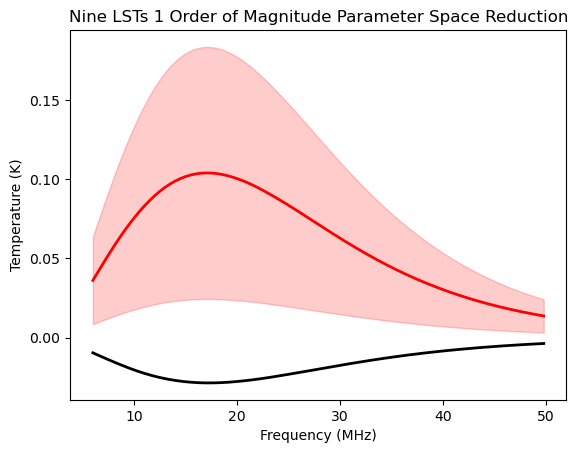

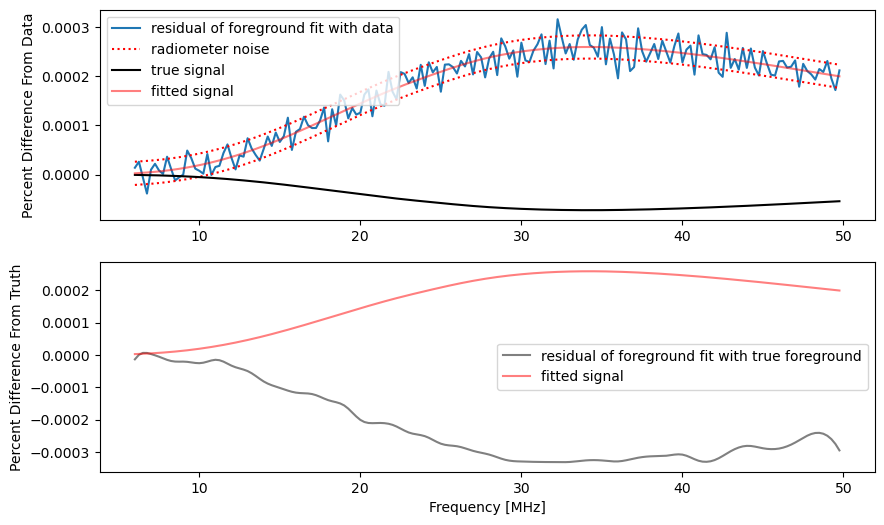

In [ ]:
### 9 LSTs ###

## Creates a training set with varied foreground and beams for all 4 different foregrounds:

custom_parameter_range = np.array([[0.75,1.25],[3.3,3.5],[4.5,4.7]])  # For making a random foreground
parameter_variation = [0.005,0.0025,0.005]                         # For making a random foreground
# custom_parameter_range = np.array([[1,1],[3.4,3.4],[4.6,4.6]])
# custom_parameter_range = np.array([[1,1.1],[3.4,3.5],[4.6,4.7]])
# custom_parameter_range = np.array([[0.995,1.005],[3.3997,3.40027],[4.598,4.60128]])
# parameter_variation = [0.0002,0.0001,0.0002]
# parameter_variation = [0,0,0]
## Interpolate the varied beams to match the rest of the data
varied_regolith_training_set = np.zeros((len(varied_regolith_training_set_raw),len(frequencies)))
for n in range(len(varied_regolith_training_set_raw)):
    beam_regolith_interp = scipy.interpolate.CubicSpline(range(1,51),varied_regolith_training_set_raw[n,0,:])
    varied_regolith_training_set[n] = beam_regolith_interp(frequencies)
 # number of beams in the beam training set
exp_test=py21cmsig.expanded_training_set_no_t(varied_regolith_training_set,varied_regolith_training_set_raw_params,Nb,\
                               custom_parameter_range,show_parameter_ranges=True)


n_regions = 5
reference_frequency = 25
sky_map = foreground_array_minCMB[0]
BTS_curves = exp_test[0]
BTS_params = exp_test[1]
beam_sky_training_set = beams[:,5:,:]
beam_sky_training_set_params = varied_regolith_training_set_raw_params
raw_beam_weighted_sky_maps = raw_sky_maps

# parameter_variation = [0.05,0.025,0.05]
determine_parameter_range = True
new_FG_parameter_mean = None
foreground_run_set_1 = py21cmsig.synchrotron_foreground_forsigex(n_regions,frequencies,reference_frequency,sky_map,BTS_curves,BTS_params,\
                                    beam_sky_training_set,beam_sky_training_set_params,N,parameter_variation,B_value_functions, \
                                        define_parameter_mean=False,parameter_mean=new_FG_parameter_mean)
rms_values = py21cmsig.narrowed_training_set(simulation_test_beam_1[0],rms_mean,rms_std,foreground_run_set_1[3],foreground_run_set_1[4])[2]
new_parameter_mean = np.zeros((n_regions,3))
fg_range_array = np.zeros((n_regions,6))
foreground_parameter_variation = np.array(parameter_variation)

## Foreground 2

## Creates a training set with varied foreground and beams:

## Interpolate the varied beams to match the rest of the data
varied_regolith_training_set_2 = np.zeros((len(varied_regolith_training_set_raw_2),len(frequencies)))
for n in range(len(varied_regolith_training_set_raw_2)):
    beam_regolith_interp = scipy.interpolate.CubicSpline(range(1,51),varied_regolith_training_set_raw_2[n,0,:])
    varied_regolith_training_set[n] = beam_regolith_interp(frequencies)
 # number of beams in the beam training set
exp_test=py21cmsig.expanded_training_set_no_t(varied_regolith_training_set,varied_regolith_training_set_raw_params,Nb,\
                               custom_parameter_range,show_parameter_ranges=True)
n_regions = 5
reference_frequency = 25
sky_map = foreground_array_minCMB_2[0]
BTS_curves = exp_test[0]
BTS_params = exp_test[1]
beam_sky_training_set = beams[:,5:,:]
beam_sky_training_set_params = varied_regolith_training_set_raw_params
raw_beam_weighted_sky_maps = raw_sky_maps

# parameter_variation = [0.05,0.025,0.05]
determine_parameter_range = True
new_FG_parameter_mean = None
foreground_run_set_2 = py21cmsig.synchrotron_foreground_forsigex(n_regions,frequencies,reference_frequency,sky_map,BTS_curves,BTS_params,\
                                    beam_sky_training_set,beam_sky_training_set_params,N,parameter_variation, B_value_functions,\
                                        define_parameter_mean=False,parameter_mean=new_FG_parameter_mean)
rms_values = py21cmsig.narrowed_training_set(simulation_test_beam_2[0],rms_mean,rms_std,foreground_run_set_2[3],foreground_run_set_2[4])[2]
new_parameter_mean = np.zeros((n_regions,3))
fg_range_array = np.zeros((n_regions,6))
foreground_parameter_variation = np.array(parameter_variation)

## Foreground 3

## Creates a training set with varied foreground and beams:


## Interpolate the varied beams to match the rest of the data
varied_regolith_training_set_3 = np.zeros((len(varied_regolith_training_set_raw_3),len(frequencies)))
for n in range(len(varied_regolith_training_set_raw_3)):
    beam_regolith_interp = scipy.interpolate.CubicSpline(range(1,51),varied_regolith_training_set_raw_3[n,0,:])
    varied_regolith_training_set[n] = beam_regolith_interp(frequencies)
 # number of beams in the beam training set
exp_test=py21cmsig.expanded_training_set_no_t(varied_regolith_training_set,varied_regolith_training_set_raw_params,Nb,\
                               custom_parameter_range,show_parameter_ranges=True)
n_regions = 5
reference_frequency = 25
sky_map = foreground_array_minCMB_3[0]
BTS_curves = exp_test[0]
BTS_params = exp_test[1]
beam_sky_training_set = beams[:,5:,:]
beam_sky_training_set_params = varied_regolith_training_set_raw_params
raw_beam_weighted_sky_maps = raw_sky_maps

# parameter_variation = [0.05,0.025,0.05]
determine_parameter_range = True
new_FG_parameter_mean = None
foreground_run_set_3 = py21cmsig.synchrotron_foreground_forsigex(n_regions,frequencies,reference_frequency,sky_map,BTS_curves,BTS_params,\
                                    beam_sky_training_set,beam_sky_training_set_params,N,parameter_variation, B_value_functions,\
                                        define_parameter_mean=False,parameter_mean=new_FG_parameter_mean)
rms_values = py21cmsig.narrowed_training_set(simulation_test_beam_3[0],rms_mean,rms_std,foreground_run_set_3[3],foreground_run_set_3[4])[2]
new_parameter_mean = np.zeros((n_regions,3))
fg_range_array = np.zeros((n_regions,6))
foreground_parameter_variation = np.array(parameter_variation)

## Foreground 4

## Creates a training set with varied foreground and beams:


## Interpolate the varied beams to match the rest of the data
varied_regolith_training_set_4 = np.zeros((len(varied_regolith_training_set_raw_4),len(frequencies)))
for n in range(len(varied_regolith_training_set_raw_4)):
    beam_regolith_interp = scipy.interpolate.CubicSpline(range(1,51),varied_regolith_training_set_raw_4[n,0,:])
    varied_regolith_training_set[n] = beam_regolith_interp(frequencies)
 # number of beams in the beam training set
exp_test=py21cmsig.expanded_training_set_no_t(varied_regolith_training_set,varied_regolith_training_set_raw_params,Nb,\
                               custom_parameter_range,show_parameter_ranges=True)
n_regions = 5
reference_frequency = 25
sky_map = foreground_array_minCMB_4[0]
BTS_curves = exp_test[0]
BTS_params = exp_test[1]
beam_sky_training_set = beams[:,5:,:]
beam_sky_training_set_params = varied_regolith_training_set_raw_params
raw_beam_weighted_sky_maps = raw_sky_maps


determine_parameter_range = True
new_FG_parameter_mean = None
foreground_run_set_4 = py21cmsig.synchrotron_foreground_forsigex(n_regions,frequencies,reference_frequency,sky_map,BTS_curves,BTS_params,\
                                    beam_sky_training_set,beam_sky_training_set_params,N,parameter_variation,B_value_functions, \
                                        define_parameter_mean=False,parameter_mean=new_FG_parameter_mean)
rms_values =py21cmsig.narrowed_training_set(simulation_test_beam_4[0],rms_mean,rms_std,foreground_run_set_4[3],foreground_run_set_4[4])[2]
new_parameter_mean = np.zeros((n_regions,3))
fg_range_array = np.zeros((n_regions,6))
foreground_parameter_variation = np.array(parameter_variation)

## Foreground 5

## Creates a training set with varied foreground and beams:


## Interpolate the varied beams to match the rest of the data
varied_regolith_training_set_5 = np.zeros((len(varied_regolith_training_set_raw_5),len(frequencies)))
for n in range(len(varied_regolith_training_set_raw_5)):
    beam_regolith_interp = scipy.interpolate.CubicSpline(range(1,51),varied_regolith_training_set_raw_5[n,0,:])
    varied_regolith_training_set[n] = beam_regolith_interp(frequencies)
 # number of beams in the beam training set
exp_test=py21cmsig.expanded_training_set_no_t(varied_regolith_training_set,varied_regolith_training_set_raw_params,Nb,\
                               custom_parameter_range,show_parameter_ranges=True)
n_regions = 5
reference_frequency = 25
sky_map = foreground_array_minCMB_5[0]
BTS_curves = exp_test[0]
BTS_params = exp_test[1]
beam_sky_training_set = beams[:,5:,:]
beam_sky_training_set_params = varied_regolith_training_set_raw_params
raw_beam_weighted_sky_maps = raw_sky_maps


determine_parameter_range = True
new_FG_parameter_mean = None
foreground_run_set_5 = py21cmsig.synchrotron_foreground_forsigex(n_regions,frequencies,reference_frequency,sky_map,BTS_curves,BTS_params,\
                                    beam_sky_training_set,beam_sky_training_set_params,N,parameter_variation,B_value_functions, \
                                        define_parameter_mean=False,parameter_mean=new_FG_parameter_mean)
rms_values = py21cmsig.narrowed_training_set(simulation_test_beam_5[0],rms_mean,rms_std,foreground_run_set_5[3],foreground_run_set_5[4])[2]
new_parameter_mean = np.zeros((n_regions,3))
fg_range_array = np.zeros((n_regions,6))
foreground_parameter_variation = np.array(parameter_variation)

## Foreground 6

## Creates a training set with varied foreground and beams:


## Interpolate the varied beams to match the rest of the data
varied_regolith_training_set_6 = np.zeros((len(varied_regolith_training_set_raw_6),len(frequencies)))
for n in range(len(varied_regolith_training_set_raw_6)):
    beam_regolith_interp = scipy.interpolate.CubicSpline(range(1,51),varied_regolith_training_set_raw_6[n,0,:])
    varied_regolith_training_set[n] = beam_regolith_interp(frequencies)
 # number of beams in the beam training set
exp_test=py21cmsig.expanded_training_set_no_t(varied_regolith_training_set,varied_regolith_training_set_raw_params,Nb,\
                               custom_parameter_range,show_parameter_ranges=True)
n_regions = 5
reference_frequency = 25
sky_map = foreground_array_minCMB_6[0]
BTS_curves = exp_test[0]
BTS_params = exp_test[1]
beam_sky_training_set = beams[:,5:,:]
beam_sky_training_set_params = varied_regolith_training_set_raw_params
raw_beam_weighted_sky_maps = raw_sky_maps


determine_parameter_range = True
new_FG_parameter_mean = None
foreground_run_set_6 = py21cmsig.synchrotron_foreground_forsigex(n_regions,frequencies,reference_frequency,sky_map,BTS_curves,BTS_params,\
                                    beam_sky_training_set,beam_sky_training_set_params,N,parameter_variation,B_value_functions, \
                                        define_parameter_mean=False,parameter_mean=new_FG_parameter_mean)
rms_values = py21cmsig.narrowed_training_set(simulation_test_beam_6[0],rms_mean,rms_std,foreground_run_set_6[3],foreground_run_set_6[4])[2]
new_parameter_mean = np.zeros((n_regions,3))
fg_range_array = np.zeros((n_regions,6))
foreground_parameter_variation = np.array(parameter_variation)

## Foreground 7

## Creates a training set with varied foreground and beams:


## Interpolate the varied beams to match the rest of the data
varied_regolith_training_set_7 = np.zeros((len(varied_regolith_training_set_raw_7),len(frequencies)))
for n in range(len(varied_regolith_training_set_raw_7)):
    beam_regolith_interp = scipy.interpolate.CubicSpline(range(1,51),varied_regolith_training_set_raw_7[n,0,:])
    varied_regolith_training_set[n] = beam_regolith_interp(frequencies)
 # number of beams in the beam training set
exp_test=py21cmsig.expanded_training_set_no_t(varied_regolith_training_set,varied_regolith_training_set_raw_params,Nb,\
                               custom_parameter_range,show_parameter_ranges=True)
n_regions = 5
reference_frequency = 25
sky_map = foreground_array_minCMB_7[0]
BTS_curves = exp_test[0]
BTS_params = exp_test[1]
beam_sky_training_set = beams[:,5:,:]
beam_sky_training_set_params = varied_regolith_training_set_raw_params
raw_beam_weighted_sky_maps = raw_sky_maps


determine_parameter_range = True
new_FG_parameter_mean = None
foreground_run_set_7 = py21cmsig.synchrotron_foreground_forsigex(n_regions,frequencies,reference_frequency,sky_map,BTS_curves,BTS_params,\
                                    beam_sky_training_set,beam_sky_training_set_params,N,parameter_variation, B_value_functions,\
                                        define_parameter_mean=False,parameter_mean=new_FG_parameter_mean)
rms_values = py21cmsig.narrowed_training_set(simulation_test_beam_7[0],rms_mean,rms_std,foreground_run_set_7[3],foreground_run_set_7[4])[2]
new_parameter_mean = np.zeros((n_regions,3))
fg_range_array = np.zeros((n_regions,6))
foreground_parameter_variation = np.array(parameter_variation)

## Foreground 8

## Creates a training set with varied foreground and beams:


## Interpolate the varied beams to match the rest of the data
varied_regolith_training_set_8 = np.zeros((len(varied_regolith_training_set_raw_8),len(frequencies)))
for n in range(len(varied_regolith_training_set_raw_8)):
    beam_regolith_interp = scipy.interpolate.CubicSpline(range(1,51),varied_regolith_training_set_raw_8[n,0,:])
    varied_regolith_training_set[n] = beam_regolith_interp(frequencies)
 # number of beams in the beam training set
exp_test=py21cmsig.expanded_training_set_no_t(varied_regolith_training_set,varied_regolith_training_set_raw_params,Nb,\
                               custom_parameter_range,show_parameter_ranges=True)
n_regions = 5
reference_frequency = 25
sky_map = foreground_array_minCMB_8[0]
BTS_curves = exp_test[0]
BTS_params = exp_test[1]
beam_sky_training_set = beams[:,5:,:]
beam_sky_training_set_params = varied_regolith_training_set_raw_params
raw_beam_weighted_sky_maps = raw_sky_maps


determine_parameter_range = True
new_FG_parameter_mean = None
foreground_run_set_8 = py21cmsig.synchrotron_foreground_forsigex(n_regions,frequencies,reference_frequency,sky_map,BTS_curves,BTS_params,\
                                    beam_sky_training_set,beam_sky_training_set_params,N,parameter_variation,B_value_functions, \
                                        define_parameter_mean=False,parameter_mean=new_FG_parameter_mean)
rms_values = py21cmsig.narrowed_training_set(simulation_test_beam_8[0],rms_mean,rms_std,foreground_run_set_8[3],foreground_run_set_8[4])[2]
new_parameter_mean = np.zeros((n_regions,3))
fg_range_array = np.zeros((n_regions,6))
foreground_parameter_variation = np.array(parameter_variation)

## Foreground 9

## Creates a training set with varied foreground and beams:


## Interpolate the varied beams to match the rest of the data
varied_regolith_training_set_9 = np.zeros((len(varied_regolith_training_set_raw_9),len(frequencies)))
for n in range(len(varied_regolith_training_set_raw_9)):
    beam_regolith_interp = scipy.interpolate.CubicSpline(range(1,51),varied_regolith_training_set_raw_9[n,0,:])
    varied_regolith_training_set[n] = beam_regolith_interp(frequencies)
 # number of beams in the beam training set
exp_test=py21cmsig.expanded_training_set_no_t(varied_regolith_training_set,varied_regolith_training_set_raw_params,Nb,\
                               custom_parameter_range,show_parameter_ranges=True)
n_regions = 5
reference_frequency = 25
sky_map = foreground_array_minCMB_9[0]
BTS_curves = exp_test[0]
BTS_params = exp_test[1]
beam_sky_training_set = beams[:,5:,:]
beam_sky_training_set_params = varied_regolith_training_set_raw_params
raw_beam_weighted_sky_maps = raw_sky_maps


determine_parameter_range = True
new_FG_parameter_mean = None
foreground_run_set_9 = py21cmsig.synchrotron_foreground_forsigex(n_regions,frequencies,reference_frequency,sky_map,BTS_curves,BTS_params,\
                                    beam_sky_training_set,beam_sky_training_set_params,N,parameter_variation, B_value_functions,\
                                        define_parameter_mean=False,parameter_mean=new_FG_parameter_mean)
rms_values = py21cmsig.narrowed_training_set(simulation_test_beam_9[0],rms_mean,rms_std,foreground_run_set_9[3],foreground_run_set_9[4])[2]
new_parameter_mean = np.zeros((n_regions,3))
fg_range_array = np.zeros((n_regions,6))
foreground_parameter_variation = np.array(parameter_variation)

### Combine them all
foreground_run_combined_9 = np.zeros((Nb*N,9,len(frequencies)))
foreground_run_combined_9[:,0,:] = foreground_run_set_1[3]
foreground_run_combined_9[:,1,:] = foreground_run_set_2[3]
foreground_run_combined_9[:,2,:] = foreground_run_set_3[3]
foreground_run_combined_9[:,3,:] = foreground_run_set_4[3]
foreground_run_combined_9[:,4,:] = foreground_run_set_5[3]
foreground_run_combined_9[:,5,:] = foreground_run_set_6[3]
foreground_run_combined_9[:,6,:] = foreground_run_set_7[3]
foreground_run_combined_9[:,7,:] = foreground_run_set_8[3]
foreground_run_combined_9[:,8,:] = foreground_run_set_9[3]
# foreground_run_combined = np.concatenate((foreground_run_set_1[3],foreground_run_set_2[3],foreground_run_set_3[3],foreground_run_set_4[3]),axis=0)

# #Let's first start by combining the two arrays for the two separate signals:
fg_training_set = copy.deepcopy(foreground_run_combined_9)
flattened_foreground_training_set = np.reshape(fg_training_set, (len(fg_training_set), -1))
signal_training_set_4LST = copy.deepcopy(DMAN_training_set[0])

total_signal = np.zeros((9,len(frequencies)))
total_signal[0,:] = simulation_test_beam_1[0]
total_signal[1,:] = simulation_test_beam_2[0]
total_signal[2,:] = simulation_test_beam_3[0]
total_signal[3,:] = simulation_test_beam_4[0]
total_signal[4,:] = simulation_test_beam_5[0]
total_signal[5,:] = simulation_test_beam_6[0]
total_signal[6,:] = simulation_test_beam_7[0]
total_signal[7,:] = simulation_test_beam_8[0]
total_signal[8,:] = simulation_test_beam_9[0]

total_noise = np.zeros((9,len(frequencies)))
noise_level_1 = sigT(simulation_test_beam_1[0],dnu,dt)
noise_level_2 = sigT(simulation_test_beam_2[0],dnu,dt)
noise_level_3 = sigT(simulation_test_beam_3[0],dnu,dt)
noise_level_4 = sigT(simulation_test_beam_4[0],dnu,dt)
noise_level_5 = sigT(simulation_test_beam_5[0],dnu,dt)
noise_level_6 = sigT(simulation_test_beam_6[0],dnu,dt)
noise_level_7 = sigT(simulation_test_beam_7[0],dnu,dt)
noise_level_8 = sigT(simulation_test_beam_8[0],dnu,dt)
noise_level_9 = sigT(simulation_test_beam_9[0],dnu,dt)
total_noise[0,:] = noise_level_1
total_noise[1,:] = noise_level_2
total_noise[2,:] = noise_level_3
total_noise[3,:] = noise_level_4
total_noise[4,:] = noise_level_5
total_noise[5,:] = noise_level_6
total_noise[6,:] = noise_level_7
total_noise[7,:] = noise_level_8
total_noise[8,:] = noise_level_9



# pylinex requires 1D arrays, so let's flatten the noise_level and temperatures matrices (i.e. collapse the spectra)
temperatures_flat = total_signal.flatten()
noise_level_flat = total_noise.flatten()

# same as in Problem 3, let's use PowerLawTimesLogPolynomialModel for the foreground and a Gaussian for the signal


# across the 8 spectra, the signal is the same, but the foreground changes
# so, we have to make a different basis vector for each of the foreground spectra, but one basis for the sinal
names = ['foreground','signal']

                  # to transform the basis vectors from one space to another (e.g. into the data space), we use the Expander objects. 
                  # for the foreground, we will use PadExpander, which pads each foreground basis vector with zeros for the other spectra
                  # for the signal, we will use RepeatExpander, which expands vectors by repeating them multiple times
                  # (i.e. the signal is constant over the 8 pointings)

bases = [TrainedBasis(flattened_foreground_training_set,num_basis_vectors=600, expander=NullExpander()),\
TrainedBasis(signal_training_set_4LST,num_basis_vectors=40, expander=RepeatExpander(9))]
bases[0].generate_gaussian_prior()
bases[1].generate_gaussian_prior()

# define BasisSum object for pylinex's Fitter class 
# again using multiple bases, 8 for the foreground and one for the signal Gaussian
basis_sum = BasisSum(names, bases)

# same as in Problems 2 and 3,
# we optimize the number of terms by minimizing the Bayesian predictive information criterion (BPIC)
quantity = AttributeQuantity(IC)

# now set the number of terms to search numerically to minimize the BPIC
# choosing between 1 and 10 terms for each of the foregrounds, and 1 term for the signal
# placing the foreground spectra in the same dictionary,
# so that MetaFitter knows each will use the same number of terms (decreasing number of fits to perform)
dimension = [{"foreground": np.arange(1,600)},
{'signal': np.arange(1,30)}]

# now use MetaFitter to perform fits over the grid and choose the optimal fit based on minimizing the BPIC
# priors = {"signal_prior" : bases[1].gaussian_prior}
meta_fitter = MetaFitter(basis_sum, temperatures_flat, noise_level_flat, quantity,\
quantity.name, *dimension)

# grab the Fitter object that corresponds to the fit that minimized the BPIC statistic
fitter_9 = meta_fitter.fitter_from_indices(meta_fitter.minimize_quantity(IC))
num_foreground_terms = fitter_9.sizes['foreground']
num_signal_terms = fitter_9.sizes["signal"]
print(f'The MetaFitter chose %i foreground terms based on {IC} minimization.' % num_foreground_terms)
print(f'The MetaFitter chose %i signal terms based on {IC} minimization.' % num_signal_terms)
print(f"{fitter_9.subbasis_channel_mean("signal").min()} Temperature of lowest point of the trough ")
print(f"{fitter_9.subbasis_channel_error("signal")[np.where(fitter_9.subbasis_channel_mean("signal")==fitter_9.subbasis_channel_mean("signal").min())][0]} Channel error at lowest point of the trough ")
print(f"{fitter_9.log_evidence} log evidence")
print(f"{fitter_9.chi_squared} Chi Squared")
print(f"{fitter_9.psi_squared} Psi Squared")
pearsonr=scipy.stats.pearsonr(fitter_9.subbasis_channel_mean("signal")/simulation_test_beam_1[2],(fitter_9.subbasis_channel_mean("foreground")[0:len(frequencies)]-simulation_test_beam_1[2])/simulation_test_beam_1[2])
print(f"True {pearsonr}")
fitter_9.plot_subbasis_fit(nsigma=1, name='signal', x_values=frequencies,\
colors='r', xlabel='Frequency (MHz)', ylabel='Temperature (K)',\
title='Nine LSTs 1 Order of Magnitude Parameter Space Reduction', show=True,true_curve = simulation_test_beam_1[1])


fig, (ax1, ax2) = plt.subplots(2,1,figsize=(10, 6))
plt.subplot(2,1,1)
plt.plot(frequencies,(simulation_test_beam_1[0]-fitter_9.subbasis_channel_mean("foreground")[0:len(frequencies)])/simulation_test_beam_1[0]*100,label="residual of foreground fit with data")
plt.plot(frequencies,(fitter_9.subbasis_channel_mean("signal")+sigT(simulation_test_beam_1[0],dnu,dt))/simulation_test_beam_1[0]*100,color="red",ls=":" ,label="radiometer noise")
plt.plot(frequencies,(fitter_9.subbasis_channel_mean("signal")-sigT(simulation_test_beam_1[0],dnu,dt))/simulation_test_beam_1[0]*100,color="red", ls=":")
plt.plot(frequencies,simulation_test_beam_1[1]/simulation_test_beam_1[0]*100,label="true signal",c="black")
plt.plot(frequencies,fitter_9.subbasis_channel_mean("signal")/simulation_test_beam_1[0]*100,label="fitted signal",alpha=0.5,c='red')
plt.ylabel("Percent Difference From Data")

plt.legend()

# Plots a handy plot of the true foreground residual from the simulation minus the foreground fit compared to the signal fit
# Good for identifying degeneracy by eye (pearson r is quantifying this)
plt.subplot(2,1,2)
plt.title("")
plt.plot(frequencies,((fitter_9.subbasis_channel_mean("foreground")[0:len(frequencies)]-simulation_test_beam_1[2]))/simulation_test_beam_1[2]*100,c="grey",label="residual of foreground fit with true foreground")
plt.plot(frequencies,fitter_9.subbasis_channel_mean("signal")/simulation_test_beam_1[2]*100,c="red",alpha=0.5,label="fitted signal")
plt.xlabel("Frequency [MHz]")
plt.ylabel("Percent Difference From Truth")
plt.legend()


100%|██████████| 176/176 [00:01<00:00, 170.26it/s]


[[0.975 1.025]
 [3.39  3.41 ]
 [4.59  4.69 ]]


100%|██████████| 500/500 [00:02<00:00, 228.95it/s]


[0.0005, 0.00025, 0.0005]


100%|██████████| 176/176 [00:00<00:00, 176.50it/s]


[[0.975 1.025]
 [3.39  3.41 ]
 [4.59  4.69 ]]


100%|██████████| 500/500 [00:02<00:00, 232.90it/s]


[0.0005, 0.00025, 0.0005]


100%|██████████| 176/176 [00:00<00:00, 177.74it/s]


[[0.975 1.025]
 [3.39  3.41 ]
 [4.59  4.69 ]]


100%|██████████| 500/500 [00:02<00:00, 238.01it/s]


[0.0005, 0.00025, 0.0005]


100%|██████████| 176/176 [00:00<00:00, 176.62it/s]


[[0.975 1.025]
 [3.39  3.41 ]
 [4.59  4.69 ]]


100%|██████████| 500/500 [00:02<00:00, 238.68it/s]


[0.0005, 0.00025, 0.0005]


100%|██████████| 176/176 [00:00<00:00, 186.14it/s]


[[0.975 1.025]
 [3.39  3.41 ]
 [4.59  4.69 ]]


100%|██████████| 500/500 [00:02<00:00, 240.66it/s]


[0.0005, 0.00025, 0.0005]


100%|██████████| 176/176 [00:00<00:00, 183.34it/s]


[[0.975 1.025]
 [3.39  3.41 ]
 [4.59  4.69 ]]


100%|██████████| 500/500 [00:02<00:00, 242.40it/s]


[0.0005, 0.00025, 0.0005]


100%|██████████| 176/176 [00:00<00:00, 184.41it/s]


[[0.975 1.025]
 [3.39  3.41 ]
 [4.59  4.69 ]]


100%|██████████| 500/500 [00:02<00:00, 240.69it/s]


[0.0005, 0.00025, 0.0005]


100%|██████████| 176/176 [00:00<00:00, 176.77it/s]


[[0.975 1.025]
 [3.39  3.41 ]
 [4.59  4.69 ]]


100%|██████████| 500/500 [00:02<00:00, 246.36it/s]


[0.0005, 0.00025, 0.0005]


100%|██████████| 176/176 [00:00<00:00, 184.18it/s]


[[0.975 1.025]
 [3.39  3.41 ]
 [4.59  4.69 ]]


100%|██████████| 500/500 [00:02<00:00, 246.34it/s]


[0.0005, 0.00025, 0.0005]


100%|██████████| 250000/250000 [00:01<00:00, 214324.24it/s]


Minimizing BPIC over grid.
The MetaFitter chose 216 foreground terms based on BPIC minimization.
The MetaFitter chose 4 signal terms based on BPIC minimization.
-0.0810994167448591 Temperature of lowest point of the trough 
0.09169146175725282 Channel error at lowest point of the trough 
-8496213.616849348 log evidence
1352.2221534027153 Chi Squared
0.8271967331682532 Psi Squared
True PearsonRResult(statistic=-0.9975912093339299, pvalue=1.3888996901081912e-203)


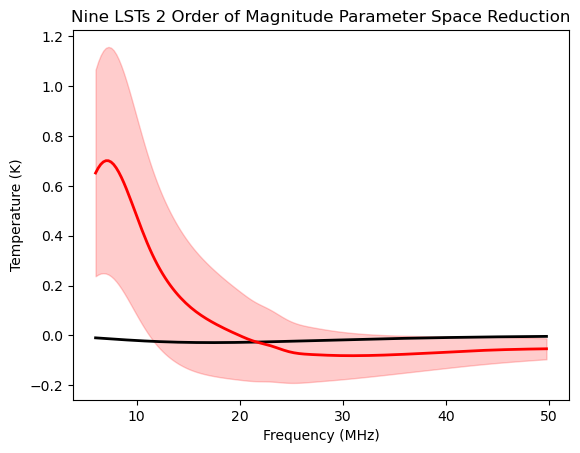

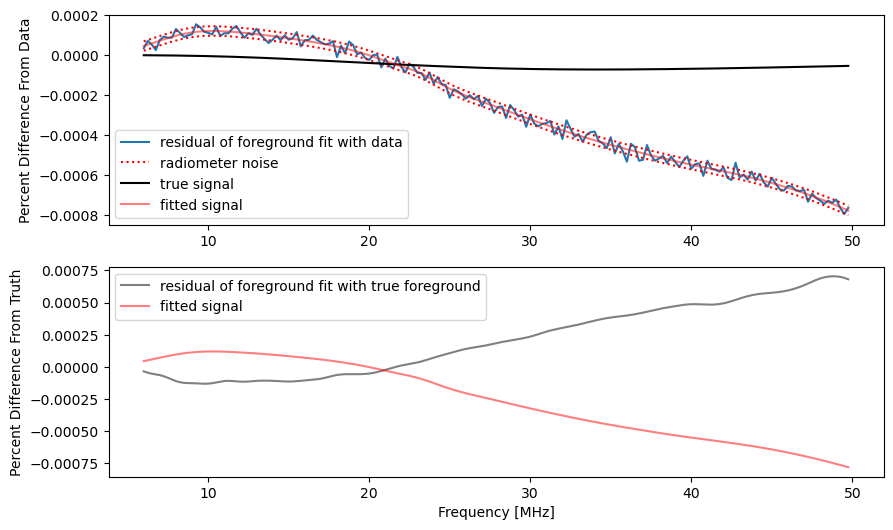

In [ ]:
### 9 LSTs ###

## Creates a training set with varied foreground and beams for all 4 different foregrounds:

custom_parameter_range = np.array([[0.975,1.025],[3.39,3.41],[4.59,4.69]])  # For making a random foreground
parameter_variation = [0.0005,0.00025,0.0005]                           # For making a random foreground                        # For making a random foreground
# custom_parameter_range = np.array([[1,1],[3.4,3.4],[4.6,4.6]])
# custom_parameter_range = np.array([[1,1.1],[3.4,3.5],[4.6,4.7]])
# custom_parameter_range = np.array([[0.995,1.005],[3.3997,3.40027],[4.598,4.60128]])
# parameter_variation = [0.0002,0.0001,0.0002]
# parameter_variation = [0,0,0]
## Interpolate the varied beams to match the rest of the data
varied_regolith_training_set = np.zeros((len(varied_regolith_training_set_raw),len(frequencies)))
for n in range(len(varied_regolith_training_set_raw)):
    beam_regolith_interp = scipy.interpolate.CubicSpline(range(1,51),varied_regolith_training_set_raw[n,0,:])
    varied_regolith_training_set[n] = beam_regolith_interp(frequencies)
 # number of beams in the beam training set
exp_test=py21cmsig.expanded_training_set_no_t(varied_regolith_training_set,varied_regolith_training_set_raw_params,Nb,\
                               custom_parameter_range,show_parameter_ranges=True)


n_regions = 5
reference_frequency = 25
sky_map = foreground_array_minCMB[0]
BTS_curves = exp_test[0]
BTS_params = exp_test[1]
beam_sky_training_set = beams[:,5:,:]
beam_sky_training_set_params = varied_regolith_training_set_raw_params
raw_beam_weighted_sky_maps = raw_sky_maps

# parameter_variation = [0.05,0.025,0.05]
determine_parameter_range = True
new_FG_parameter_mean = None
foreground_run_set_1 = py21cmsig.synchrotron_foreground_forsigex(n_regions,frequencies,reference_frequency,sky_map,BTS_curves,BTS_params,\
                                    beam_sky_training_set,beam_sky_training_set_params,N,parameter_variation,B_value_functions, \
                                        define_parameter_mean=False,parameter_mean=new_FG_parameter_mean)
rms_values = py21cmsig.narrowed_training_set(simulation_test_beam_1[0],rms_mean,rms_std,foreground_run_set_1[3],foreground_run_set_1[4])[2]
new_parameter_mean = np.zeros((n_regions,3))
fg_range_array = np.zeros((n_regions,6))
foreground_parameter_variation = np.array(parameter_variation)

## Foreground 2

## Creates a training set with varied foreground and beams:

## Interpolate the varied beams to match the rest of the data
varied_regolith_training_set_2 = np.zeros((len(varied_regolith_training_set_raw_2),len(frequencies)))
for n in range(len(varied_regolith_training_set_raw_2)):
    beam_regolith_interp = scipy.interpolate.CubicSpline(range(1,51),varied_regolith_training_set_raw_2[n,0,:])
    varied_regolith_training_set[n] = beam_regolith_interp(frequencies)
 # number of beams in the beam training set
exp_test=py21cmsig.expanded_training_set_no_t(varied_regolith_training_set,varied_regolith_training_set_raw_params,Nb,\
                               custom_parameter_range,show_parameter_ranges=True)
n_regions = 5
reference_frequency = 25
sky_map = foreground_array_minCMB_2[0]
BTS_curves = exp_test[0]
BTS_params = exp_test[1]
beam_sky_training_set = beams[:,5:,:]
beam_sky_training_set_params = varied_regolith_training_set_raw_params
raw_beam_weighted_sky_maps = raw_sky_maps

# parameter_variation = [0.05,0.025,0.05]
determine_parameter_range = True
new_FG_parameter_mean = None
foreground_run_set_2 = py21cmsig.synchrotron_foreground_forsigex(n_regions,frequencies,reference_frequency,sky_map,BTS_curves,BTS_params,\
                                    beam_sky_training_set,beam_sky_training_set_params,N,parameter_variation, B_value_functions,\
                                        define_parameter_mean=False,parameter_mean=new_FG_parameter_mean)
rms_values = py21cmsig.narrowed_training_set(simulation_test_beam_2[0],rms_mean,rms_std,foreground_run_set_2[3],foreground_run_set_2[4])[2]
new_parameter_mean = np.zeros((n_regions,3))
fg_range_array = np.zeros((n_regions,6))
foreground_parameter_variation = np.array(parameter_variation)

## Foreground 3

## Creates a training set with varied foreground and beams:


## Interpolate the varied beams to match the rest of the data
varied_regolith_training_set_3 = np.zeros((len(varied_regolith_training_set_raw_3),len(frequencies)))
for n in range(len(varied_regolith_training_set_raw_3)):
    beam_regolith_interp = scipy.interpolate.CubicSpline(range(1,51),varied_regolith_training_set_raw_3[n,0,:])
    varied_regolith_training_set[n] = beam_regolith_interp(frequencies)
 # number of beams in the beam training set
exp_test=py21cmsig.expanded_training_set_no_t(varied_regolith_training_set,varied_regolith_training_set_raw_params,Nb,\
                               custom_parameter_range,show_parameter_ranges=True)
n_regions = 5
reference_frequency = 25
sky_map = foreground_array_minCMB_3[0]
BTS_curves = exp_test[0]
BTS_params = exp_test[1]
beam_sky_training_set = beams[:,5:,:]
beam_sky_training_set_params = varied_regolith_training_set_raw_params
raw_beam_weighted_sky_maps = raw_sky_maps

# parameter_variation = [0.05,0.025,0.05]
determine_parameter_range = True
new_FG_parameter_mean = None
foreground_run_set_3 = py21cmsig.synchrotron_foreground_forsigex(n_regions,frequencies,reference_frequency,sky_map,BTS_curves,BTS_params,\
                                    beam_sky_training_set,beam_sky_training_set_params,N,parameter_variation, B_value_functions,\
                                        define_parameter_mean=False,parameter_mean=new_FG_parameter_mean)
rms_values = py21cmsig.narrowed_training_set(simulation_test_beam_3[0],rms_mean,rms_std,foreground_run_set_3[3],foreground_run_set_3[4])[2]
new_parameter_mean = np.zeros((n_regions,3))
fg_range_array = np.zeros((n_regions,6))
foreground_parameter_variation = np.array(parameter_variation)

## Foreground 4

## Creates a training set with varied foreground and beams:


## Interpolate the varied beams to match the rest of the data
varied_regolith_training_set_4 = np.zeros((len(varied_regolith_training_set_raw_4),len(frequencies)))
for n in range(len(varied_regolith_training_set_raw_4)):
    beam_regolith_interp = scipy.interpolate.CubicSpline(range(1,51),varied_regolith_training_set_raw_4[n,0,:])
    varied_regolith_training_set[n] = beam_regolith_interp(frequencies)
 # number of beams in the beam training set
exp_test=py21cmsig.expanded_training_set_no_t(varied_regolith_training_set,varied_regolith_training_set_raw_params,Nb,\
                               custom_parameter_range,show_parameter_ranges=True)
n_regions = 5
reference_frequency = 25
sky_map = foreground_array_minCMB_4[0]
BTS_curves = exp_test[0]
BTS_params = exp_test[1]
beam_sky_training_set = beams[:,5:,:]
beam_sky_training_set_params = varied_regolith_training_set_raw_params
raw_beam_weighted_sky_maps = raw_sky_maps


determine_parameter_range = True
new_FG_parameter_mean = None
foreground_run_set_4 = py21cmsig.synchrotron_foreground_forsigex(n_regions,frequencies,reference_frequency,sky_map,BTS_curves,BTS_params,\
                                    beam_sky_training_set,beam_sky_training_set_params,N,parameter_variation,B_value_functions, \
                                        define_parameter_mean=False,parameter_mean=new_FG_parameter_mean)
rms_values =py21cmsig.narrowed_training_set(simulation_test_beam_4[0],rms_mean,rms_std,foreground_run_set_4[3],foreground_run_set_4[4])[2]
new_parameter_mean = np.zeros((n_regions,3))
fg_range_array = np.zeros((n_regions,6))
foreground_parameter_variation = np.array(parameter_variation)

## Foreground 5

## Creates a training set with varied foreground and beams:


## Interpolate the varied beams to match the rest of the data
varied_regolith_training_set_5 = np.zeros((len(varied_regolith_training_set_raw_5),len(frequencies)))
for n in range(len(varied_regolith_training_set_raw_5)):
    beam_regolith_interp = scipy.interpolate.CubicSpline(range(1,51),varied_regolith_training_set_raw_5[n,0,:])
    varied_regolith_training_set[n] = beam_regolith_interp(frequencies)
 # number of beams in the beam training set
exp_test=py21cmsig.expanded_training_set_no_t(varied_regolith_training_set,varied_regolith_training_set_raw_params,Nb,\
                               custom_parameter_range,show_parameter_ranges=True)
n_regions = 5
reference_frequency = 25
sky_map = foreground_array_minCMB_5[0]
BTS_curves = exp_test[0]
BTS_params = exp_test[1]
beam_sky_training_set = beams[:,5:,:]
beam_sky_training_set_params = varied_regolith_training_set_raw_params
raw_beam_weighted_sky_maps = raw_sky_maps


determine_parameter_range = True
new_FG_parameter_mean = None
foreground_run_set_5 = py21cmsig.synchrotron_foreground_forsigex(n_regions,frequencies,reference_frequency,sky_map,BTS_curves,BTS_params,\
                                    beam_sky_training_set,beam_sky_training_set_params,N,parameter_variation,B_value_functions, \
                                        define_parameter_mean=False,parameter_mean=new_FG_parameter_mean)
rms_values = py21cmsig.narrowed_training_set(simulation_test_beam_5[0],rms_mean,rms_std,foreground_run_set_5[3],foreground_run_set_5[4])[2]
new_parameter_mean = np.zeros((n_regions,3))
fg_range_array = np.zeros((n_regions,6))
foreground_parameter_variation = np.array(parameter_variation)

## Foreground 6

## Creates a training set with varied foreground and beams:


## Interpolate the varied beams to match the rest of the data
varied_regolith_training_set_6 = np.zeros((len(varied_regolith_training_set_raw_6),len(frequencies)))
for n in range(len(varied_regolith_training_set_raw_6)):
    beam_regolith_interp = scipy.interpolate.CubicSpline(range(1,51),varied_regolith_training_set_raw_6[n,0,:])
    varied_regolith_training_set[n] = beam_regolith_interp(frequencies)
 # number of beams in the beam training set
exp_test=py21cmsig.expanded_training_set_no_t(varied_regolith_training_set,varied_regolith_training_set_raw_params,Nb,\
                               custom_parameter_range,show_parameter_ranges=True)
n_regions = 5
reference_frequency = 25
sky_map = foreground_array_minCMB_6[0]
BTS_curves = exp_test[0]
BTS_params = exp_test[1]
beam_sky_training_set = beams[:,5:,:]
beam_sky_training_set_params = varied_regolith_training_set_raw_params
raw_beam_weighted_sky_maps = raw_sky_maps


determine_parameter_range = True
new_FG_parameter_mean = None
foreground_run_set_6 = py21cmsig.synchrotron_foreground_forsigex(n_regions,frequencies,reference_frequency,sky_map,BTS_curves,BTS_params,\
                                    beam_sky_training_set,beam_sky_training_set_params,N,parameter_variation,B_value_functions, \
                                        define_parameter_mean=False,parameter_mean=new_FG_parameter_mean)
rms_values = py21cmsig.narrowed_training_set(simulation_test_beam_6[0],rms_mean,rms_std,foreground_run_set_6[3],foreground_run_set_6[4])[2]
new_parameter_mean = np.zeros((n_regions,3))
fg_range_array = np.zeros((n_regions,6))
foreground_parameter_variation = np.array(parameter_variation)

## Foreground 7

## Creates a training set with varied foreground and beams:


## Interpolate the varied beams to match the rest of the data
varied_regolith_training_set_7 = np.zeros((len(varied_regolith_training_set_raw_7),len(frequencies)))
for n in range(len(varied_regolith_training_set_raw_7)):
    beam_regolith_interp = scipy.interpolate.CubicSpline(range(1,51),varied_regolith_training_set_raw_7[n,0,:])
    varied_regolith_training_set[n] = beam_regolith_interp(frequencies)
 # number of beams in the beam training set
exp_test=py21cmsig.expanded_training_set_no_t(varied_regolith_training_set,varied_regolith_training_set_raw_params,Nb,\
                               custom_parameter_range,show_parameter_ranges=True)
n_regions = 5
reference_frequency = 25
sky_map = foreground_array_minCMB_7[0]
BTS_curves = exp_test[0]
BTS_params = exp_test[1]
beam_sky_training_set = beams[:,5:,:]
beam_sky_training_set_params = varied_regolith_training_set_raw_params
raw_beam_weighted_sky_maps = raw_sky_maps


determine_parameter_range = True
new_FG_parameter_mean = None
foreground_run_set_7 = py21cmsig.synchrotron_foreground_forsigex(n_regions,frequencies,reference_frequency,sky_map,BTS_curves,BTS_params,\
                                    beam_sky_training_set,beam_sky_training_set_params,N,parameter_variation, B_value_functions,\
                                        define_parameter_mean=False,parameter_mean=new_FG_parameter_mean)
rms_values = py21cmsig.narrowed_training_set(simulation_test_beam_7[0],rms_mean,rms_std,foreground_run_set_7[3],foreground_run_set_7[4])[2]
new_parameter_mean = np.zeros((n_regions,3))
fg_range_array = np.zeros((n_regions,6))
foreground_parameter_variation = np.array(parameter_variation)

## Foreground 8

## Creates a training set with varied foreground and beams:


## Interpolate the varied beams to match the rest of the data
varied_regolith_training_set_8 = np.zeros((len(varied_regolith_training_set_raw_8),len(frequencies)))
for n in range(len(varied_regolith_training_set_raw_8)):
    beam_regolith_interp = scipy.interpolate.CubicSpline(range(1,51),varied_regolith_training_set_raw_8[n,0,:])
    varied_regolith_training_set[n] = beam_regolith_interp(frequencies)
 # number of beams in the beam training set
exp_test=py21cmsig.expanded_training_set_no_t(varied_regolith_training_set,varied_regolith_training_set_raw_params,Nb,\
                               custom_parameter_range,show_parameter_ranges=True)
n_regions = 5
reference_frequency = 25
sky_map = foreground_array_minCMB_8[0]
BTS_curves = exp_test[0]
BTS_params = exp_test[1]
beam_sky_training_set = beams[:,5:,:]
beam_sky_training_set_params = varied_regolith_training_set_raw_params
raw_beam_weighted_sky_maps = raw_sky_maps


determine_parameter_range = True
new_FG_parameter_mean = None
foreground_run_set_8 = py21cmsig.synchrotron_foreground_forsigex(n_regions,frequencies,reference_frequency,sky_map,BTS_curves,BTS_params,\
                                    beam_sky_training_set,beam_sky_training_set_params,N,parameter_variation,B_value_functions, \
                                        define_parameter_mean=False,parameter_mean=new_FG_parameter_mean)
rms_values = py21cmsig.narrowed_training_set(simulation_test_beam_8[0],rms_mean,rms_std,foreground_run_set_8[3],foreground_run_set_8[4])[2]
new_parameter_mean = np.zeros((n_regions,3))
fg_range_array = np.zeros((n_regions,6))
foreground_parameter_variation = np.array(parameter_variation)

## Foreground 9

## Creates a training set with varied foreground and beams:


## Interpolate the varied beams to match the rest of the data
varied_regolith_training_set_9 = np.zeros((len(varied_regolith_training_set_raw_9),len(frequencies)))
for n in range(len(varied_regolith_training_set_raw_9)):
    beam_regolith_interp = scipy.interpolate.CubicSpline(range(1,51),varied_regolith_training_set_raw_9[n,0,:])
    varied_regolith_training_set[n] = beam_regolith_interp(frequencies)
 # number of beams in the beam training set
exp_test=py21cmsig.expanded_training_set_no_t(varied_regolith_training_set,varied_regolith_training_set_raw_params,Nb,\
                               custom_parameter_range,show_parameter_ranges=True)
n_regions = 5
reference_frequency = 25
sky_map = foreground_array_minCMB_9[0]
BTS_curves = exp_test[0]
BTS_params = exp_test[1]
beam_sky_training_set = beams[:,5:,:]
beam_sky_training_set_params = varied_regolith_training_set_raw_params
raw_beam_weighted_sky_maps = raw_sky_maps


determine_parameter_range = True
new_FG_parameter_mean = None
foreground_run_set_9 = py21cmsig.synchrotron_foreground_forsigex(n_regions,frequencies,reference_frequency,sky_map,BTS_curves,BTS_params,\
                                    beam_sky_training_set,beam_sky_training_set_params,N,parameter_variation, B_value_functions,\
                                        define_parameter_mean=False,parameter_mean=new_FG_parameter_mean)
rms_values = py21cmsig.narrowed_training_set(simulation_test_beam_9[0],rms_mean,rms_std,foreground_run_set_9[3],foreground_run_set_9[4])[2]
new_parameter_mean = np.zeros((n_regions,3))
fg_range_array = np.zeros((n_regions,6))
foreground_parameter_variation = np.array(parameter_variation)

### Combine them all
foreground_run_combined_9 = np.zeros((Nb*N,9,len(frequencies)))
foreground_run_combined_9[:,0,:] = foreground_run_set_1[3]
foreground_run_combined_9[:,1,:] = foreground_run_set_2[3]
foreground_run_combined_9[:,2,:] = foreground_run_set_3[3]
foreground_run_combined_9[:,3,:] = foreground_run_set_4[3]
foreground_run_combined_9[:,4,:] = foreground_run_set_5[3]
foreground_run_combined_9[:,5,:] = foreground_run_set_6[3]
foreground_run_combined_9[:,6,:] = foreground_run_set_7[3]
foreground_run_combined_9[:,7,:] = foreground_run_set_8[3]
foreground_run_combined_9[:,8,:] = foreground_run_set_9[3]
# foreground_run_combined = np.concatenate((foreground_run_set_1[3],foreground_run_set_2[3],foreground_run_set_3[3],foreground_run_set_4[3]),axis=0)

# #Let's first start by combining the two arrays for the two separate signals:
fg_training_set = copy.deepcopy(foreground_run_combined_9)
flattened_foreground_training_set = np.reshape(fg_training_set, (len(fg_training_set), -1))
signal_training_set_4LST = copy.deepcopy(DMAN_training_set[0])

total_signal = np.zeros((9,len(frequencies)))
total_signal[0,:] = simulation_test_beam_1[0]
total_signal[1,:] = simulation_test_beam_2[0]
total_signal[2,:] = simulation_test_beam_3[0]
total_signal[3,:] = simulation_test_beam_4[0]
total_signal[4,:] = simulation_test_beam_5[0]
total_signal[5,:] = simulation_test_beam_6[0]
total_signal[6,:] = simulation_test_beam_7[0]
total_signal[7,:] = simulation_test_beam_8[0]
total_signal[8,:] = simulation_test_beam_9[0]

total_noise = np.zeros((9,len(frequencies)))
noise_level_1 = sigT(simulation_test_beam_1[0],dnu,dt)
noise_level_2 = sigT(simulation_test_beam_2[0],dnu,dt)
noise_level_3 = sigT(simulation_test_beam_3[0],dnu,dt)
noise_level_4 = sigT(simulation_test_beam_4[0],dnu,dt)
noise_level_5 = sigT(simulation_test_beam_5[0],dnu,dt)
noise_level_6 = sigT(simulation_test_beam_6[0],dnu,dt)
noise_level_7 = sigT(simulation_test_beam_7[0],dnu,dt)
noise_level_8 = sigT(simulation_test_beam_8[0],dnu,dt)
noise_level_9 = sigT(simulation_test_beam_9[0],dnu,dt)
total_noise[0,:] = noise_level_1
total_noise[1,:] = noise_level_2
total_noise[2,:] = noise_level_3
total_noise[3,:] = noise_level_4
total_noise[4,:] = noise_level_5
total_noise[5,:] = noise_level_6
total_noise[6,:] = noise_level_7
total_noise[7,:] = noise_level_8
total_noise[8,:] = noise_level_9



# pylinex requires 1D arrays, so let's flatten the noise_level and temperatures matrices (i.e. collapse the spectra)
temperatures_flat = total_signal.flatten()
noise_level_flat = total_noise.flatten()

# same as in Problem 3, let's use PowerLawTimesLogPolynomialModel for the foreground and a Gaussian for the signal


# across the 8 spectra, the signal is the same, but the foreground changes
# so, we have to make a different basis vector for each of the foreground spectra, but one basis for the sinal
names = ['foreground','signal']

                  # to transform the basis vectors from one space to another (e.g. into the data space), we use the Expander objects. 
                  # for the foreground, we will use PadExpander, which pads each foreground basis vector with zeros for the other spectra
                  # for the signal, we will use RepeatExpander, which expands vectors by repeating them multiple times
                  # (i.e. the signal is constant over the 8 pointings)

bases = [TrainedBasis(flattened_foreground_training_set,num_basis_vectors=600, expander=NullExpander()),\
TrainedBasis(signal_training_set_4LST,num_basis_vectors=40, expander=RepeatExpander(9))]
bases[0].generate_gaussian_prior()
bases[1].generate_gaussian_prior()

# define BasisSum object for pylinex's Fitter class 
# again using multiple bases, 8 for the foreground and one for the signal Gaussian
basis_sum = BasisSum(names, bases)

# same as in Problems 2 and 3,
# we optimize the number of terms by minimizing the Bayesian predictive information criterion (BPIC)
quantity = AttributeQuantity(IC)

# now set the number of terms to search numerically to minimize the BPIC
# choosing between 1 and 10 terms for each of the foregrounds, and 1 term for the signal
# placing the foreground spectra in the same dictionary,
# so that MetaFitter knows each will use the same number of terms (decreasing number of fits to perform)
dimension = [{"foreground": np.arange(1,600)},
{'signal': np.arange(1,30)}]

# now use MetaFitter to perform fits over the grid and choose the optimal fit based on minimizing the BPIC
# priors = {"signal_prior" : bases[1].gaussian_prior}
meta_fitter = MetaFitter(basis_sum, temperatures_flat, noise_level_flat, quantity,\
quantity.name, *dimension)

# grab the Fitter object that corresponds to the fit that minimized the BPIC statistic
fitter_9 = meta_fitter.fitter_from_indices(meta_fitter.minimize_quantity(IC))
num_foreground_terms = fitter_9.sizes['foreground']
num_signal_terms = fitter_9.sizes["signal"]
print(f'The MetaFitter chose %i foreground terms based on {IC} minimization.' % num_foreground_terms)
print(f'The MetaFitter chose %i signal terms based on {IC} minimization.' % num_signal_terms)
print(f"{fitter_9.subbasis_channel_mean("signal").min()} Temperature of lowest point of the trough ")
print(f"{fitter_9.subbasis_channel_error("signal")[np.where(fitter_9.subbasis_channel_mean("signal")==fitter_9.subbasis_channel_mean("signal").min())][0]} Channel error at lowest point of the trough ")
print(f"{fitter_9.log_evidence} log evidence")
print(f"{fitter_9.chi_squared} Chi Squared")
print(f"{fitter_9.psi_squared} Psi Squared")
pearsonr=scipy.stats.pearsonr(fitter_9.subbasis_channel_mean("signal")/simulation_test_beam_1[2],(fitter_9.subbasis_channel_mean("foreground")[0:len(frequencies)]-simulation_test_beam_1[2])/simulation_test_beam_1[2])
print(f"True {pearsonr}")
fitter_9.plot_subbasis_fit(nsigma=1, name='signal', x_values=frequencies,\
colors='r', xlabel='Frequency (MHz)', ylabel='Temperature (K)',\
title='Nine LSTs 2 Order of Magnitude Parameter Space Reduction', show=True,true_curve = simulation_test_beam_1[1])


fig, (ax1, ax2) = plt.subplots(2,1,figsize=(10, 6))
plt.subplot(2,1,1)
plt.plot(frequencies,(simulation_test_beam_1[0]-fitter_9.subbasis_channel_mean("foreground")[0:len(frequencies)])/simulation_test_beam_1[0]*100,label="residual of foreground fit with data")
plt.plot(frequencies,(fitter_9.subbasis_channel_mean("signal")+sigT(simulation_test_beam_1[0],dnu,dt))/simulation_test_beam_1[0]*100,color="red",ls=":" ,label="radiometer noise")
plt.plot(frequencies,(fitter_9.subbasis_channel_mean("signal")-sigT(simulation_test_beam_1[0],dnu,dt))/simulation_test_beam_1[0]*100,color="red", ls=":")
plt.plot(frequencies,simulation_test_beam_1[1]/simulation_test_beam_1[0]*100,label="true signal",c="black")
plt.plot(frequencies,fitter_9.subbasis_channel_mean("signal")/simulation_test_beam_1[0]*100,label="fitted signal",alpha=0.5,c='red')
plt.ylabel("Percent Difference From Data")

plt.legend()

# Plots a handy plot of the true foreground residual from the simulation minus the foreground fit compared to the signal fit
# Good for identifying degeneracy by eye (pearson r is quantifying this)
plt.subplot(2,1,2)
plt.title("")
plt.plot(frequencies,((fitter_9.subbasis_channel_mean("foreground")[0:len(frequencies)]-simulation_test_beam_1[2]))/simulation_test_beam_1[2]*100,c="grey",label="residual of foreground fit with true foreground")
plt.plot(frequencies,fitter_9.subbasis_channel_mean("signal")/simulation_test_beam_1[2]*100,c="red",alpha=0.5,label="fitted signal")
plt.xlabel("Frequency [MHz]")
plt.ylabel("Percent Difference From Truth")
plt.legend()

100%|██████████| 176/176 [00:01<00:00, 169.80it/s]


[[0.9975 1.0025]
 [3.399  3.401 ]
 [4.599  4.609 ]]


100%|██████████| 500/500 [00:02<00:00, 225.94it/s]


[5e-05, 2.5e-05, 5e-05]


100%|██████████| 176/176 [00:00<00:00, 181.60it/s]


[[0.9975 1.0025]
 [3.399  3.401 ]
 [4.599  4.609 ]]


100%|██████████| 500/500 [00:02<00:00, 241.50it/s]


[5e-05, 2.5e-05, 5e-05]


100%|██████████| 176/176 [00:00<00:00, 176.87it/s]


[[0.9975 1.0025]
 [3.399  3.401 ]
 [4.599  4.609 ]]


100%|██████████| 500/500 [00:02<00:00, 242.31it/s]


[5e-05, 2.5e-05, 5e-05]


100%|██████████| 176/176 [00:00<00:00, 180.23it/s]


[[0.9975 1.0025]
 [3.399  3.401 ]
 [4.599  4.609 ]]


100%|██████████| 500/500 [00:02<00:00, 167.87it/s]


[5e-05, 2.5e-05, 5e-05]


100%|██████████| 176/176 [00:01<00:00, 175.17it/s]


[[0.9975 1.0025]
 [3.399  3.401 ]
 [4.599  4.609 ]]


100%|██████████| 500/500 [00:02<00:00, 214.70it/s]


[5e-05, 2.5e-05, 5e-05]


100%|██████████| 176/176 [00:00<00:00, 185.80it/s]


[[0.9975 1.0025]
 [3.399  3.401 ]
 [4.599  4.609 ]]


100%|██████████| 500/500 [00:02<00:00, 238.71it/s]


[5e-05, 2.5e-05, 5e-05]


100%|██████████| 176/176 [00:00<00:00, 186.84it/s]


[[0.9975 1.0025]
 [3.399  3.401 ]
 [4.599  4.609 ]]


100%|██████████| 500/500 [00:02<00:00, 243.36it/s]


[5e-05, 2.5e-05, 5e-05]


100%|██████████| 176/176 [00:00<00:00, 184.30it/s]


[[0.9975 1.0025]
 [3.399  3.401 ]
 [4.599  4.609 ]]


100%|██████████| 500/500 [00:02<00:00, 232.72it/s]


[5e-05, 2.5e-05, 5e-05]


100%|██████████| 176/176 [00:01<00:00, 173.76it/s]


[[0.9975 1.0025]
 [3.399  3.401 ]
 [4.599  4.609 ]]


100%|██████████| 500/500 [00:02<00:00, 233.04it/s]


[5e-05, 2.5e-05, 5e-05]


100%|██████████| 250000/250000 [00:01<00:00, 214869.71it/s]


Minimizing BPIC over grid.
The MetaFitter chose 164 foreground terms based on BPIC minimization.
The MetaFitter chose 1 signal terms based on BPIC minimization.
-0.039297338743303475 Temperature of lowest point of the trough 
0.01880704420904193 Channel error at lowest point of the trough 
-84575.64967927738 log evidence
1381.636028406521 Chi Squared
0.8388316871356022 Psi Squared
True PearsonRResult(statistic=-0.6696525746937553, pvalue=2.959032658496955e-24)


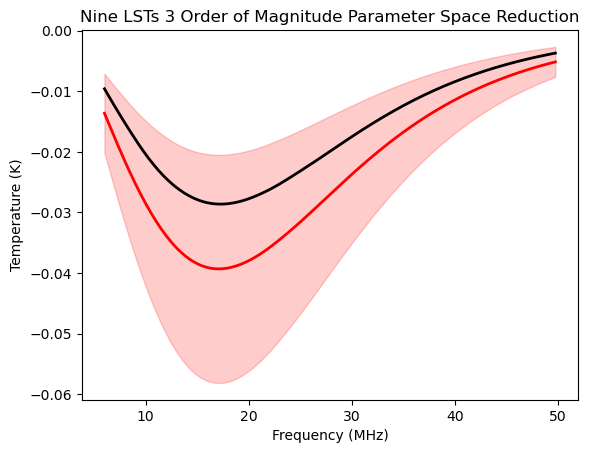

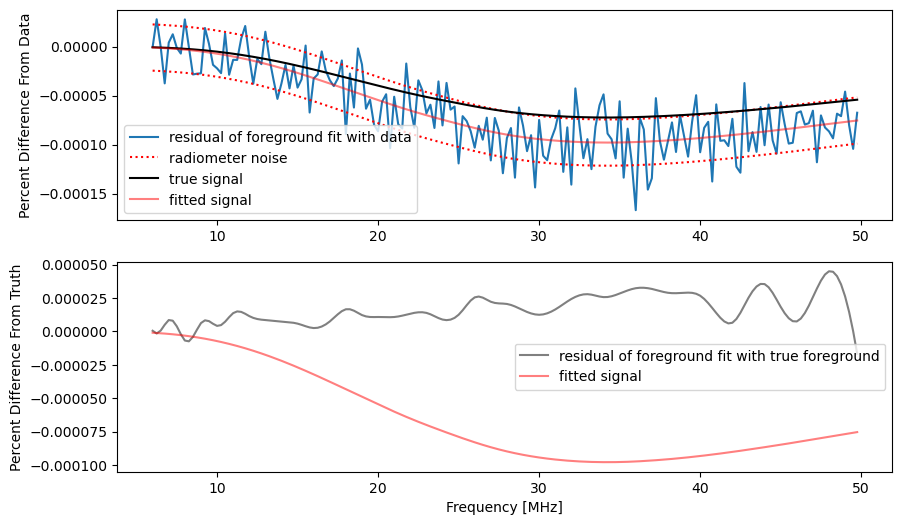

In [ ]:
### 9 LSTs ###

## Creates a training set with varied foreground and beams for all 4 different foregrounds:

custom_parameter_range = np.array([[0.9975,1.0025],[3.399,3.401],[4.599,4.609]])  # For making a random foreground
parameter_variation = [0.00005,0.000025,0.00005]                            # For making a random foreground
# custom_parameter_range = np.array([[1,1],[3.4,3.4],[4.6,4.6]])
# custom_parameter_range = np.array([[1,1.1],[3.4,3.5],[4.6,4.7]])
# custom_parameter_range = np.array([[0.995,1.005],[3.3997,3.40027],[4.598,4.60128]])
# parameter_variation = [0.0002,0.0001,0.0002]
# parameter_variation = [0,0,0]
## Interpolate the varied beams to match the rest of the data
varied_regolith_training_set = np.zeros((len(varied_regolith_training_set_raw),len(frequencies)))
for n in range(len(varied_regolith_training_set_raw)):
    beam_regolith_interp = scipy.interpolate.CubicSpline(range(1,51),varied_regolith_training_set_raw[n,0,:])
    varied_regolith_training_set[n] = beam_regolith_interp(frequencies)
 # number of beams in the beam training set
exp_test=py21cmsig.expanded_training_set_no_t(varied_regolith_training_set,varied_regolith_training_set_raw_params,Nb,\
                               custom_parameter_range,show_parameter_ranges=True)


n_regions = 5
reference_frequency = 25
sky_map = foreground_array_minCMB[0]
BTS_curves = exp_test[0]
BTS_params = exp_test[1]
beam_sky_training_set = beams[:,5:,:]
beam_sky_training_set_params = varied_regolith_training_set_raw_params
raw_beam_weighted_sky_maps = raw_sky_maps

# parameter_variation = [0.05,0.025,0.05]
determine_parameter_range = True
new_FG_parameter_mean = None
foreground_run_set_1 = py21cmsig.synchrotron_foreground_forsigex(n_regions,frequencies,reference_frequency,sky_map,BTS_curves,BTS_params,\
                                    beam_sky_training_set,beam_sky_training_set_params,N,parameter_variation,B_value_functions, \
                                        define_parameter_mean=False,parameter_mean=new_FG_parameter_mean)
rms_values = py21cmsig.narrowed_training_set(simulation_test_beam_1[0],rms_mean,rms_std,foreground_run_set_1[3],foreground_run_set_1[4])[2]
new_parameter_mean = np.zeros((n_regions,3))
fg_range_array = np.zeros((n_regions,6))
foreground_parameter_variation = np.array(parameter_variation)

## Foreground 2

## Creates a training set with varied foreground and beams:

## Interpolate the varied beams to match the rest of the data
varied_regolith_training_set_2 = np.zeros((len(varied_regolith_training_set_raw_2),len(frequencies)))
for n in range(len(varied_regolith_training_set_raw_2)):
    beam_regolith_interp = scipy.interpolate.CubicSpline(range(1,51),varied_regolith_training_set_raw_2[n,0,:])
    varied_regolith_training_set[n] = beam_regolith_interp(frequencies)
 # number of beams in the beam training set
exp_test=py21cmsig.expanded_training_set_no_t(varied_regolith_training_set,varied_regolith_training_set_raw_params,Nb,\
                               custom_parameter_range,show_parameter_ranges=True)
n_regions = 5
reference_frequency = 25
sky_map = foreground_array_minCMB_2[0]
BTS_curves = exp_test[0]
BTS_params = exp_test[1]
beam_sky_training_set = beams[:,5:,:]
beam_sky_training_set_params = varied_regolith_training_set_raw_params
raw_beam_weighted_sky_maps = raw_sky_maps

# parameter_variation = [0.05,0.025,0.05]
determine_parameter_range = True
new_FG_parameter_mean = None
foreground_run_set_2 = py21cmsig.synchrotron_foreground_forsigex(n_regions,frequencies,reference_frequency,sky_map,BTS_curves,BTS_params,\
                                    beam_sky_training_set,beam_sky_training_set_params,N,parameter_variation, B_value_functions,\
                                        define_parameter_mean=False,parameter_mean=new_FG_parameter_mean)
rms_values = py21cmsig.narrowed_training_set(simulation_test_beam_2[0],rms_mean,rms_std,foreground_run_set_2[3],foreground_run_set_2[4])[2]
new_parameter_mean = np.zeros((n_regions,3))
fg_range_array = np.zeros((n_regions,6))
foreground_parameter_variation = np.array(parameter_variation)

## Foreground 3

## Creates a training set with varied foreground and beams:


## Interpolate the varied beams to match the rest of the data
varied_regolith_training_set_3 = np.zeros((len(varied_regolith_training_set_raw_3),len(frequencies)))
for n in range(len(varied_regolith_training_set_raw_3)):
    beam_regolith_interp = scipy.interpolate.CubicSpline(range(1,51),varied_regolith_training_set_raw_3[n,0,:])
    varied_regolith_training_set[n] = beam_regolith_interp(frequencies)
 # number of beams in the beam training set
exp_test=py21cmsig.expanded_training_set_no_t(varied_regolith_training_set,varied_regolith_training_set_raw_params,Nb,\
                               custom_parameter_range,show_parameter_ranges=True)
n_regions = 5
reference_frequency = 25
sky_map = foreground_array_minCMB_3[0]
BTS_curves = exp_test[0]
BTS_params = exp_test[1]
beam_sky_training_set = beams[:,5:,:]
beam_sky_training_set_params = varied_regolith_training_set_raw_params
raw_beam_weighted_sky_maps = raw_sky_maps

# parameter_variation = [0.05,0.025,0.05]
determine_parameter_range = True
new_FG_parameter_mean = None
foreground_run_set_3 = py21cmsig.synchrotron_foreground_forsigex(n_regions,frequencies,reference_frequency,sky_map,BTS_curves,BTS_params,\
                                    beam_sky_training_set,beam_sky_training_set_params,N,parameter_variation, B_value_functions,\
                                        define_parameter_mean=False,parameter_mean=new_FG_parameter_mean)
rms_values = py21cmsig.narrowed_training_set(simulation_test_beam_3[0],rms_mean,rms_std,foreground_run_set_3[3],foreground_run_set_3[4])[2]
new_parameter_mean = np.zeros((n_regions,3))
fg_range_array = np.zeros((n_regions,6))
foreground_parameter_variation = np.array(parameter_variation)

## Foreground 4

## Creates a training set with varied foreground and beams:


## Interpolate the varied beams to match the rest of the data
varied_regolith_training_set_4 = np.zeros((len(varied_regolith_training_set_raw_4),len(frequencies)))
for n in range(len(varied_regolith_training_set_raw_4)):
    beam_regolith_interp = scipy.interpolate.CubicSpline(range(1,51),varied_regolith_training_set_raw_4[n,0,:])
    varied_regolith_training_set[n] = beam_regolith_interp(frequencies)
 # number of beams in the beam training set
exp_test=py21cmsig.expanded_training_set_no_t(varied_regolith_training_set,varied_regolith_training_set_raw_params,Nb,\
                               custom_parameter_range,show_parameter_ranges=True)
n_regions = 5
reference_frequency = 25
sky_map = foreground_array_minCMB_4[0]
BTS_curves = exp_test[0]
BTS_params = exp_test[1]
beam_sky_training_set = beams[:,5:,:]
beam_sky_training_set_params = varied_regolith_training_set_raw_params
raw_beam_weighted_sky_maps = raw_sky_maps


determine_parameter_range = True
new_FG_parameter_mean = None
foreground_run_set_4 = py21cmsig.synchrotron_foreground_forsigex(n_regions,frequencies,reference_frequency,sky_map,BTS_curves,BTS_params,\
                                    beam_sky_training_set,beam_sky_training_set_params,N,parameter_variation,B_value_functions, \
                                        define_parameter_mean=False,parameter_mean=new_FG_parameter_mean)
rms_values =py21cmsig.narrowed_training_set(simulation_test_beam_4[0],rms_mean,rms_std,foreground_run_set_4[3],foreground_run_set_4[4])[2]
new_parameter_mean = np.zeros((n_regions,3))
fg_range_array = np.zeros((n_regions,6))
foreground_parameter_variation = np.array(parameter_variation)

## Foreground 5

## Creates a training set with varied foreground and beams:


## Interpolate the varied beams to match the rest of the data
varied_regolith_training_set_5 = np.zeros((len(varied_regolith_training_set_raw_5),len(frequencies)))
for n in range(len(varied_regolith_training_set_raw_5)):
    beam_regolith_interp = scipy.interpolate.CubicSpline(range(1,51),varied_regolith_training_set_raw_5[n,0,:])
    varied_regolith_training_set[n] = beam_regolith_interp(frequencies)
 # number of beams in the beam training set
exp_test=py21cmsig.expanded_training_set_no_t(varied_regolith_training_set,varied_regolith_training_set_raw_params,Nb,\
                               custom_parameter_range,show_parameter_ranges=True)
n_regions = 5
reference_frequency = 25
sky_map = foreground_array_minCMB_5[0]
BTS_curves = exp_test[0]
BTS_params = exp_test[1]
beam_sky_training_set = beams[:,5:,:]
beam_sky_training_set_params = varied_regolith_training_set_raw_params
raw_beam_weighted_sky_maps = raw_sky_maps


determine_parameter_range = True
new_FG_parameter_mean = None
foreground_run_set_5 = py21cmsig.synchrotron_foreground_forsigex(n_regions,frequencies,reference_frequency,sky_map,BTS_curves,BTS_params,\
                                    beam_sky_training_set,beam_sky_training_set_params,N,parameter_variation,B_value_functions, \
                                        define_parameter_mean=False,parameter_mean=new_FG_parameter_mean)
rms_values = py21cmsig.narrowed_training_set(simulation_test_beam_5[0],rms_mean,rms_std,foreground_run_set_5[3],foreground_run_set_5[4])[2]
new_parameter_mean = np.zeros((n_regions,3))
fg_range_array = np.zeros((n_regions,6))
foreground_parameter_variation = np.array(parameter_variation)

## Foreground 6

## Creates a training set with varied foreground and beams:


## Interpolate the varied beams to match the rest of the data
varied_regolith_training_set_6 = np.zeros((len(varied_regolith_training_set_raw_6),len(frequencies)))
for n in range(len(varied_regolith_training_set_raw_6)):
    beam_regolith_interp = scipy.interpolate.CubicSpline(range(1,51),varied_regolith_training_set_raw_6[n,0,:])
    varied_regolith_training_set[n] = beam_regolith_interp(frequencies)
 # number of beams in the beam training set
exp_test=py21cmsig.expanded_training_set_no_t(varied_regolith_training_set,varied_regolith_training_set_raw_params,Nb,\
                               custom_parameter_range,show_parameter_ranges=True)
n_regions = 5
reference_frequency = 25
sky_map = foreground_array_minCMB_6[0]
BTS_curves = exp_test[0]
BTS_params = exp_test[1]
beam_sky_training_set = beams[:,5:,:]
beam_sky_training_set_params = varied_regolith_training_set_raw_params
raw_beam_weighted_sky_maps = raw_sky_maps


determine_parameter_range = True
new_FG_parameter_mean = None
foreground_run_set_6 = py21cmsig.synchrotron_foreground_forsigex(n_regions,frequencies,reference_frequency,sky_map,BTS_curves,BTS_params,\
                                    beam_sky_training_set,beam_sky_training_set_params,N,parameter_variation,B_value_functions, \
                                        define_parameter_mean=False,parameter_mean=new_FG_parameter_mean)
rms_values = py21cmsig.narrowed_training_set(simulation_test_beam_6[0],rms_mean,rms_std,foreground_run_set_6[3],foreground_run_set_6[4])[2]
new_parameter_mean = np.zeros((n_regions,3))
fg_range_array = np.zeros((n_regions,6))
foreground_parameter_variation = np.array(parameter_variation)

## Foreground 7

## Creates a training set with varied foreground and beams:


## Interpolate the varied beams to match the rest of the data
varied_regolith_training_set_7 = np.zeros((len(varied_regolith_training_set_raw_7),len(frequencies)))
for n in range(len(varied_regolith_training_set_raw_7)):
    beam_regolith_interp = scipy.interpolate.CubicSpline(range(1,51),varied_regolith_training_set_raw_7[n,0,:])
    varied_regolith_training_set[n] = beam_regolith_interp(frequencies)
 # number of beams in the beam training set
exp_test=py21cmsig.expanded_training_set_no_t(varied_regolith_training_set,varied_regolith_training_set_raw_params,Nb,\
                               custom_parameter_range,show_parameter_ranges=True)
n_regions = 5
reference_frequency = 25
sky_map = foreground_array_minCMB_7[0]
BTS_curves = exp_test[0]
BTS_params = exp_test[1]
beam_sky_training_set = beams[:,5:,:]
beam_sky_training_set_params = varied_regolith_training_set_raw_params
raw_beam_weighted_sky_maps = raw_sky_maps


determine_parameter_range = True
new_FG_parameter_mean = None
foreground_run_set_7 = py21cmsig.synchrotron_foreground_forsigex(n_regions,frequencies,reference_frequency,sky_map,BTS_curves,BTS_params,\
                                    beam_sky_training_set,beam_sky_training_set_params,N,parameter_variation, B_value_functions,\
                                        define_parameter_mean=False,parameter_mean=new_FG_parameter_mean)
rms_values = py21cmsig.narrowed_training_set(simulation_test_beam_7[0],rms_mean,rms_std,foreground_run_set_7[3],foreground_run_set_7[4])[2]
new_parameter_mean = np.zeros((n_regions,3))
fg_range_array = np.zeros((n_regions,6))
foreground_parameter_variation = np.array(parameter_variation)

## Foreground 8

## Creates a training set with varied foreground and beams:


## Interpolate the varied beams to match the rest of the data
varied_regolith_training_set_8 = np.zeros((len(varied_regolith_training_set_raw_8),len(frequencies)))
for n in range(len(varied_regolith_training_set_raw_8)):
    beam_regolith_interp = scipy.interpolate.CubicSpline(range(1,51),varied_regolith_training_set_raw_8[n,0,:])
    varied_regolith_training_set[n] = beam_regolith_interp(frequencies)
 # number of beams in the beam training set
exp_test=py21cmsig.expanded_training_set_no_t(varied_regolith_training_set,varied_regolith_training_set_raw_params,Nb,\
                               custom_parameter_range,show_parameter_ranges=True)
n_regions = 5
reference_frequency = 25
sky_map = foreground_array_minCMB_8[0]
BTS_curves = exp_test[0]
BTS_params = exp_test[1]
beam_sky_training_set = beams[:,5:,:]
beam_sky_training_set_params = varied_regolith_training_set_raw_params
raw_beam_weighted_sky_maps = raw_sky_maps


determine_parameter_range = True
new_FG_parameter_mean = None
foreground_run_set_8 = py21cmsig.synchrotron_foreground_forsigex(n_regions,frequencies,reference_frequency,sky_map,BTS_curves,BTS_params,\
                                    beam_sky_training_set,beam_sky_training_set_params,N,parameter_variation,B_value_functions, \
                                        define_parameter_mean=False,parameter_mean=new_FG_parameter_mean)
rms_values = py21cmsig.narrowed_training_set(simulation_test_beam_8[0],rms_mean,rms_std,foreground_run_set_8[3],foreground_run_set_8[4])[2]
new_parameter_mean = np.zeros((n_regions,3))
fg_range_array = np.zeros((n_regions,6))
foreground_parameter_variation = np.array(parameter_variation)

## Foreground 9

## Creates a training set with varied foreground and beams:


## Interpolate the varied beams to match the rest of the data
varied_regolith_training_set_9 = np.zeros((len(varied_regolith_training_set_raw_9),len(frequencies)))
for n in range(len(varied_regolith_training_set_raw_9)):
    beam_regolith_interp = scipy.interpolate.CubicSpline(range(1,51),varied_regolith_training_set_raw_9[n,0,:])
    varied_regolith_training_set[n] = beam_regolith_interp(frequencies)
 # number of beams in the beam training set
exp_test=py21cmsig.expanded_training_set_no_t(varied_regolith_training_set,varied_regolith_training_set_raw_params,Nb,\
                               custom_parameter_range,show_parameter_ranges=True)
n_regions = 5
reference_frequency = 25
sky_map = foreground_array_minCMB_9[0]
BTS_curves = exp_test[0]
BTS_params = exp_test[1]
beam_sky_training_set = beams[:,5:,:]
beam_sky_training_set_params = varied_regolith_training_set_raw_params
raw_beam_weighted_sky_maps = raw_sky_maps


determine_parameter_range = True
new_FG_parameter_mean = None
foreground_run_set_9 = py21cmsig.synchrotron_foreground_forsigex(n_regions,frequencies,reference_frequency,sky_map,BTS_curves,BTS_params,\
                                    beam_sky_training_set,beam_sky_training_set_params,N,parameter_variation, B_value_functions,\
                                        define_parameter_mean=False,parameter_mean=new_FG_parameter_mean)
rms_values = py21cmsig.narrowed_training_set(simulation_test_beam_9[0],rms_mean,rms_std,foreground_run_set_9[3],foreground_run_set_9[4])[2]
new_parameter_mean = np.zeros((n_regions,3))
fg_range_array = np.zeros((n_regions,6))
foreground_parameter_variation = np.array(parameter_variation)

### Combine them all
foreground_run_combined_9 = np.zeros((Nb*N,9,len(frequencies)))
foreground_run_combined_9[:,0,:] = foreground_run_set_1[3]
foreground_run_combined_9[:,1,:] = foreground_run_set_2[3]
foreground_run_combined_9[:,2,:] = foreground_run_set_3[3]
foreground_run_combined_9[:,3,:] = foreground_run_set_4[3]
foreground_run_combined_9[:,4,:] = foreground_run_set_5[3]
foreground_run_combined_9[:,5,:] = foreground_run_set_6[3]
foreground_run_combined_9[:,6,:] = foreground_run_set_7[3]
foreground_run_combined_9[:,7,:] = foreground_run_set_8[3]
foreground_run_combined_9[:,8,:] = foreground_run_set_9[3]
# foreground_run_combined = np.concatenate((foreground_run_set_1[3],foreground_run_set_2[3],foreground_run_set_3[3],foreground_run_set_4[3]),axis=0)

# #Let's first start by combining the two arrays for the two separate signals:
fg_training_set = copy.deepcopy(foreground_run_combined_9)
flattened_foreground_training_set = np.reshape(fg_training_set, (len(fg_training_set), -1))
signal_training_set_4LST = copy.deepcopy(DMAN_training_set[0])

total_signal = np.zeros((9,len(frequencies)))
total_signal[0,:] = simulation_test_beam_1[0]
total_signal[1,:] = simulation_test_beam_2[0]
total_signal[2,:] = simulation_test_beam_3[0]
total_signal[3,:] = simulation_test_beam_4[0]
total_signal[4,:] = simulation_test_beam_5[0]
total_signal[5,:] = simulation_test_beam_6[0]
total_signal[6,:] = simulation_test_beam_7[0]
total_signal[7,:] = simulation_test_beam_8[0]
total_signal[8,:] = simulation_test_beam_9[0]

total_noise = np.zeros((9,len(frequencies)))
noise_level_1 = sigT(simulation_test_beam_1[0],dnu,dt)
noise_level_2 = sigT(simulation_test_beam_2[0],dnu,dt)
noise_level_3 = sigT(simulation_test_beam_3[0],dnu,dt)
noise_level_4 = sigT(simulation_test_beam_4[0],dnu,dt)
noise_level_5 = sigT(simulation_test_beam_5[0],dnu,dt)
noise_level_6 = sigT(simulation_test_beam_6[0],dnu,dt)
noise_level_7 = sigT(simulation_test_beam_7[0],dnu,dt)
noise_level_8 = sigT(simulation_test_beam_8[0],dnu,dt)
noise_level_9 = sigT(simulation_test_beam_9[0],dnu,dt)
total_noise[0,:] = noise_level_1
total_noise[1,:] = noise_level_2
total_noise[2,:] = noise_level_3
total_noise[3,:] = noise_level_4
total_noise[4,:] = noise_level_5
total_noise[5,:] = noise_level_6
total_noise[6,:] = noise_level_7
total_noise[7,:] = noise_level_8
total_noise[8,:] = noise_level_9




# pylinex requires 1D arrays, so let's flatten the noise_level and temperatures matrices (i.e. collapse the spectra)
temperatures_flat = total_signal.flatten()
noise_level_flat = total_noise.flatten()

# same as in Problem 3, let's use PowerLawTimesLogPolynomialModel for the foreground and a Gaussian for the signal


# across the 8 spectra, the signal is the same, but the foreground changes
# so, we have to make a different basis vector for each of the foreground spectra, but one basis for the sinal
names = ['foreground','signal']

                  # to transform the basis vectors from one space to another (e.g. into the data space), we use the Expander objects. 
                  # for the foreground, we will use PadExpander, which pads each foreground basis vector with zeros for the other spectra
                  # for the signal, we will use RepeatExpander, which expands vectors by repeating them multiple times
                  # (i.e. the signal is constant over the 8 pointings)

bases = [TrainedBasis(flattened_foreground_training_set,num_basis_vectors=600, expander=NullExpander()),\
TrainedBasis(signal_training_set_4LST,num_basis_vectors=40, expander=RepeatExpander(9))]
bases[0].generate_gaussian_prior()
bases[1].generate_gaussian_prior()

# define BasisSum object for pylinex's Fitter class 
# again using multiple bases, 8 for the foreground and one for the signal Gaussian
basis_sum = BasisSum(names, bases)

# same as in Problems 2 and 3,
# we optimize the number of terms by minimizing the Bayesian predictive information criterion (BPIC)
quantity = AttributeQuantity(IC)

# now set the number of terms to search numerically to minimize the BPIC
# choosing between 1 and 10 terms for each of the foregrounds, and 1 term for the signal
# placing the foreground spectra in the same dictionary,
# so that MetaFitter knows each will use the same number of terms (decreasing number of fits to perform)
dimension = [{"foreground": np.arange(1,600)},
{'signal': np.arange(1,30)}]

# now use MetaFitter to perform fits over the grid and choose the optimal fit based on minimizing the BPIC
# priors = {"signal_prior" : bases[1].gaussian_prior}
meta_fitter = MetaFitter(basis_sum, temperatures_flat, noise_level_flat, quantity,\
quantity.name, *dimension)

# grab the Fitter object that corresponds to the fit that minimized the BPIC statistic
fitter_9 = meta_fitter.fitter_from_indices(meta_fitter.minimize_quantity(IC))
num_foreground_terms = fitter_9.sizes['foreground']
num_signal_terms = fitter_9.sizes["signal"]
print(f'The MetaFitter chose %i foreground terms based on {IC} minimization.' % num_foreground_terms)
print(f'The MetaFitter chose %i signal terms based on {IC} minimization.' % num_signal_terms)
print(f"{fitter_9.subbasis_channel_mean("signal").min()} Temperature of lowest point of the trough ")
print(f"{fitter_9.subbasis_channel_error("signal")[np.where(fitter_9.subbasis_channel_mean("signal")==fitter_9.subbasis_channel_mean("signal").min())][0]} Channel error at lowest point of the trough ")
print(f"{fitter_9.log_evidence} log evidence")
print(f"{fitter_9.chi_squared} Chi Squared")
print(f"{fitter_9.psi_squared} Psi Squared")
pearsonr=scipy.stats.pearsonr(fitter_9.subbasis_channel_mean("signal")/simulation_test_beam_1[2],(fitter_9.subbasis_channel_mean("foreground")[0:len(frequencies)]-simulation_test_beam_1[2])/simulation_test_beam_1[2])
print(f"True {pearsonr}")
fitter_9.plot_subbasis_fit(nsigma=1, name='signal', x_values=frequencies,\
colors='r', xlabel='Frequency (MHz)', ylabel='Temperature (K)',\
title='Nine LSTs 3 Order of Magnitude Parameter Space Reduction', show=True,true_curve = simulation_test_beam_1[1])


fig, (ax1, ax2) = plt.subplots(2,1,figsize=(10, 6))
plt.subplot(2,1,1)
plt.plot(frequencies,(simulation_test_beam_1[0]-fitter_9.subbasis_channel_mean("foreground")[0:len(frequencies)])/simulation_test_beam_1[0]*100,label="residual of foreground fit with data")
plt.plot(frequencies,(fitter_9.subbasis_channel_mean("signal")+sigT(simulation_test_beam_1[0],dnu,dt))/simulation_test_beam_1[0]*100,color="red",ls=":" ,label="radiometer noise")
plt.plot(frequencies,(fitter_9.subbasis_channel_mean("signal")-sigT(simulation_test_beam_1[0],dnu,dt))/simulation_test_beam_1[0]*100,color="red", ls=":")
plt.plot(frequencies,simulation_test_beam_1[1]/simulation_test_beam_1[0]*100,label="true signal",c="black")
plt.plot(frequencies,fitter_9.subbasis_channel_mean("signal")/simulation_test_beam_1[0]*100,label="fitted signal",alpha=0.5,c='red')
plt.ylabel("Percent Difference From Data")

plt.legend()

# Plots a handy plot of the true foreground residual from the simulation minus the foreground fit compared to the signal fit
# Good for identifying degeneracy by eye (pearson r is quantifying this)
plt.subplot(2,1,2)
plt.title("")
plt.plot(frequencies,((fitter_9.subbasis_channel_mean("foreground")[0:len(frequencies)]-simulation_test_beam_1[2]))/simulation_test_beam_1[2]*100,c="grey",label="residual of foreground fit with true foreground")
plt.plot(frequencies,fitter_9.subbasis_channel_mean("signal")/simulation_test_beam_1[2]*100,c="red",alpha=0.5,label="fitted signal")
plt.xlabel("Frequency [MHz]")
plt.ylabel("Percent Difference From Truth")
plt.legend()

100%|██████████| 176/176 [00:01<00:00, 170.50it/s]


[[0.99975 1.00025]
 [3.3999  3.4001 ]
 [4.5999  4.6009 ]]


100%|██████████| 500/500 [00:02<00:00, 215.88it/s]


[5e-06, 2.5e-06, 5e-06]


100%|██████████| 176/176 [00:01<00:00, 163.15it/s]


[[0.99975 1.00025]
 [3.3999  3.4001 ]
 [4.5999  4.6009 ]]


100%|██████████| 500/500 [00:02<00:00, 221.64it/s]


[5e-06, 2.5e-06, 5e-06]


100%|██████████| 176/176 [00:00<00:00, 179.30it/s]


[[0.99975 1.00025]
 [3.3999  3.4001 ]
 [4.5999  4.6009 ]]


100%|██████████| 500/500 [00:02<00:00, 232.86it/s]


[5e-06, 2.5e-06, 5e-06]


100%|██████████| 176/176 [00:00<00:00, 179.70it/s]


[[0.99975 1.00025]
 [3.3999  3.4001 ]
 [4.5999  4.6009 ]]


100%|██████████| 500/500 [00:02<00:00, 239.39it/s]


[5e-06, 2.5e-06, 5e-06]


100%|██████████| 176/176 [00:00<00:00, 180.75it/s]


[[0.99975 1.00025]
 [3.3999  3.4001 ]
 [4.5999  4.6009 ]]


100%|██████████| 500/500 [00:02<00:00, 241.79it/s]


[5e-06, 2.5e-06, 5e-06]


100%|██████████| 176/176 [00:00<00:00, 183.26it/s]


[[0.99975 1.00025]
 [3.3999  3.4001 ]
 [4.5999  4.6009 ]]


100%|██████████| 500/500 [00:02<00:00, 227.07it/s]


[5e-06, 2.5e-06, 5e-06]


100%|██████████| 176/176 [00:00<00:00, 186.10it/s]


[[0.99975 1.00025]
 [3.3999  3.4001 ]
 [4.5999  4.6009 ]]


100%|██████████| 500/500 [00:02<00:00, 241.92it/s]


[5e-06, 2.5e-06, 5e-06]


100%|██████████| 176/176 [00:00<00:00, 178.31it/s]


[[0.99975 1.00025]
 [3.3999  3.4001 ]
 [4.5999  4.6009 ]]


100%|██████████| 500/500 [00:02<00:00, 236.26it/s]


[5e-06, 2.5e-06, 5e-06]


100%|██████████| 176/176 [00:00<00:00, 183.57it/s]


[[0.99975 1.00025]
 [3.3999  3.4001 ]
 [4.5999  4.6009 ]]


100%|██████████| 500/500 [00:02<00:00, 241.09it/s]


[5e-06, 2.5e-06, 5e-06]


100%|██████████| 250000/250000 [00:01<00:00, 212093.57it/s]


Minimizing BPIC over grid.
The MetaFitter chose 66 foreground terms based on BPIC minimization.
The MetaFitter chose 1 signal terms based on BPIC minimization.
-0.033634231281641336 Temperature of lowest point of the trough 
0.004231042463355203 Channel error at lowest point of the trough 
304.8462898597042 log evidence
1501.0636068517172 Chi Squared
0.9314598317549799 Psi Squared
True PearsonRResult(statistic=-0.34690662996090166, pvalue=2.3964009645985e-06)


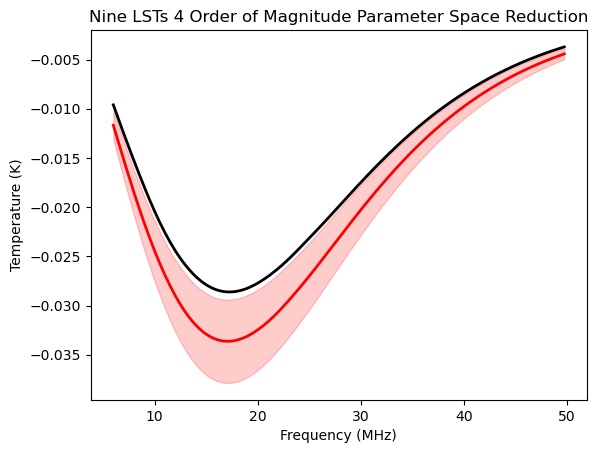

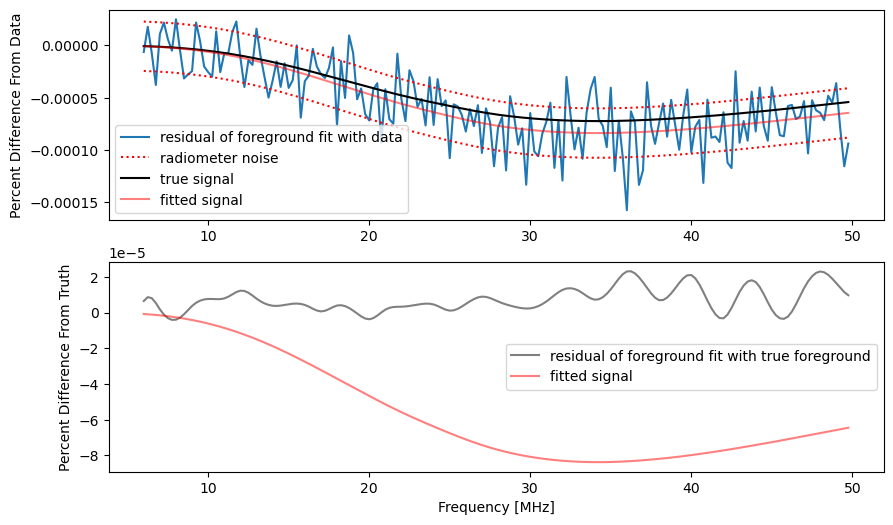

In [ ]:
### 9 LSTs ###

## Creates a training set with varied foreground and beams for all 4 different foregrounds:

custom_parameter_range = np.array([[0.99975,1.00025],[3.3999,3.4001],[4.5999,4.6009]])  # For making a random foreground
parameter_variation = [0.000005,0.0000025,0.000005]                             # For making a random foreground
# custom_parameter_range = np.array([[1,1],[3.4,3.4],[4.6,4.6]])
# custom_parameter_range = np.array([[1,1.1],[3.4,3.5],[4.6,4.7]])
# custom_parameter_range = np.array([[0.995,1.005],[3.3997,3.40027],[4.598,4.60128]])
# parameter_variation = [0.0002,0.0001,0.0002]
# parameter_variation = [0,0,0]
## Interpolate the varied beams to match the rest of the data
varied_regolith_training_set = np.zeros((len(varied_regolith_training_set_raw),len(frequencies)))
for n in range(len(varied_regolith_training_set_raw)):
    beam_regolith_interp = scipy.interpolate.CubicSpline(range(1,51),varied_regolith_training_set_raw[n,0,:])
    varied_regolith_training_set[n] = beam_regolith_interp(frequencies)
 # number of beams in the beam training set
exp_test=py21cmsig.expanded_training_set_no_t(varied_regolith_training_set,varied_regolith_training_set_raw_params,Nb,\
                               custom_parameter_range,show_parameter_ranges=True)


n_regions = 5
reference_frequency = 25
sky_map = foreground_array_minCMB[0]
BTS_curves = exp_test[0]
BTS_params = exp_test[1]
beam_sky_training_set = beams[:,5:,:]
beam_sky_training_set_params = varied_regolith_training_set_raw_params
raw_beam_weighted_sky_maps = raw_sky_maps

# parameter_variation = [0.05,0.025,0.05]
determine_parameter_range = True
new_FG_parameter_mean = None
foreground_run_set_1 = py21cmsig.synchrotron_foreground_forsigex(n_regions,frequencies,reference_frequency,sky_map,BTS_curves,BTS_params,\
                                    beam_sky_training_set,beam_sky_training_set_params,N,parameter_variation,B_value_functions, \
                                        define_parameter_mean=False,parameter_mean=new_FG_parameter_mean)
rms_values = py21cmsig.narrowed_training_set(simulation_test_beam_1[0],rms_mean,rms_std,foreground_run_set_1[3],foreground_run_set_1[4])[2]
new_parameter_mean = np.zeros((n_regions,3))
fg_range_array = np.zeros((n_regions,6))
foreground_parameter_variation = np.array(parameter_variation)

## Foreground 2

## Creates a training set with varied foreground and beams:

## Interpolate the varied beams to match the rest of the data
varied_regolith_training_set_2 = np.zeros((len(varied_regolith_training_set_raw_2),len(frequencies)))
for n in range(len(varied_regolith_training_set_raw_2)):
    beam_regolith_interp = scipy.interpolate.CubicSpline(range(1,51),varied_regolith_training_set_raw_2[n,0,:])
    varied_regolith_training_set[n] = beam_regolith_interp(frequencies)
 # number of beams in the beam training set
exp_test=py21cmsig.expanded_training_set_no_t(varied_regolith_training_set,varied_regolith_training_set_raw_params,Nb,\
                               custom_parameter_range,show_parameter_ranges=True)
n_regions = 5
reference_frequency = 25
sky_map = foreground_array_minCMB_2[0]
BTS_curves = exp_test[0]
BTS_params = exp_test[1]
beam_sky_training_set = beams[:,5:,:]
beam_sky_training_set_params = varied_regolith_training_set_raw_params
raw_beam_weighted_sky_maps = raw_sky_maps

# parameter_variation = [0.05,0.025,0.05]
determine_parameter_range = True
new_FG_parameter_mean = None
foreground_run_set_2 = py21cmsig.synchrotron_foreground_forsigex(n_regions,frequencies,reference_frequency,sky_map,BTS_curves,BTS_params,\
                                    beam_sky_training_set,beam_sky_training_set_params,N,parameter_variation, B_value_functions,\
                                        define_parameter_mean=False,parameter_mean=new_FG_parameter_mean)
rms_values = py21cmsig.narrowed_training_set(simulation_test_beam_2[0],rms_mean,rms_std,foreground_run_set_2[3],foreground_run_set_2[4])[2]
new_parameter_mean = np.zeros((n_regions,3))
fg_range_array = np.zeros((n_regions,6))
foreground_parameter_variation = np.array(parameter_variation)

## Foreground 3

## Creates a training set with varied foreground and beams:


## Interpolate the varied beams to match the rest of the data
varied_regolith_training_set_3 = np.zeros((len(varied_regolith_training_set_raw_3),len(frequencies)))
for n in range(len(varied_regolith_training_set_raw_3)):
    beam_regolith_interp = scipy.interpolate.CubicSpline(range(1,51),varied_regolith_training_set_raw_3[n,0,:])
    varied_regolith_training_set[n] = beam_regolith_interp(frequencies)
 # number of beams in the beam training set
exp_test=py21cmsig.expanded_training_set_no_t(varied_regolith_training_set,varied_regolith_training_set_raw_params,Nb,\
                               custom_parameter_range,show_parameter_ranges=True)
n_regions = 5
reference_frequency = 25
sky_map = foreground_array_minCMB_3[0]
BTS_curves = exp_test[0]
BTS_params = exp_test[1]
beam_sky_training_set = beams[:,5:,:]
beam_sky_training_set_params = varied_regolith_training_set_raw_params
raw_beam_weighted_sky_maps = raw_sky_maps

# parameter_variation = [0.05,0.025,0.05]
determine_parameter_range = True
new_FG_parameter_mean = None
foreground_run_set_3 = py21cmsig.synchrotron_foreground_forsigex(n_regions,frequencies,reference_frequency,sky_map,BTS_curves,BTS_params,\
                                    beam_sky_training_set,beam_sky_training_set_params,N,parameter_variation, B_value_functions,\
                                        define_parameter_mean=False,parameter_mean=new_FG_parameter_mean)
rms_values = py21cmsig.narrowed_training_set(simulation_test_beam_3[0],rms_mean,rms_std,foreground_run_set_3[3],foreground_run_set_3[4])[2]
new_parameter_mean = np.zeros((n_regions,3))
fg_range_array = np.zeros((n_regions,6))
foreground_parameter_variation = np.array(parameter_variation)

## Foreground 4

## Creates a training set with varied foreground and beams:


## Interpolate the varied beams to match the rest of the data
varied_regolith_training_set_4 = np.zeros((len(varied_regolith_training_set_raw_4),len(frequencies)))
for n in range(len(varied_regolith_training_set_raw_4)):
    beam_regolith_interp = scipy.interpolate.CubicSpline(range(1,51),varied_regolith_training_set_raw_4[n,0,:])
    varied_regolith_training_set[n] = beam_regolith_interp(frequencies)
 # number of beams in the beam training set
exp_test=py21cmsig.expanded_training_set_no_t(varied_regolith_training_set,varied_regolith_training_set_raw_params,Nb,\
                               custom_parameter_range,show_parameter_ranges=True)
n_regions = 5
reference_frequency = 25
sky_map = foreground_array_minCMB_4[0]
BTS_curves = exp_test[0]
BTS_params = exp_test[1]
beam_sky_training_set = beams[:,5:,:]
beam_sky_training_set_params = varied_regolith_training_set_raw_params
raw_beam_weighted_sky_maps = raw_sky_maps


determine_parameter_range = True
new_FG_parameter_mean = None
foreground_run_set_4 = py21cmsig.synchrotron_foreground_forsigex(n_regions,frequencies,reference_frequency,sky_map,BTS_curves,BTS_params,\
                                    beam_sky_training_set,beam_sky_training_set_params,N,parameter_variation,B_value_functions, \
                                        define_parameter_mean=False,parameter_mean=new_FG_parameter_mean)
rms_values =py21cmsig.narrowed_training_set(simulation_test_beam_4[0],rms_mean,rms_std,foreground_run_set_4[3],foreground_run_set_4[4])[2]
new_parameter_mean = np.zeros((n_regions,3))
fg_range_array = np.zeros((n_regions,6))
foreground_parameter_variation = np.array(parameter_variation)

## Foreground 5

## Creates a training set with varied foreground and beams:


## Interpolate the varied beams to match the rest of the data
varied_regolith_training_set_5 = np.zeros((len(varied_regolith_training_set_raw_5),len(frequencies)))
for n in range(len(varied_regolith_training_set_raw_5)):
    beam_regolith_interp = scipy.interpolate.CubicSpline(range(1,51),varied_regolith_training_set_raw_5[n,0,:])
    varied_regolith_training_set[n] = beam_regolith_interp(frequencies)
 # number of beams in the beam training set
exp_test=py21cmsig.expanded_training_set_no_t(varied_regolith_training_set,varied_regolith_training_set_raw_params,Nb,\
                               custom_parameter_range,show_parameter_ranges=True)
n_regions = 5
reference_frequency = 25
sky_map = foreground_array_minCMB_5[0]
BTS_curves = exp_test[0]
BTS_params = exp_test[1]
beam_sky_training_set = beams[:,5:,:]
beam_sky_training_set_params = varied_regolith_training_set_raw_params
raw_beam_weighted_sky_maps = raw_sky_maps


determine_parameter_range = True
new_FG_parameter_mean = None
foreground_run_set_5 = py21cmsig.synchrotron_foreground_forsigex(n_regions,frequencies,reference_frequency,sky_map,BTS_curves,BTS_params,\
                                    beam_sky_training_set,beam_sky_training_set_params,N,parameter_variation,B_value_functions, \
                                        define_parameter_mean=False,parameter_mean=new_FG_parameter_mean)
rms_values = py21cmsig.narrowed_training_set(simulation_test_beam_5[0],rms_mean,rms_std,foreground_run_set_5[3],foreground_run_set_5[4])[2]
new_parameter_mean = np.zeros((n_regions,3))
fg_range_array = np.zeros((n_regions,6))
foreground_parameter_variation = np.array(parameter_variation)

## Foreground 6

## Creates a training set with varied foreground and beams:


## Interpolate the varied beams to match the rest of the data
varied_regolith_training_set_6 = np.zeros((len(varied_regolith_training_set_raw_6),len(frequencies)))
for n in range(len(varied_regolith_training_set_raw_6)):
    beam_regolith_interp = scipy.interpolate.CubicSpline(range(1,51),varied_regolith_training_set_raw_6[n,0,:])
    varied_regolith_training_set[n] = beam_regolith_interp(frequencies)
 # number of beams in the beam training set
exp_test=py21cmsig.expanded_training_set_no_t(varied_regolith_training_set,varied_regolith_training_set_raw_params,Nb,\
                               custom_parameter_range,show_parameter_ranges=True)
n_regions = 5
reference_frequency = 25
sky_map = foreground_array_minCMB_6[0]
BTS_curves = exp_test[0]
BTS_params = exp_test[1]
beam_sky_training_set = beams[:,5:,:]
beam_sky_training_set_params = varied_regolith_training_set_raw_params
raw_beam_weighted_sky_maps = raw_sky_maps


determine_parameter_range = True
new_FG_parameter_mean = None
foreground_run_set_6 = py21cmsig.synchrotron_foreground_forsigex(n_regions,frequencies,reference_frequency,sky_map,BTS_curves,BTS_params,\
                                    beam_sky_training_set,beam_sky_training_set_params,N,parameter_variation,B_value_functions, \
                                        define_parameter_mean=False,parameter_mean=new_FG_parameter_mean)
rms_values = py21cmsig.narrowed_training_set(simulation_test_beam_6[0],rms_mean,rms_std,foreground_run_set_6[3],foreground_run_set_6[4])[2]
new_parameter_mean = np.zeros((n_regions,3))
fg_range_array = np.zeros((n_regions,6))
foreground_parameter_variation = np.array(parameter_variation)

## Foreground 7

## Creates a training set with varied foreground and beams:


## Interpolate the varied beams to match the rest of the data
varied_regolith_training_set_7 = np.zeros((len(varied_regolith_training_set_raw_7),len(frequencies)))
for n in range(len(varied_regolith_training_set_raw_7)):
    beam_regolith_interp = scipy.interpolate.CubicSpline(range(1,51),varied_regolith_training_set_raw_7[n,0,:])
    varied_regolith_training_set[n] = beam_regolith_interp(frequencies)
 # number of beams in the beam training set
exp_test=py21cmsig.expanded_training_set_no_t(varied_regolith_training_set,varied_regolith_training_set_raw_params,Nb,\
                               custom_parameter_range,show_parameter_ranges=True)
n_regions = 5
reference_frequency = 25
sky_map = foreground_array_minCMB_7[0]
BTS_curves = exp_test[0]
BTS_params = exp_test[1]
beam_sky_training_set = beams[:,5:,:]
beam_sky_training_set_params = varied_regolith_training_set_raw_params
raw_beam_weighted_sky_maps = raw_sky_maps


determine_parameter_range = True
new_FG_parameter_mean = None
foreground_run_set_7 = py21cmsig.synchrotron_foreground_forsigex(n_regions,frequencies,reference_frequency,sky_map,BTS_curves,BTS_params,\
                                    beam_sky_training_set,beam_sky_training_set_params,N,parameter_variation, B_value_functions,\
                                        define_parameter_mean=False,parameter_mean=new_FG_parameter_mean)
rms_values = py21cmsig.narrowed_training_set(simulation_test_beam_7[0],rms_mean,rms_std,foreground_run_set_7[3],foreground_run_set_7[4])[2]
new_parameter_mean = np.zeros((n_regions,3))
fg_range_array = np.zeros((n_regions,6))
foreground_parameter_variation = np.array(parameter_variation)

## Foreground 8

## Creates a training set with varied foreground and beams:


## Interpolate the varied beams to match the rest of the data
varied_regolith_training_set_8 = np.zeros((len(varied_regolith_training_set_raw_8),len(frequencies)))
for n in range(len(varied_regolith_training_set_raw_8)):
    beam_regolith_interp = scipy.interpolate.CubicSpline(range(1,51),varied_regolith_training_set_raw_8[n,0,:])
    varied_regolith_training_set[n] = beam_regolith_interp(frequencies)
 # number of beams in the beam training set
exp_test=py21cmsig.expanded_training_set_no_t(varied_regolith_training_set,varied_regolith_training_set_raw_params,Nb,\
                               custom_parameter_range,show_parameter_ranges=True)
n_regions = 5
reference_frequency = 25
sky_map = foreground_array_minCMB_8[0]
BTS_curves = exp_test[0]
BTS_params = exp_test[1]
beam_sky_training_set = beams[:,5:,:]
beam_sky_training_set_params = varied_regolith_training_set_raw_params
raw_beam_weighted_sky_maps = raw_sky_maps


determine_parameter_range = True
new_FG_parameter_mean = None
foreground_run_set_8 = py21cmsig.synchrotron_foreground_forsigex(n_regions,frequencies,reference_frequency,sky_map,BTS_curves,BTS_params,\
                                    beam_sky_training_set,beam_sky_training_set_params,N,parameter_variation,B_value_functions, \
                                        define_parameter_mean=False,parameter_mean=new_FG_parameter_mean)
rms_values = py21cmsig.narrowed_training_set(simulation_test_beam_8[0],rms_mean,rms_std,foreground_run_set_8[3],foreground_run_set_8[4])[2]
new_parameter_mean = np.zeros((n_regions,3))
fg_range_array = np.zeros((n_regions,6))
foreground_parameter_variation = np.array(parameter_variation)

## Foreground 9

## Creates a training set with varied foreground and beams:


## Interpolate the varied beams to match the rest of the data
varied_regolith_training_set_9 = np.zeros((len(varied_regolith_training_set_raw_9),len(frequencies)))
for n in range(len(varied_regolith_training_set_raw_9)):
    beam_regolith_interp = scipy.interpolate.CubicSpline(range(1,51),varied_regolith_training_set_raw_9[n,0,:])
    varied_regolith_training_set[n] = beam_regolith_interp(frequencies)
 # number of beams in the beam training set
exp_test=py21cmsig.expanded_training_set_no_t(varied_regolith_training_set,varied_regolith_training_set_raw_params,Nb,\
                               custom_parameter_range,show_parameter_ranges=True)
n_regions = 5
reference_frequency = 25
sky_map = foreground_array_minCMB_9[0]
BTS_curves = exp_test[0]
BTS_params = exp_test[1]
beam_sky_training_set = beams[:,5:,:]
beam_sky_training_set_params = varied_regolith_training_set_raw_params
raw_beam_weighted_sky_maps = raw_sky_maps


determine_parameter_range = True
new_FG_parameter_mean = None
foreground_run_set_9 = py21cmsig.synchrotron_foreground_forsigex(n_regions,frequencies,reference_frequency,sky_map,BTS_curves,BTS_params,\
                                    beam_sky_training_set,beam_sky_training_set_params,N,parameter_variation, B_value_functions,\
                                        define_parameter_mean=False,parameter_mean=new_FG_parameter_mean)
rms_values = py21cmsig.narrowed_training_set(simulation_test_beam_9[0],rms_mean,rms_std,foreground_run_set_9[3],foreground_run_set_9[4])[2]
new_parameter_mean = np.zeros((n_regions,3))
fg_range_array = np.zeros((n_regions,6))
foreground_parameter_variation = np.array(parameter_variation)

### Combine them all
foreground_run_combined_9 = np.zeros((Nb*N,9,len(frequencies)))
foreground_run_combined_9[:,0,:] = foreground_run_set_1[3]
foreground_run_combined_9[:,1,:] = foreground_run_set_2[3]
foreground_run_combined_9[:,2,:] = foreground_run_set_3[3]
foreground_run_combined_9[:,3,:] = foreground_run_set_4[3]
foreground_run_combined_9[:,4,:] = foreground_run_set_5[3]
foreground_run_combined_9[:,5,:] = foreground_run_set_6[3]
foreground_run_combined_9[:,6,:] = foreground_run_set_7[3]
foreground_run_combined_9[:,7,:] = foreground_run_set_8[3]
foreground_run_combined_9[:,8,:] = foreground_run_set_9[3]
# foreground_run_combined = np.concatenate((foreground_run_set_1[3],foreground_run_set_2[3],foreground_run_set_3[3],foreground_run_set_4[3]),axis=0)

# #Let's first start by combining the two arrays for the two separate signals:
fg_training_set = copy.deepcopy(foreground_run_combined_9)
flattened_foreground_training_set = np.reshape(fg_training_set, (len(fg_training_set), -1))
signal_training_set_4LST = copy.deepcopy(DMAN_training_set[0])

total_signal = np.zeros((9,len(frequencies)))
total_signal[0,:] = simulation_test_beam_1[0]
total_signal[1,:] = simulation_test_beam_2[0]
total_signal[2,:] = simulation_test_beam_3[0]
total_signal[3,:] = simulation_test_beam_4[0]
total_signal[4,:] = simulation_test_beam_5[0]
total_signal[5,:] = simulation_test_beam_6[0]
total_signal[6,:] = simulation_test_beam_7[0]
total_signal[7,:] = simulation_test_beam_8[0]
total_signal[8,:] = simulation_test_beam_9[0]

total_noise = np.zeros((9,len(frequencies)))
noise_level_1 = sigT(simulation_test_beam_1[0],dnu,dt)
noise_level_2 = sigT(simulation_test_beam_2[0],dnu,dt)
noise_level_3 = sigT(simulation_test_beam_3[0],dnu,dt)
noise_level_4 = sigT(simulation_test_beam_4[0],dnu,dt)
noise_level_5 = sigT(simulation_test_beam_5[0],dnu,dt)
noise_level_6 = sigT(simulation_test_beam_6[0],dnu,dt)
noise_level_7 = sigT(simulation_test_beam_7[0],dnu,dt)
noise_level_8 = sigT(simulation_test_beam_8[0],dnu,dt)
noise_level_9 = sigT(simulation_test_beam_9[0],dnu,dt)
total_noise[0,:] = noise_level_1
total_noise[1,:] = noise_level_2
total_noise[2,:] = noise_level_3
total_noise[3,:] = noise_level_4
total_noise[4,:] = noise_level_5
total_noise[5,:] = noise_level_6
total_noise[6,:] = noise_level_7
total_noise[7,:] = noise_level_8
total_noise[8,:] = noise_level_9



# pylinex requires 1D arrays, so let's flatten the noise_level and temperatures matrices (i.e. collapse the spectra)
temperatures_flat = total_signal.flatten()
noise_level_flat = total_noise.flatten()

# same as in Problem 3, let's use PowerLawTimesLogPolynomialModel for the foreground and a Gaussian for the signal


# across the 8 spectra, the signal is the same, but the foreground changes
# so, we have to make a different basis vector for each of the foreground spectra, but one basis for the sinal
names = ['foreground','signal']

                  # to transform the basis vectors from one space to another (e.g. into the data space), we use the Expander objects. 
                  # for the foreground, we will use PadExpander, which pads each foreground basis vector with zeros for the other spectra
                  # for the signal, we will use RepeatExpander, which expands vectors by repeating them multiple times
                  # (i.e. the signal is constant over the 8 pointings)

bases = [TrainedBasis(flattened_foreground_training_set,num_basis_vectors=600, expander=NullExpander()),\
TrainedBasis(signal_training_set_4LST,num_basis_vectors=40, expander=RepeatExpander(9))]
bases[0].generate_gaussian_prior()
bases[1].generate_gaussian_prior()

# define BasisSum object for pylinex's Fitter class 
# again using multiple bases, 8 for the foreground and one for the signal Gaussian
basis_sum = BasisSum(names, bases)

# same as in Problems 2 and 3,
# we optimize the number of terms by minimizing the Bayesian predictive information criterion (BPIC)
quantity = AttributeQuantity(IC)

# now set the number of terms to search numerically to minimize the BPIC
# choosing between 1 and 10 terms for each of the foregrounds, and 1 term for the signal
# placing the foreground spectra in the same dictionary,
# so that MetaFitter knows each will use the same number of terms (decreasing number of fits to perform)
dimension = [{"foreground": np.arange(1,600)},
{'signal': np.arange(1,30)}]

# now use MetaFitter to perform fits over the grid and choose the optimal fit based on minimizing the BPIC
# priors = {"signal_prior" : bases[1].gaussian_prior}
meta_fitter = MetaFitter(basis_sum, temperatures_flat, noise_level_flat, quantity,\
quantity.name, *dimension)

# grab the Fitter object that corresponds to the fit that minimized the BPIC statistic
fitter_9 = meta_fitter.fitter_from_indices(meta_fitter.minimize_quantity(IC))
num_foreground_terms = fitter_9.sizes['foreground']
num_signal_terms = fitter_9.sizes["signal"]
print(f'The MetaFitter chose %i foreground terms based on {IC} minimization.' % num_foreground_terms)
print(f'The MetaFitter chose %i signal terms based on {IC} minimization.' % num_signal_terms)
print(f"{fitter_9.subbasis_channel_mean("signal").min()} Temperature of lowest point of the trough ")
print(f"{fitter_9.subbasis_channel_error("signal")[np.where(fitter_9.subbasis_channel_mean("signal")==fitter_9.subbasis_channel_mean("signal").min())][0]} Channel error at lowest point of the trough ")
print(f"{fitter_9.log_evidence} log evidence")
print(f"{fitter_9.chi_squared} Chi Squared")
print(f"{fitter_9.psi_squared} Psi Squared")
pearsonr=scipy.stats.pearsonr(fitter_9.subbasis_channel_mean("signal")/simulation_test_beam_1[2],(fitter_9.subbasis_channel_mean("foreground")[0:len(frequencies)]-simulation_test_beam_1[2])/simulation_test_beam_1[2])
print(f"True {pearsonr}")
fitter_9.plot_subbasis_fit(nsigma=1, name='signal', x_values=frequencies,\
colors='r', xlabel='Frequency (MHz)', ylabel='Temperature (K)',\
title='Nine LSTs 4 Order of Magnitude Parameter Space Reduction', show=True,true_curve = simulation_test_beam_1[1])


fig, (ax1, ax2) = plt.subplots(2,1,figsize=(10, 6))
plt.subplot(2,1,1)
plt.plot(frequencies,(simulation_test_beam_1[0]-fitter_9.subbasis_channel_mean("foreground")[0:len(frequencies)])/simulation_test_beam_1[0]*100,label="residual of foreground fit with data")
plt.plot(frequencies,(fitter_9.subbasis_channel_mean("signal")+sigT(simulation_test_beam_1[0],dnu,dt))/simulation_test_beam_1[0]*100,color="red",ls=":" ,label="radiometer noise")
plt.plot(frequencies,(fitter_9.subbasis_channel_mean("signal")-sigT(simulation_test_beam_1[0],dnu,dt))/simulation_test_beam_1[0]*100,color="red", ls=":")
plt.plot(frequencies,simulation_test_beam_1[1]/simulation_test_beam_1[0]*100,label="true signal",c="black")
plt.plot(frequencies,fitter_9.subbasis_channel_mean("signal")/simulation_test_beam_1[0]*100,label="fitted signal",alpha=0.5,c='red')
plt.ylabel("Percent Difference From Data")

plt.legend()

# Plots a handy plot of the true foreground residual from the simulation minus the foreground fit compared to the signal fit
# Good for identifying degeneracy by eye (pearson r is quantifying this)
plt.subplot(2,1,2)
plt.title("")
plt.plot(frequencies,((fitter_9.subbasis_channel_mean("foreground")[0:len(frequencies)]-simulation_test_beam_1[2]))/simulation_test_beam_1[2]*100,c="grey",label="residual of foreground fit with true foreground")
plt.plot(frequencies,fitter_9.subbasis_channel_mean("signal")/simulation_test_beam_1[2]*100,c="red",alpha=0.5,label="fitted signal")
plt.xlabel("Frequency [MHz]")
plt.ylabel("Percent Difference From Truth")
plt.legend()

100%|██████████| 176/176 [00:01<00:00, 164.38it/s]


[[0.999975 1.000025]
 [3.39999  3.40001 ]
 [4.59999  4.60009 ]]


100%|██████████| 500/500 [00:02<00:00, 231.75it/s]


[5e-07, 2.5e-07, 5e-07]


100%|██████████| 176/176 [00:00<00:00, 181.61it/s]


[[0.999975 1.000025]
 [3.39999  3.40001 ]
 [4.59999  4.60009 ]]


100%|██████████| 500/500 [00:02<00:00, 231.74it/s]


[5e-07, 2.5e-07, 5e-07]


100%|██████████| 176/176 [00:01<00:00, 175.97it/s]


[[0.999975 1.000025]
 [3.39999  3.40001 ]
 [4.59999  4.60009 ]]


100%|██████████| 500/500 [00:02<00:00, 237.32it/s]


[5e-07, 2.5e-07, 5e-07]


100%|██████████| 176/176 [00:00<00:00, 182.29it/s]


[[0.999975 1.000025]
 [3.39999  3.40001 ]
 [4.59999  4.60009 ]]


100%|██████████| 500/500 [00:02<00:00, 239.04it/s]


[5e-07, 2.5e-07, 5e-07]


100%|██████████| 176/176 [00:00<00:00, 181.57it/s]


[[0.999975 1.000025]
 [3.39999  3.40001 ]
 [4.59999  4.60009 ]]


100%|██████████| 500/500 [00:02<00:00, 237.84it/s]


[5e-07, 2.5e-07, 5e-07]


100%|██████████| 176/176 [00:00<00:00, 179.26it/s]


[[0.999975 1.000025]
 [3.39999  3.40001 ]
 [4.59999  4.60009 ]]


100%|██████████| 500/500 [00:02<00:00, 232.00it/s]


[5e-07, 2.5e-07, 5e-07]


100%|██████████| 176/176 [00:00<00:00, 183.33it/s]


[[0.999975 1.000025]
 [3.39999  3.40001 ]
 [4.59999  4.60009 ]]


100%|██████████| 500/500 [00:02<00:00, 241.08it/s]


[5e-07, 2.5e-07, 5e-07]


100%|██████████| 176/176 [00:00<00:00, 187.61it/s]


[[0.999975 1.000025]
 [3.39999  3.40001 ]
 [4.59999  4.60009 ]]


100%|██████████| 500/500 [00:02<00:00, 245.84it/s]


[5e-07, 2.5e-07, 5e-07]


100%|██████████| 176/176 [00:00<00:00, 186.19it/s]


[[0.999975 1.000025]
 [3.39999  3.40001 ]
 [4.59999  4.60009 ]]


100%|██████████| 500/500 [00:02<00:00, 240.54it/s]


[5e-07, 2.5e-07, 5e-07]


100%|██████████| 250000/250000 [00:01<00:00, 214259.82it/s]


Minimizing BPIC over grid.
The MetaFitter chose 50 foreground terms based on BPIC minimization.
The MetaFitter chose 1 signal terms based on BPIC minimization.
-0.030776172662101323 Temperature of lowest point of the trough 
0.0028961510426115684 Channel error at lowest point of the trough 
204.37273563615932 log evidence
1495.4798258018836 Chi Squared
0.9090343232446837 Psi Squared
True PearsonRResult(statistic=-0.1439526905706583, pvalue=0.05663984401317244)


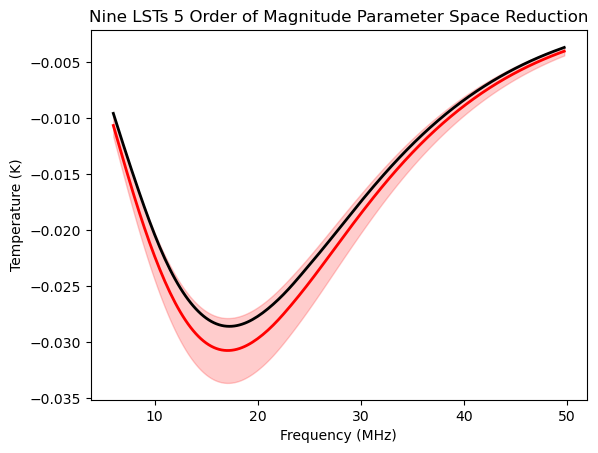

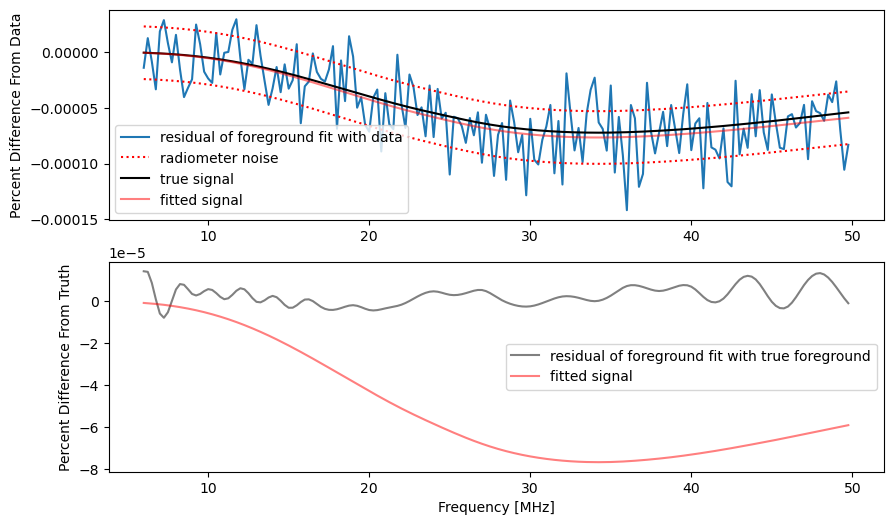

In [ ]:
### 9 LSTs ###

## Creates a training set with varied foreground and beams for all 4 different foregrounds:

custom_parameter_range = np.array([[0.999975,1.000025],[3.39999,3.40001],[4.59999,4.60009]])  # For making a random foreground
parameter_variation = [0.0000005,0.00000025,0.0000005]                               # For making a random foreground
# custom_parameter_range = np.array([[1,1],[3.4,3.4],[4.6,4.6]])
# custom_parameter_range = np.array([[1,1.1],[3.4,3.5],[4.6,4.7]])
# custom_parameter_range = np.array([[0.995,1.005],[3.3997,3.40027],[4.598,4.60128]])
# parameter_variation = [0.0002,0.0001,0.0002]
# parameter_variation = [0,0,0]
## Interpolate the varied beams to match the rest of the data
varied_regolith_training_set = np.zeros((len(varied_regolith_training_set_raw),len(frequencies)))
for n in range(len(varied_regolith_training_set_raw)):
    beam_regolith_interp = scipy.interpolate.CubicSpline(range(1,51),varied_regolith_training_set_raw[n,0,:])
    varied_regolith_training_set[n] = beam_regolith_interp(frequencies)
 # number of beams in the beam training set
exp_test=py21cmsig.expanded_training_set_no_t(varied_regolith_training_set,varied_regolith_training_set_raw_params,Nb,\
                               custom_parameter_range,show_parameter_ranges=True)


n_regions = 5
reference_frequency = 25
sky_map = foreground_array_minCMB[0]
BTS_curves = exp_test[0]
BTS_params = exp_test[1]
beam_sky_training_set = beams[:,5:,:]
beam_sky_training_set_params = varied_regolith_training_set_raw_params
raw_beam_weighted_sky_maps = raw_sky_maps

# parameter_variation = [0.05,0.025,0.05]
determine_parameter_range = True
new_FG_parameter_mean = None
foreground_run_set_1 = py21cmsig.synchrotron_foreground_forsigex(n_regions,frequencies,reference_frequency,sky_map,BTS_curves,BTS_params,\
                                    beam_sky_training_set,beam_sky_training_set_params,N,parameter_variation,B_value_functions, \
                                        define_parameter_mean=False,parameter_mean=new_FG_parameter_mean)
rms_values = py21cmsig.narrowed_training_set(simulation_test_beam_1[0],rms_mean,rms_std,foreground_run_set_1[3],foreground_run_set_1[4])[2]
new_parameter_mean = np.zeros((n_regions,3))
fg_range_array = np.zeros((n_regions,6))
foreground_parameter_variation = np.array(parameter_variation)

## Foreground 2

## Creates a training set with varied foreground and beams:

## Interpolate the varied beams to match the rest of the data
varied_regolith_training_set_2 = np.zeros((len(varied_regolith_training_set_raw_2),len(frequencies)))
for n in range(len(varied_regolith_training_set_raw_2)):
    beam_regolith_interp = scipy.interpolate.CubicSpline(range(1,51),varied_regolith_training_set_raw_2[n,0,:])
    varied_regolith_training_set[n] = beam_regolith_interp(frequencies)
 # number of beams in the beam training set
exp_test=py21cmsig.expanded_training_set_no_t(varied_regolith_training_set,varied_regolith_training_set_raw_params,Nb,\
                               custom_parameter_range,show_parameter_ranges=True)
n_regions = 5
reference_frequency = 25
sky_map = foreground_array_minCMB_2[0]
BTS_curves = exp_test[0]
BTS_params = exp_test[1]
beam_sky_training_set = beams[:,5:,:]
beam_sky_training_set_params = varied_regolith_training_set_raw_params
raw_beam_weighted_sky_maps = raw_sky_maps

# parameter_variation = [0.05,0.025,0.05]
determine_parameter_range = True
new_FG_parameter_mean = None
foreground_run_set_2 = py21cmsig.synchrotron_foreground_forsigex(n_regions,frequencies,reference_frequency,sky_map,BTS_curves,BTS_params,\
                                    beam_sky_training_set,beam_sky_training_set_params,N,parameter_variation, B_value_functions,\
                                        define_parameter_mean=False,parameter_mean=new_FG_parameter_mean)
rms_values = py21cmsig.narrowed_training_set(simulation_test_beam_2[0],rms_mean,rms_std,foreground_run_set_2[3],foreground_run_set_2[4])[2]
new_parameter_mean = np.zeros((n_regions,3))
fg_range_array = np.zeros((n_regions,6))
foreground_parameter_variation = np.array(parameter_variation)

## Foreground 3

## Creates a training set with varied foreground and beams:


## Interpolate the varied beams to match the rest of the data
varied_regolith_training_set_3 = np.zeros((len(varied_regolith_training_set_raw_3),len(frequencies)))
for n in range(len(varied_regolith_training_set_raw_3)):
    beam_regolith_interp = scipy.interpolate.CubicSpline(range(1,51),varied_regolith_training_set_raw_3[n,0,:])
    varied_regolith_training_set[n] = beam_regolith_interp(frequencies)
 # number of beams in the beam training set
exp_test=py21cmsig.expanded_training_set_no_t(varied_regolith_training_set,varied_regolith_training_set_raw_params,Nb,\
                               custom_parameter_range,show_parameter_ranges=True)
n_regions = 5
reference_frequency = 25
sky_map = foreground_array_minCMB_3[0]
BTS_curves = exp_test[0]
BTS_params = exp_test[1]
beam_sky_training_set = beams[:,5:,:]
beam_sky_training_set_params = varied_regolith_training_set_raw_params
raw_beam_weighted_sky_maps = raw_sky_maps

# parameter_variation = [0.05,0.025,0.05]
determine_parameter_range = True
new_FG_parameter_mean = None
foreground_run_set_3 = py21cmsig.synchrotron_foreground_forsigex(n_regions,frequencies,reference_frequency,sky_map,BTS_curves,BTS_params,\
                                    beam_sky_training_set,beam_sky_training_set_params,N,parameter_variation, B_value_functions,\
                                        define_parameter_mean=False,parameter_mean=new_FG_parameter_mean)
rms_values = py21cmsig.narrowed_training_set(simulation_test_beam_3[0],rms_mean,rms_std,foreground_run_set_3[3],foreground_run_set_3[4])[2]
new_parameter_mean = np.zeros((n_regions,3))
fg_range_array = np.zeros((n_regions,6))
foreground_parameter_variation = np.array(parameter_variation)

## Foreground 4

## Creates a training set with varied foreground and beams:


## Interpolate the varied beams to match the rest of the data
varied_regolith_training_set_4 = np.zeros((len(varied_regolith_training_set_raw_4),len(frequencies)))
for n in range(len(varied_regolith_training_set_raw_4)):
    beam_regolith_interp = scipy.interpolate.CubicSpline(range(1,51),varied_regolith_training_set_raw_4[n,0,:])
    varied_regolith_training_set[n] = beam_regolith_interp(frequencies)
 # number of beams in the beam training set
exp_test=py21cmsig.expanded_training_set_no_t(varied_regolith_training_set,varied_regolith_training_set_raw_params,Nb,\
                               custom_parameter_range,show_parameter_ranges=True)
n_regions = 5
reference_frequency = 25
sky_map = foreground_array_minCMB_4[0]
BTS_curves = exp_test[0]
BTS_params = exp_test[1]
beam_sky_training_set = beams[:,5:,:]
beam_sky_training_set_params = varied_regolith_training_set_raw_params
raw_beam_weighted_sky_maps = raw_sky_maps


determine_parameter_range = True
new_FG_parameter_mean = None
foreground_run_set_4 = py21cmsig.synchrotron_foreground_forsigex(n_regions,frequencies,reference_frequency,sky_map,BTS_curves,BTS_params,\
                                    beam_sky_training_set,beam_sky_training_set_params,N,parameter_variation,B_value_functions, \
                                        define_parameter_mean=False,parameter_mean=new_FG_parameter_mean)
rms_values =py21cmsig.narrowed_training_set(simulation_test_beam_4[0],rms_mean,rms_std,foreground_run_set_4[3],foreground_run_set_4[4])[2]
new_parameter_mean = np.zeros((n_regions,3))
fg_range_array = np.zeros((n_regions,6))
foreground_parameter_variation = np.array(parameter_variation)

## Foreground 5

## Creates a training set with varied foreground and beams:


## Interpolate the varied beams to match the rest of the data
varied_regolith_training_set_5 = np.zeros((len(varied_regolith_training_set_raw_5),len(frequencies)))
for n in range(len(varied_regolith_training_set_raw_5)):
    beam_regolith_interp = scipy.interpolate.CubicSpline(range(1,51),varied_regolith_training_set_raw_5[n,0,:])
    varied_regolith_training_set[n] = beam_regolith_interp(frequencies)
 # number of beams in the beam training set
exp_test=py21cmsig.expanded_training_set_no_t(varied_regolith_training_set,varied_regolith_training_set_raw_params,Nb,\
                               custom_parameter_range,show_parameter_ranges=True)
n_regions = 5
reference_frequency = 25
sky_map = foreground_array_minCMB_5[0]
BTS_curves = exp_test[0]
BTS_params = exp_test[1]
beam_sky_training_set = beams[:,5:,:]
beam_sky_training_set_params = varied_regolith_training_set_raw_params
raw_beam_weighted_sky_maps = raw_sky_maps


determine_parameter_range = True
new_FG_parameter_mean = None
foreground_run_set_5 = py21cmsig.synchrotron_foreground_forsigex(n_regions,frequencies,reference_frequency,sky_map,BTS_curves,BTS_params,\
                                    beam_sky_training_set,beam_sky_training_set_params,N,parameter_variation,B_value_functions, \
                                        define_parameter_mean=False,parameter_mean=new_FG_parameter_mean)
rms_values = py21cmsig.narrowed_training_set(simulation_test_beam_5[0],rms_mean,rms_std,foreground_run_set_5[3],foreground_run_set_5[4])[2]
new_parameter_mean = np.zeros((n_regions,3))
fg_range_array = np.zeros((n_regions,6))
foreground_parameter_variation = np.array(parameter_variation)

## Foreground 6

## Creates a training set with varied foreground and beams:


## Interpolate the varied beams to match the rest of the data
varied_regolith_training_set_6 = np.zeros((len(varied_regolith_training_set_raw_6),len(frequencies)))
for n in range(len(varied_regolith_training_set_raw_6)):
    beam_regolith_interp = scipy.interpolate.CubicSpline(range(1,51),varied_regolith_training_set_raw_6[n,0,:])
    varied_regolith_training_set[n] = beam_regolith_interp(frequencies)
 # number of beams in the beam training set
exp_test=py21cmsig.expanded_training_set_no_t(varied_regolith_training_set,varied_regolith_training_set_raw_params,Nb,\
                               custom_parameter_range,show_parameter_ranges=True)
n_regions = 5
reference_frequency = 25
sky_map = foreground_array_minCMB_6[0]
BTS_curves = exp_test[0]
BTS_params = exp_test[1]
beam_sky_training_set = beams[:,5:,:]
beam_sky_training_set_params = varied_regolith_training_set_raw_params
raw_beam_weighted_sky_maps = raw_sky_maps


determine_parameter_range = True
new_FG_parameter_mean = None
foreground_run_set_6 = py21cmsig.synchrotron_foreground_forsigex(n_regions,frequencies,reference_frequency,sky_map,BTS_curves,BTS_params,\
                                    beam_sky_training_set,beam_sky_training_set_params,N,parameter_variation,B_value_functions, \
                                        define_parameter_mean=False,parameter_mean=new_FG_parameter_mean)
rms_values = py21cmsig.narrowed_training_set(simulation_test_beam_6[0],rms_mean,rms_std,foreground_run_set_6[3],foreground_run_set_6[4])[2]
new_parameter_mean = np.zeros((n_regions,3))
fg_range_array = np.zeros((n_regions,6))
foreground_parameter_variation = np.array(parameter_variation)

## Foreground 7

## Creates a training set with varied foreground and beams:


## Interpolate the varied beams to match the rest of the data
varied_regolith_training_set_7 = np.zeros((len(varied_regolith_training_set_raw_7),len(frequencies)))
for n in range(len(varied_regolith_training_set_raw_7)):
    beam_regolith_interp = scipy.interpolate.CubicSpline(range(1,51),varied_regolith_training_set_raw_7[n,0,:])
    varied_regolith_training_set[n] = beam_regolith_interp(frequencies)
 # number of beams in the beam training set
exp_test=py21cmsig.expanded_training_set_no_t(varied_regolith_training_set,varied_regolith_training_set_raw_params,Nb,\
                               custom_parameter_range,show_parameter_ranges=True)
n_regions = 5
reference_frequency = 25
sky_map = foreground_array_minCMB_7[0]
BTS_curves = exp_test[0]
BTS_params = exp_test[1]
beam_sky_training_set = beams[:,5:,:]
beam_sky_training_set_params = varied_regolith_training_set_raw_params
raw_beam_weighted_sky_maps = raw_sky_maps


determine_parameter_range = True
new_FG_parameter_mean = None
foreground_run_set_7 = py21cmsig.synchrotron_foreground_forsigex(n_regions,frequencies,reference_frequency,sky_map,BTS_curves,BTS_params,\
                                    beam_sky_training_set,beam_sky_training_set_params,N,parameter_variation, B_value_functions,\
                                        define_parameter_mean=False,parameter_mean=new_FG_parameter_mean)
rms_values = py21cmsig.narrowed_training_set(simulation_test_beam_7[0],rms_mean,rms_std,foreground_run_set_7[3],foreground_run_set_7[4])[2]
new_parameter_mean = np.zeros((n_regions,3))
fg_range_array = np.zeros((n_regions,6))
foreground_parameter_variation = np.array(parameter_variation)

## Foreground 8

## Creates a training set with varied foreground and beams:


## Interpolate the varied beams to match the rest of the data
varied_regolith_training_set_8 = np.zeros((len(varied_regolith_training_set_raw_8),len(frequencies)))
for n in range(len(varied_regolith_training_set_raw_8)):
    beam_regolith_interp = scipy.interpolate.CubicSpline(range(1,51),varied_regolith_training_set_raw_8[n,0,:])
    varied_regolith_training_set[n] = beam_regolith_interp(frequencies)
 # number of beams in the beam training set
exp_test=py21cmsig.expanded_training_set_no_t(varied_regolith_training_set,varied_regolith_training_set_raw_params,Nb,\
                               custom_parameter_range,show_parameter_ranges=True)
n_regions = 5
reference_frequency = 25
sky_map = foreground_array_minCMB_8[0]
BTS_curves = exp_test[0]
BTS_params = exp_test[1]
beam_sky_training_set = beams[:,5:,:]
beam_sky_training_set_params = varied_regolith_training_set_raw_params
raw_beam_weighted_sky_maps = raw_sky_maps


determine_parameter_range = True
new_FG_parameter_mean = None
foreground_run_set_8 = py21cmsig.synchrotron_foreground_forsigex(n_regions,frequencies,reference_frequency,sky_map,BTS_curves,BTS_params,\
                                    beam_sky_training_set,beam_sky_training_set_params,N,parameter_variation,B_value_functions, \
                                        define_parameter_mean=False,parameter_mean=new_FG_parameter_mean)
rms_values = py21cmsig.narrowed_training_set(simulation_test_beam_8[0],rms_mean,rms_std,foreground_run_set_8[3],foreground_run_set_8[4])[2]
new_parameter_mean = np.zeros((n_regions,3))
fg_range_array = np.zeros((n_regions,6))
foreground_parameter_variation = np.array(parameter_variation)

## Foreground 9

## Creates a training set with varied foreground and beams:


## Interpolate the varied beams to match the rest of the data
varied_regolith_training_set_9 = np.zeros((len(varied_regolith_training_set_raw_9),len(frequencies)))
for n in range(len(varied_regolith_training_set_raw_9)):
    beam_regolith_interp = scipy.interpolate.CubicSpline(range(1,51),varied_regolith_training_set_raw_9[n,0,:])
    varied_regolith_training_set[n] = beam_regolith_interp(frequencies)
 # number of beams in the beam training set
exp_test=py21cmsig.expanded_training_set_no_t(varied_regolith_training_set,varied_regolith_training_set_raw_params,Nb,\
                               custom_parameter_range,show_parameter_ranges=True)
n_regions = 5
reference_frequency = 25
sky_map = foreground_array_minCMB_9[0]
BTS_curves = exp_test[0]
BTS_params = exp_test[1]
beam_sky_training_set = beams[:,5:,:]
beam_sky_training_set_params = varied_regolith_training_set_raw_params
raw_beam_weighted_sky_maps = raw_sky_maps


determine_parameter_range = True
new_FG_parameter_mean = None
foreground_run_set_9 = py21cmsig.synchrotron_foreground_forsigex(n_regions,frequencies,reference_frequency,sky_map,BTS_curves,BTS_params,\
                                    beam_sky_training_set,beam_sky_training_set_params,N,parameter_variation, B_value_functions,\
                                        define_parameter_mean=False,parameter_mean=new_FG_parameter_mean)
rms_values = py21cmsig.narrowed_training_set(simulation_test_beam_9[0],rms_mean,rms_std,foreground_run_set_9[3],foreground_run_set_9[4])[2]
new_parameter_mean = np.zeros((n_regions,3))
fg_range_array = np.zeros((n_regions,6))
foreground_parameter_variation = np.array(parameter_variation)

### Combine them all
foreground_run_combined_9 = np.zeros((Nb*N,9,len(frequencies)))
foreground_run_combined_9[:,0,:] = foreground_run_set_1[3]
foreground_run_combined_9[:,1,:] = foreground_run_set_2[3]
foreground_run_combined_9[:,2,:] = foreground_run_set_3[3]
foreground_run_combined_9[:,3,:] = foreground_run_set_4[3]
foreground_run_combined_9[:,4,:] = foreground_run_set_5[3]
foreground_run_combined_9[:,5,:] = foreground_run_set_6[3]
foreground_run_combined_9[:,6,:] = foreground_run_set_7[3]
foreground_run_combined_9[:,7,:] = foreground_run_set_8[3]
foreground_run_combined_9[:,8,:] = foreground_run_set_9[3]
# foreground_run_combined = np.concatenate((foreground_run_set_1[3],foreground_run_set_2[3],foreground_run_set_3[3],foreground_run_set_4[3]),axis=0)

# #Let's first start by combining the two arrays for the two separate signals:
fg_training_set = copy.deepcopy(foreground_run_combined_9)
flattened_foreground_training_set = np.reshape(fg_training_set, (len(fg_training_set), -1))
signal_training_set_4LST = copy.deepcopy(DMAN_training_set[0])

total_signal = np.zeros((9,len(frequencies)))
total_signal[0,:] = simulation_test_beam_1[0]
total_signal[1,:] = simulation_test_beam_2[0]
total_signal[2,:] = simulation_test_beam_3[0]
total_signal[3,:] = simulation_test_beam_4[0]
total_signal[4,:] = simulation_test_beam_5[0]
total_signal[5,:] = simulation_test_beam_6[0]
total_signal[6,:] = simulation_test_beam_7[0]
total_signal[7,:] = simulation_test_beam_8[0]
total_signal[8,:] = simulation_test_beam_9[0]

total_noise = np.zeros((9,len(frequencies)))
noise_level_1 = sigT(simulation_test_beam_1[0],dnu,dt)
noise_level_2 = sigT(simulation_test_beam_2[0],dnu,dt)
noise_level_3 = sigT(simulation_test_beam_3[0],dnu,dt)
noise_level_4 = sigT(simulation_test_beam_4[0],dnu,dt)
noise_level_5 = sigT(simulation_test_beam_5[0],dnu,dt)
noise_level_6 = sigT(simulation_test_beam_6[0],dnu,dt)
noise_level_7 = sigT(simulation_test_beam_7[0],dnu,dt)
noise_level_8 = sigT(simulation_test_beam_8[0],dnu,dt)
noise_level_9 = sigT(simulation_test_beam_9[0],dnu,dt)
total_noise[0,:] = noise_level_1
total_noise[1,:] = noise_level_2
total_noise[2,:] = noise_level_3
total_noise[3,:] = noise_level_4
total_noise[4,:] = noise_level_5
total_noise[5,:] = noise_level_6
total_noise[6,:] = noise_level_7
total_noise[7,:] = noise_level_8
total_noise[8,:] = noise_level_9



# pylinex requires 1D arrays, so let's flatten the noise_level and temperatures matrices (i.e. collapse the spectra)
temperatures_flat = total_signal.flatten()
noise_level_flat = total_noise.flatten()

# same as in Problem 3, let's use PowerLawTimesLogPolynomialModel for the foreground and a Gaussian for the signal


# across the 8 spectra, the signal is the same, but the foreground changes
# so, we have to make a different basis vector for each of the foreground spectra, but one basis for the sinal
names = ['foreground','signal']

                  # to transform the basis vectors from one space to another (e.g. into the data space), we use the Expander objects. 
                  # for the foreground, we will use PadExpander, which pads each foreground basis vector with zeros for the other spectra
                  # for the signal, we will use RepeatExpander, which expands vectors by repeating them multiple times
                  # (i.e. the signal is constant over the 8 pointings)

bases = [TrainedBasis(flattened_foreground_training_set,num_basis_vectors=600, expander=NullExpander()),\
TrainedBasis(signal_training_set_4LST,num_basis_vectors=40, expander=RepeatExpander(9))]
bases[0].generate_gaussian_prior()
bases[1].generate_gaussian_prior()

# define BasisSum object for pylinex's Fitter class 
# again using multiple bases, 8 for the foreground and one for the signal Gaussian
basis_sum = BasisSum(names, bases)

# same as in Problems 2 and 3,
# we optimize the number of terms by minimizing the Bayesian predictive information criterion (BPIC)
quantity = AttributeQuantity(IC)

# now set the number of terms to search numerically to minimize the BPIC
# choosing between 1 and 10 terms for each of the foregrounds, and 1 term for the signal
# placing the foreground spectra in the same dictionary,
# so that MetaFitter knows each will use the same number of terms (decreasing number of fits to perform)
dimension = [{"foreground": np.arange(1,600)},
{'signal': np.arange(1,30)}]

# now use MetaFitter to perform fits over the grid and choose the optimal fit based on minimizing the BPIC
# priors = {"signal_prior" : bases[1].gaussian_prior}
meta_fitter = MetaFitter(basis_sum, temperatures_flat, noise_level_flat, quantity,\
quantity.name, *dimension)

# grab the Fitter object that corresponds to the fit that minimized the BPIC statistic
fitter_9 = meta_fitter.fitter_from_indices(meta_fitter.minimize_quantity(IC))
num_foreground_terms = fitter_9.sizes['foreground']
num_signal_terms = fitter_9.sizes["signal"]
print(f'The MetaFitter chose %i foreground terms based on {IC} minimization.' % num_foreground_terms)
print(f'The MetaFitter chose %i signal terms based on {IC} minimization.' % num_signal_terms)
print(f"{fitter_9.subbasis_channel_mean("signal").min()} Temperature of lowest point of the trough ")
print(f"{fitter_9.subbasis_channel_error("signal")[np.where(fitter_9.subbasis_channel_mean("signal")==fitter_9.subbasis_channel_mean("signal").min())][0]} Channel error at lowest point of the trough ")
print(f"{fitter_9.log_evidence} log evidence")
print(f"{fitter_9.chi_squared} Chi Squared")
print(f"{fitter_9.psi_squared} Psi Squared")
pearsonr=scipy.stats.pearsonr(fitter_9.subbasis_channel_mean("signal")/simulation_test_beam_1[2],(fitter_9.subbasis_channel_mean("foreground")[0:len(frequencies)]-simulation_test_beam_1[2])/simulation_test_beam_1[2])
print(f"True {pearsonr}")
fitter_9.plot_subbasis_fit(nsigma=1, name='signal', x_values=frequencies,\
colors='r', xlabel='Frequency (MHz)', ylabel='Temperature (K)',\
title='Nine LSTs 5 Order of Magnitude Parameter Space Reduction', show=True,true_curve = simulation_test_beam_1[1])


fig, (ax1, ax2) = plt.subplots(2,1,figsize=(10, 6))
plt.subplot(2,1,1)
plt.plot(frequencies,(simulation_test_beam_1[0]-fitter_9.subbasis_channel_mean("foreground")[0:len(frequencies)])/simulation_test_beam_1[0]*100,label="residual of foreground fit with data")
plt.plot(frequencies,(fitter_9.subbasis_channel_mean("signal")+sigT(simulation_test_beam_1[0],dnu,dt))/simulation_test_beam_1[0]*100,color="red",ls=":" ,label="radiometer noise")
plt.plot(frequencies,(fitter_9.subbasis_channel_mean("signal")-sigT(simulation_test_beam_1[0],dnu,dt))/simulation_test_beam_1[0]*100,color="red", ls=":")
plt.plot(frequencies,simulation_test_beam_1[1]/simulation_test_beam_1[0]*100,label="true signal",c="black")
plt.plot(frequencies,fitter_9.subbasis_channel_mean("signal")/simulation_test_beam_1[0]*100,label="fitted signal",alpha=0.5,c='red')
plt.ylabel("Percent Difference From Data")

plt.legend()

# Plots a handy plot of the true foreground residual from the simulation minus the foreground fit compared to the signal fit
# Good for identifying degeneracy by eye (pearson r is quantifying this)
plt.subplot(2,1,2)
plt.title("")
plt.plot(frequencies,((fitter_9.subbasis_channel_mean("foreground")[0:len(frequencies)]-simulation_test_beam_1[2]))/simulation_test_beam_1[2]*100,c="grey",label="residual of foreground fit with true foreground")
plt.plot(frequencies,fitter_9.subbasis_channel_mean("signal")/simulation_test_beam_1[2]*100,c="red",alpha=0.5,label="fitted signal")
plt.xlabel("Frequency [MHz]")
plt.ylabel("Percent Difference From Truth")
plt.legend()

100%|██████████| 176/176 [00:01<00:00, 168.26it/s]


[[0.9999975 1.0000025]
 [3.399999  3.400001 ]
 [4.599999  4.600009 ]]


100%|██████████| 500/500 [00:02<00:00, 228.08it/s]


[5e-08, 2.5e-08, 5e-08]


100%|██████████| 176/176 [00:01<00:00, 171.32it/s]


[[0.9999975 1.0000025]
 [3.399999  3.400001 ]
 [4.599999  4.600009 ]]


100%|██████████| 500/500 [00:02<00:00, 232.74it/s]


[5e-08, 2.5e-08, 5e-08]


100%|██████████| 176/176 [00:00<00:00, 177.00it/s]


[[0.9999975 1.0000025]
 [3.399999  3.400001 ]
 [4.599999  4.600009 ]]


100%|██████████| 500/500 [00:02<00:00, 229.74it/s]


[5e-08, 2.5e-08, 5e-08]


100%|██████████| 176/176 [00:00<00:00, 181.60it/s]


[[0.9999975 1.0000025]
 [3.399999  3.400001 ]
 [4.599999  4.600009 ]]


100%|██████████| 500/500 [00:02<00:00, 236.29it/s]


[5e-08, 2.5e-08, 5e-08]


100%|██████████| 176/176 [00:00<00:00, 180.42it/s]


[[0.9999975 1.0000025]
 [3.399999  3.400001 ]
 [4.599999  4.600009 ]]


100%|██████████| 500/500 [00:02<00:00, 236.84it/s]


[5e-08, 2.5e-08, 5e-08]


100%|██████████| 176/176 [00:00<00:00, 176.87it/s]


[[0.9999975 1.0000025]
 [3.399999  3.400001 ]
 [4.599999  4.600009 ]]


100%|██████████| 500/500 [00:02<00:00, 235.89it/s]


[5e-08, 2.5e-08, 5e-08]


100%|██████████| 176/176 [00:00<00:00, 177.97it/s]


[[0.9999975 1.0000025]
 [3.399999  3.400001 ]
 [4.599999  4.600009 ]]


100%|██████████| 500/500 [00:02<00:00, 232.94it/s]


[5e-08, 2.5e-08, 5e-08]


100%|██████████| 176/176 [00:00<00:00, 176.23it/s]


[[0.9999975 1.0000025]
 [3.399999  3.400001 ]
 [4.599999  4.600009 ]]


100%|██████████| 500/500 [00:02<00:00, 233.18it/s]


[5e-08, 2.5e-08, 5e-08]


100%|██████████| 176/176 [00:00<00:00, 180.80it/s]


[[0.9999975 1.0000025]
 [3.399999  3.400001 ]
 [4.599999  4.600009 ]]


100%|██████████| 500/500 [00:02<00:00, 239.92it/s]


[5e-08, 2.5e-08, 5e-08]


100%|██████████| 250000/250000 [00:01<00:00, 210168.20it/s]


Minimizing BPIC over grid.
The MetaFitter chose 1 foreground terms based on BPIC minimization.
The MetaFitter chose 2 signal terms based on BPIC minimization.
-0.03134012518481293 Temperature of lowest point of the trough 
0.0010035086040523435 Channel error at lowest point of the trough 
-777.607405702705 log evidence
1557.4529430533066 Chi Squared
0.9408133482277229 Psi Squared
True PearsonRResult(statistic=0.5355017371211672, pvalue=1.8955582919189624e-14)


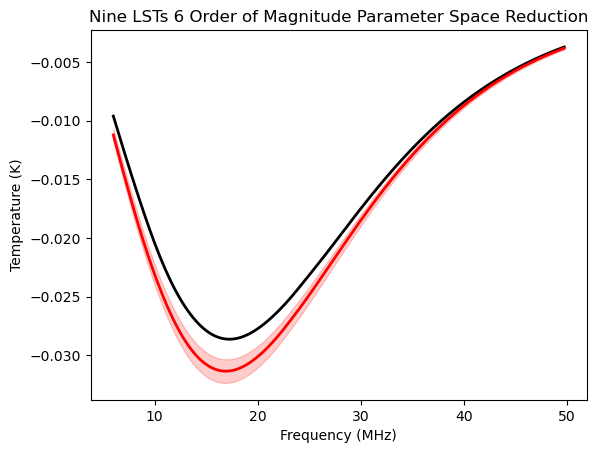

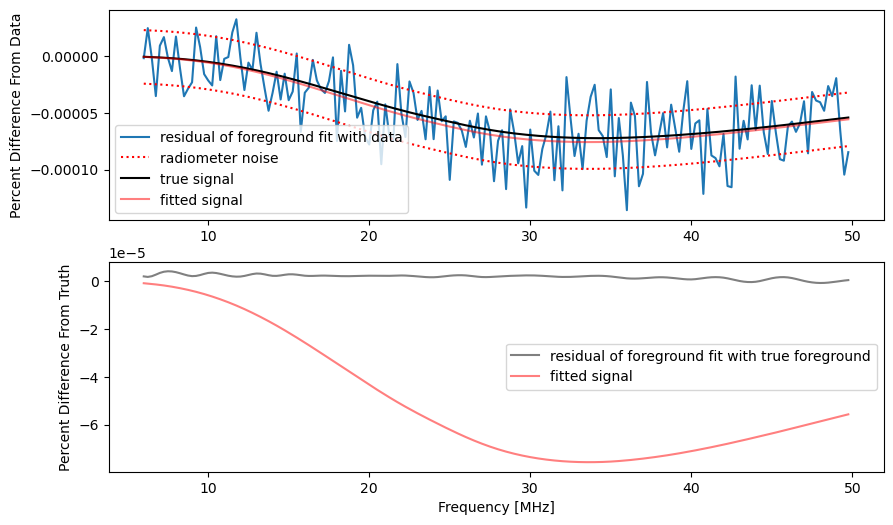

In [ ]:
### 9 LSTs ###

## Creates a training set with varied foreground and beams for all 4 different foregrounds:

custom_parameter_range = np.array([[0.9999975,1.0000025],[3.399999,3.400001],[4.599999,4.600009]])  # For making a random foreground
parameter_variation = [0.00000005,0.000000025,0.00000005]                           # For making a random foreground
# custom_parameter_range = np.array([[1,1],[3.4,3.4],[4.6,4.6]])
# custom_parameter_range = np.array([[1,1.1],[3.4,3.5],[4.6,4.7]])
# custom_parameter_range = np.array([[0.995,1.005],[3.3997,3.40027],[4.598,4.60128]])
# parameter_variation = [0.0002,0.0001,0.0002]
# parameter_variation = [0,0,0]
## Interpolate the varied beams to match the rest of the data
varied_regolith_training_set = np.zeros((len(varied_regolith_training_set_raw),len(frequencies)))
for n in range(len(varied_regolith_training_set_raw)):
    beam_regolith_interp = scipy.interpolate.CubicSpline(range(1,51),varied_regolith_training_set_raw[n,0,:])
    varied_regolith_training_set[n] = beam_regolith_interp(frequencies)
 # number of beams in the beam training set
exp_test=py21cmsig.expanded_training_set_no_t(varied_regolith_training_set,varied_regolith_training_set_raw_params,Nb,\
                               custom_parameter_range,show_parameter_ranges=True)


n_regions = 5
reference_frequency = 25
sky_map = foreground_array_minCMB[0]
BTS_curves = exp_test[0]
BTS_params = exp_test[1]
beam_sky_training_set = beams[:,5:,:]
beam_sky_training_set_params = varied_regolith_training_set_raw_params
raw_beam_weighted_sky_maps = raw_sky_maps

# parameter_variation = [0.05,0.025,0.05]
determine_parameter_range = True
new_FG_parameter_mean = None
foreground_run_set_1 = py21cmsig.synchrotron_foreground_forsigex(n_regions,frequencies,reference_frequency,sky_map,BTS_curves,BTS_params,\
                                    beam_sky_training_set,beam_sky_training_set_params,N,parameter_variation,B_value_functions, \
                                        define_parameter_mean=False,parameter_mean=new_FG_parameter_mean)
rms_values = py21cmsig.narrowed_training_set(simulation_test_beam_1[0],rms_mean,rms_std,foreground_run_set_1[3],foreground_run_set_1[4])[2]
new_parameter_mean = np.zeros((n_regions,3))
fg_range_array = np.zeros((n_regions,6))
foreground_parameter_variation = np.array(parameter_variation)

## Foreground 2

## Creates a training set with varied foreground and beams:

## Interpolate the varied beams to match the rest of the data
varied_regolith_training_set_2 = np.zeros((len(varied_regolith_training_set_raw_2),len(frequencies)))
for n in range(len(varied_regolith_training_set_raw_2)):
    beam_regolith_interp = scipy.interpolate.CubicSpline(range(1,51),varied_regolith_training_set_raw_2[n,0,:])
    varied_regolith_training_set[n] = beam_regolith_interp(frequencies)
 # number of beams in the beam training set
exp_test=py21cmsig.expanded_training_set_no_t(varied_regolith_training_set,varied_regolith_training_set_raw_params,Nb,\
                               custom_parameter_range,show_parameter_ranges=True)
n_regions = 5
reference_frequency = 25
sky_map = foreground_array_minCMB_2[0]
BTS_curves = exp_test[0]
BTS_params = exp_test[1]
beam_sky_training_set = beams[:,5:,:]
beam_sky_training_set_params = varied_regolith_training_set_raw_params
raw_beam_weighted_sky_maps = raw_sky_maps

# parameter_variation = [0.05,0.025,0.05]
determine_parameter_range = True
new_FG_parameter_mean = None
foreground_run_set_2 = py21cmsig.synchrotron_foreground_forsigex(n_regions,frequencies,reference_frequency,sky_map,BTS_curves,BTS_params,\
                                    beam_sky_training_set,beam_sky_training_set_params,N,parameter_variation, B_value_functions,\
                                        define_parameter_mean=False,parameter_mean=new_FG_parameter_mean)
rms_values = py21cmsig.narrowed_training_set(simulation_test_beam_2[0],rms_mean,rms_std,foreground_run_set_2[3],foreground_run_set_2[4])[2]
new_parameter_mean = np.zeros((n_regions,3))
fg_range_array = np.zeros((n_regions,6))
foreground_parameter_variation = np.array(parameter_variation)

## Foreground 3

## Creates a training set with varied foreground and beams:


## Interpolate the varied beams to match the rest of the data
varied_regolith_training_set_3 = np.zeros((len(varied_regolith_training_set_raw_3),len(frequencies)))
for n in range(len(varied_regolith_training_set_raw_3)):
    beam_regolith_interp = scipy.interpolate.CubicSpline(range(1,51),varied_regolith_training_set_raw_3[n,0,:])
    varied_regolith_training_set[n] = beam_regolith_interp(frequencies)
 # number of beams in the beam training set
exp_test=py21cmsig.expanded_training_set_no_t(varied_regolith_training_set,varied_regolith_training_set_raw_params,Nb,\
                               custom_parameter_range,show_parameter_ranges=True)
n_regions = 5
reference_frequency = 25
sky_map = foreground_array_minCMB_3[0]
BTS_curves = exp_test[0]
BTS_params = exp_test[1]
beam_sky_training_set = beams[:,5:,:]
beam_sky_training_set_params = varied_regolith_training_set_raw_params
raw_beam_weighted_sky_maps = raw_sky_maps

# parameter_variation = [0.05,0.025,0.05]
determine_parameter_range = True
new_FG_parameter_mean = None
foreground_run_set_3 = py21cmsig.synchrotron_foreground_forsigex(n_regions,frequencies,reference_frequency,sky_map,BTS_curves,BTS_params,\
                                    beam_sky_training_set,beam_sky_training_set_params,N,parameter_variation, B_value_functions,\
                                        define_parameter_mean=False,parameter_mean=new_FG_parameter_mean)
rms_values = py21cmsig.narrowed_training_set(simulation_test_beam_3[0],rms_mean,rms_std,foreground_run_set_3[3],foreground_run_set_3[4])[2]
new_parameter_mean = np.zeros((n_regions,3))
fg_range_array = np.zeros((n_regions,6))
foreground_parameter_variation = np.array(parameter_variation)

## Foreground 4

## Creates a training set with varied foreground and beams:


## Interpolate the varied beams to match the rest of the data
varied_regolith_training_set_4 = np.zeros((len(varied_regolith_training_set_raw_4),len(frequencies)))
for n in range(len(varied_regolith_training_set_raw_4)):
    beam_regolith_interp = scipy.interpolate.CubicSpline(range(1,51),varied_regolith_training_set_raw_4[n,0,:])
    varied_regolith_training_set[n] = beam_regolith_interp(frequencies)
 # number of beams in the beam training set
exp_test=py21cmsig.expanded_training_set_no_t(varied_regolith_training_set,varied_regolith_training_set_raw_params,Nb,\
                               custom_parameter_range,show_parameter_ranges=True)
n_regions = 5
reference_frequency = 25
sky_map = foreground_array_minCMB_4[0]
BTS_curves = exp_test[0]
BTS_params = exp_test[1]
beam_sky_training_set = beams[:,5:,:]
beam_sky_training_set_params = varied_regolith_training_set_raw_params
raw_beam_weighted_sky_maps = raw_sky_maps


determine_parameter_range = True
new_FG_parameter_mean = None
foreground_run_set_4 = py21cmsig.synchrotron_foreground_forsigex(n_regions,frequencies,reference_frequency,sky_map,BTS_curves,BTS_params,\
                                    beam_sky_training_set,beam_sky_training_set_params,N,parameter_variation,B_value_functions, \
                                        define_parameter_mean=False,parameter_mean=new_FG_parameter_mean)
rms_values =py21cmsig.narrowed_training_set(simulation_test_beam_4[0],rms_mean,rms_std,foreground_run_set_4[3],foreground_run_set_4[4])[2]
new_parameter_mean = np.zeros((n_regions,3))
fg_range_array = np.zeros((n_regions,6))
foreground_parameter_variation = np.array(parameter_variation)

## Foreground 5

## Creates a training set with varied foreground and beams:


## Interpolate the varied beams to match the rest of the data
varied_regolith_training_set_5 = np.zeros((len(varied_regolith_training_set_raw_5),len(frequencies)))
for n in range(len(varied_regolith_training_set_raw_5)):
    beam_regolith_interp = scipy.interpolate.CubicSpline(range(1,51),varied_regolith_training_set_raw_5[n,0,:])
    varied_regolith_training_set[n] = beam_regolith_interp(frequencies)
 # number of beams in the beam training set
exp_test=py21cmsig.expanded_training_set_no_t(varied_regolith_training_set,varied_regolith_training_set_raw_params,Nb,\
                               custom_parameter_range,show_parameter_ranges=True)
n_regions = 5
reference_frequency = 25
sky_map = foreground_array_minCMB_5[0]
BTS_curves = exp_test[0]
BTS_params = exp_test[1]
beam_sky_training_set = beams[:,5:,:]
beam_sky_training_set_params = varied_regolith_training_set_raw_params
raw_beam_weighted_sky_maps = raw_sky_maps


determine_parameter_range = True
new_FG_parameter_mean = None
foreground_run_set_5 = py21cmsig.synchrotron_foreground_forsigex(n_regions,frequencies,reference_frequency,sky_map,BTS_curves,BTS_params,\
                                    beam_sky_training_set,beam_sky_training_set_params,N,parameter_variation,B_value_functions, \
                                        define_parameter_mean=False,parameter_mean=new_FG_parameter_mean)
rms_values = py21cmsig.narrowed_training_set(simulation_test_beam_5[0],rms_mean,rms_std,foreground_run_set_5[3],foreground_run_set_5[4])[2]
new_parameter_mean = np.zeros((n_regions,3))
fg_range_array = np.zeros((n_regions,6))
foreground_parameter_variation = np.array(parameter_variation)

## Foreground 6

## Creates a training set with varied foreground and beams:


## Interpolate the varied beams to match the rest of the data
varied_regolith_training_set_6 = np.zeros((len(varied_regolith_training_set_raw_6),len(frequencies)))
for n in range(len(varied_regolith_training_set_raw_6)):
    beam_regolith_interp = scipy.interpolate.CubicSpline(range(1,51),varied_regolith_training_set_raw_6[n,0,:])
    varied_regolith_training_set[n] = beam_regolith_interp(frequencies)
 # number of beams in the beam training set
exp_test=py21cmsig.expanded_training_set_no_t(varied_regolith_training_set,varied_regolith_training_set_raw_params,Nb,\
                               custom_parameter_range,show_parameter_ranges=True)
n_regions = 5
reference_frequency = 25
sky_map = foreground_array_minCMB_6[0]
BTS_curves = exp_test[0]
BTS_params = exp_test[1]
beam_sky_training_set = beams[:,5:,:]
beam_sky_training_set_params = varied_regolith_training_set_raw_params
raw_beam_weighted_sky_maps = raw_sky_maps


determine_parameter_range = True
new_FG_parameter_mean = None
foreground_run_set_6 = py21cmsig.synchrotron_foreground_forsigex(n_regions,frequencies,reference_frequency,sky_map,BTS_curves,BTS_params,\
                                    beam_sky_training_set,beam_sky_training_set_params,N,parameter_variation,B_value_functions, \
                                        define_parameter_mean=False,parameter_mean=new_FG_parameter_mean)
rms_values = py21cmsig.narrowed_training_set(simulation_test_beam_6[0],rms_mean,rms_std,foreground_run_set_6[3],foreground_run_set_6[4])[2]
new_parameter_mean = np.zeros((n_regions,3))
fg_range_array = np.zeros((n_regions,6))
foreground_parameter_variation = np.array(parameter_variation)

## Foreground 7

## Creates a training set with varied foreground and beams:


## Interpolate the varied beams to match the rest of the data
varied_regolith_training_set_7 = np.zeros((len(varied_regolith_training_set_raw_7),len(frequencies)))
for n in range(len(varied_regolith_training_set_raw_7)):
    beam_regolith_interp = scipy.interpolate.CubicSpline(range(1,51),varied_regolith_training_set_raw_7[n,0,:])
    varied_regolith_training_set[n] = beam_regolith_interp(frequencies)
 # number of beams in the beam training set
exp_test=py21cmsig.expanded_training_set_no_t(varied_regolith_training_set,varied_regolith_training_set_raw_params,Nb,\
                               custom_parameter_range,show_parameter_ranges=True)
n_regions = 5
reference_frequency = 25
sky_map = foreground_array_minCMB_7[0]
BTS_curves = exp_test[0]
BTS_params = exp_test[1]
beam_sky_training_set = beams[:,5:,:]
beam_sky_training_set_params = varied_regolith_training_set_raw_params
raw_beam_weighted_sky_maps = raw_sky_maps


determine_parameter_range = True
new_FG_parameter_mean = None
foreground_run_set_7 = py21cmsig.synchrotron_foreground_forsigex(n_regions,frequencies,reference_frequency,sky_map,BTS_curves,BTS_params,\
                                    beam_sky_training_set,beam_sky_training_set_params,N,parameter_variation, B_value_functions,\
                                        define_parameter_mean=False,parameter_mean=new_FG_parameter_mean)
rms_values = py21cmsig.narrowed_training_set(simulation_test_beam_7[0],rms_mean,rms_std,foreground_run_set_7[3],foreground_run_set_7[4])[2]
new_parameter_mean = np.zeros((n_regions,3))
fg_range_array = np.zeros((n_regions,6))
foreground_parameter_variation = np.array(parameter_variation)

## Foreground 8

## Creates a training set with varied foreground and beams:


## Interpolate the varied beams to match the rest of the data
varied_regolith_training_set_8 = np.zeros((len(varied_regolith_training_set_raw_8),len(frequencies)))
for n in range(len(varied_regolith_training_set_raw_8)):
    beam_regolith_interp = scipy.interpolate.CubicSpline(range(1,51),varied_regolith_training_set_raw_8[n,0,:])
    varied_regolith_training_set[n] = beam_regolith_interp(frequencies)
 # number of beams in the beam training set
exp_test=py21cmsig.expanded_training_set_no_t(varied_regolith_training_set,varied_regolith_training_set_raw_params,Nb,\
                               custom_parameter_range,show_parameter_ranges=True)
n_regions = 5
reference_frequency = 25
sky_map = foreground_array_minCMB_8[0]
BTS_curves = exp_test[0]
BTS_params = exp_test[1]
beam_sky_training_set = beams[:,5:,:]
beam_sky_training_set_params = varied_regolith_training_set_raw_params
raw_beam_weighted_sky_maps = raw_sky_maps


determine_parameter_range = True
new_FG_parameter_mean = None
foreground_run_set_8 = py21cmsig.synchrotron_foreground_forsigex(n_regions,frequencies,reference_frequency,sky_map,BTS_curves,BTS_params,\
                                    beam_sky_training_set,beam_sky_training_set_params,N,parameter_variation,B_value_functions, \
                                        define_parameter_mean=False,parameter_mean=new_FG_parameter_mean)
rms_values = py21cmsig.narrowed_training_set(simulation_test_beam_8[0],rms_mean,rms_std,foreground_run_set_8[3],foreground_run_set_8[4])[2]
new_parameter_mean = np.zeros((n_regions,3))
fg_range_array = np.zeros((n_regions,6))
foreground_parameter_variation = np.array(parameter_variation)

## Foreground 9

## Creates a training set with varied foreground and beams:


## Interpolate the varied beams to match the rest of the data
varied_regolith_training_set_9 = np.zeros((len(varied_regolith_training_set_raw_9),len(frequencies)))
for n in range(len(varied_regolith_training_set_raw_9)):
    beam_regolith_interp = scipy.interpolate.CubicSpline(range(1,51),varied_regolith_training_set_raw_9[n,0,:])
    varied_regolith_training_set[n] = beam_regolith_interp(frequencies)
 # number of beams in the beam training set
exp_test=py21cmsig.expanded_training_set_no_t(varied_regolith_training_set,varied_regolith_training_set_raw_params,Nb,\
                               custom_parameter_range,show_parameter_ranges=True)
n_regions = 5
reference_frequency = 25
sky_map = foreground_array_minCMB_9[0]
BTS_curves = exp_test[0]
BTS_params = exp_test[1]
beam_sky_training_set = beams[:,5:,:]
beam_sky_training_set_params = varied_regolith_training_set_raw_params
raw_beam_weighted_sky_maps = raw_sky_maps


determine_parameter_range = True
new_FG_parameter_mean = None
foreground_run_set_9 = py21cmsig.synchrotron_foreground_forsigex(n_regions,frequencies,reference_frequency,sky_map,BTS_curves,BTS_params,\
                                    beam_sky_training_set,beam_sky_training_set_params,N,parameter_variation, B_value_functions,\
                                        define_parameter_mean=False,parameter_mean=new_FG_parameter_mean)
rms_values = py21cmsig.narrowed_training_set(simulation_test_beam_9[0],rms_mean,rms_std,foreground_run_set_9[3],foreground_run_set_9[4])[2]
new_parameter_mean = np.zeros((n_regions,3))
fg_range_array = np.zeros((n_regions,6))
foreground_parameter_variation = np.array(parameter_variation)

### Combine them all
foreground_run_combined_9 = np.zeros((Nb*N,9,len(frequencies)))
foreground_run_combined_9[:,0,:] = foreground_run_set_1[3]
foreground_run_combined_9[:,1,:] = foreground_run_set_2[3]
foreground_run_combined_9[:,2,:] = foreground_run_set_3[3]
foreground_run_combined_9[:,3,:] = foreground_run_set_4[3]
foreground_run_combined_9[:,4,:] = foreground_run_set_5[3]
foreground_run_combined_9[:,5,:] = foreground_run_set_6[3]
foreground_run_combined_9[:,6,:] = foreground_run_set_7[3]
foreground_run_combined_9[:,7,:] = foreground_run_set_8[3]
foreground_run_combined_9[:,8,:] = foreground_run_set_9[3]
# foreground_run_combined = np.concatenate((foreground_run_set_1[3],foreground_run_set_2[3],foreground_run_set_3[3],foreground_run_set_4[3]),axis=0)

# #Let's first start by combining the two arrays for the two separate signals:
fg_training_set = copy.deepcopy(foreground_run_combined_9)
flattened_foreground_training_set = np.reshape(fg_training_set, (len(fg_training_set), -1))
signal_training_set_4LST = copy.deepcopy(DMAN_training_set[0])

total_signal = np.zeros((9,len(frequencies)))
total_signal[0,:] = simulation_test_beam_1[0]
total_signal[1,:] = simulation_test_beam_2[0]
total_signal[2,:] = simulation_test_beam_3[0]
total_signal[3,:] = simulation_test_beam_4[0]
total_signal[4,:] = simulation_test_beam_5[0]
total_signal[5,:] = simulation_test_beam_6[0]
total_signal[6,:] = simulation_test_beam_7[0]
total_signal[7,:] = simulation_test_beam_8[0]
total_signal[8,:] = simulation_test_beam_9[0]

total_noise = np.zeros((9,len(frequencies)))
noise_level_1 = sigT(simulation_test_beam_1[0],dnu,dt)
noise_level_2 = sigT(simulation_test_beam_2[0],dnu,dt)
noise_level_3 = sigT(simulation_test_beam_3[0],dnu,dt)
noise_level_4 = sigT(simulation_test_beam_4[0],dnu,dt)
noise_level_5 = sigT(simulation_test_beam_5[0],dnu,dt)
noise_level_6 = sigT(simulation_test_beam_6[0],dnu,dt)
noise_level_7 = sigT(simulation_test_beam_7[0],dnu,dt)
noise_level_8 = sigT(simulation_test_beam_8[0],dnu,dt)
noise_level_9 = sigT(simulation_test_beam_9[0],dnu,dt)
total_noise[0,:] = noise_level_1
total_noise[1,:] = noise_level_2
total_noise[2,:] = noise_level_3
total_noise[3,:] = noise_level_4
total_noise[4,:] = noise_level_5
total_noise[5,:] = noise_level_6
total_noise[6,:] = noise_level_7
total_noise[7,:] = noise_level_8
total_noise[8,:] = noise_level_9



# pylinex requires 1D arrays, so let's flatten the noise_level and temperatures matrices (i.e. collapse the spectra)
temperatures_flat = total_signal.flatten()
noise_level_flat = total_noise.flatten()

# same as in Problem 3, let's use PowerLawTimesLogPolynomialModel for the foreground and a Gaussian for the signal


# across the 8 spectra, the signal is the same, but the foreground changes
# so, we have to make a different basis vector for each of the foreground spectra, but one basis for the sinal
names = ['foreground','signal']

                  # to transform the basis vectors from one space to another (e.g. into the data space), we use the Expander objects. 
                  # for the foreground, we will use PadExpander, which pads each foreground basis vector with zeros for the other spectra
                  # for the signal, we will use RepeatExpander, which expands vectors by repeating them multiple times
                  # (i.e. the signal is constant over the 8 pointings)

bases = [TrainedBasis(flattened_foreground_training_set,num_basis_vectors=600, expander=NullExpander()),\
TrainedBasis(signal_training_set_4LST,num_basis_vectors=40, expander=RepeatExpander(9))]
bases[0].generate_gaussian_prior()
bases[1].generate_gaussian_prior()

# define BasisSum object for pylinex's Fitter class 
# again using multiple bases, 8 for the foreground and one for the signal Gaussian
basis_sum = BasisSum(names, bases)

# same as in Problems 2 and 3,
# we optimize the number of terms by minimizing the Bayesian predictive information criterion (BPIC)
quantity = AttributeQuantity(IC)

# now set the number of terms to search numerically to minimize the BPIC
# choosing between 1 and 10 terms for each of the foregrounds, and 1 term for the signal
# placing the foreground spectra in the same dictionary,
# so that MetaFitter knows each will use the same number of terms (decreasing number of fits to perform)
dimension = [{"foreground": np.arange(1,600)},
{'signal': np.arange(1,30)}]

# now use MetaFitter to perform fits over the grid and choose the optimal fit based on minimizing the BPIC
# priors = {"signal_prior" : bases[1].gaussian_prior}
meta_fitter = MetaFitter(basis_sum, temperatures_flat, noise_level_flat, quantity,\
quantity.name, *dimension)

# grab the Fitter object that corresponds to the fit that minimized the BPIC statistic
fitter_9 = meta_fitter.fitter_from_indices(meta_fitter.minimize_quantity(IC))
num_foreground_terms = fitter_9.sizes['foreground']
num_signal_terms = fitter_9.sizes["signal"]
print(f'The MetaFitter chose %i foreground terms based on {IC} minimization.' % num_foreground_terms)
print(f'The MetaFitter chose %i signal terms based on {IC} minimization.' % num_signal_terms)
print(f"{fitter_9.subbasis_channel_mean("signal").min()} Temperature of lowest point of the trough ")
print(f"{fitter_9.subbasis_channel_error("signal")[np.where(fitter_9.subbasis_channel_mean("signal")==fitter_9.subbasis_channel_mean("signal").min())][0]} Channel error at lowest point of the trough ")
print(f"{fitter_9.log_evidence} log evidence")
print(f"{fitter_9.chi_squared} Chi Squared")
print(f"{fitter_9.psi_squared} Psi Squared")
pearsonr=scipy.stats.pearsonr(fitter_9.subbasis_channel_mean("signal")/simulation_test_beam_1[2],(fitter_9.subbasis_channel_mean("foreground")[0:len(frequencies)]-simulation_test_beam_1[2])/simulation_test_beam_1[2])
print(f"True {pearsonr}")
fitter_9.plot_subbasis_fit(nsigma=1, name='signal', x_values=frequencies,\
colors='r', xlabel='Frequency (MHz)', ylabel='Temperature (K)',\
title='Nine LSTs 6 Order of Magnitude Parameter Space Reduction', show=True,true_curve = simulation_test_beam_1[1])


fig, (ax1, ax2) = plt.subplots(2,1,figsize=(10, 6))
plt.subplot(2,1,1)
plt.plot(frequencies,(simulation_test_beam_1[0]-fitter_9.subbasis_channel_mean("foreground")[0:len(frequencies)])/simulation_test_beam_1[0]*100,label="residual of foreground fit with data")
plt.plot(frequencies,(fitter_9.subbasis_channel_mean("signal")+sigT(simulation_test_beam_1[0],dnu,dt))/simulation_test_beam_1[0]*100,color="red",ls=":" ,label="radiometer noise")
plt.plot(frequencies,(fitter_9.subbasis_channel_mean("signal")-sigT(simulation_test_beam_1[0],dnu,dt))/simulation_test_beam_1[0]*100,color="red", ls=":")
plt.plot(frequencies,simulation_test_beam_1[1]/simulation_test_beam_1[0]*100,label="true signal",c="black")
plt.plot(frequencies,fitter_9.subbasis_channel_mean("signal")/simulation_test_beam_1[0]*100,label="fitted signal",alpha=0.5,c='red')
plt.ylabel("Percent Difference From Data")

plt.legend()

# Plots a handy plot of the true foreground residual from the simulation minus the foreground fit compared to the signal fit
# Good for identifying degeneracy by eye (pearson r is quantifying this)
plt.subplot(2,1,2)
plt.title("")
plt.plot(frequencies,((fitter_9.subbasis_channel_mean("foreground")[0:len(frequencies)]-simulation_test_beam_1[2]))/simulation_test_beam_1[2]*100,c="grey",label="residual of foreground fit with true foreground")
plt.plot(frequencies,fitter_9.subbasis_channel_mean("signal")/simulation_test_beam_1[2]*100,c="red",alpha=0.5,label="fitted signal")
plt.xlabel("Frequency [MHz]")
plt.ylabel("Percent Difference From Truth")
plt.legend()

## 9 LST BPIC

In [ ]:
### 9 LSTs ###

## Creates a training set with varied foreground and beams for all 4 different foregrounds:
Nb = 800
N = 800

IC = "DIC"

custom_parameter_range = np.array([[0.5,3],[3.2,4.2],[3.8,4.8]])  
# custom_parameter_range = np.array([[1,1.1],[3.4,3.41],[4.6,4.61]])# For making a random foreground
parameter_variation = [0.05,0.025,0.05]                           # For making a random foreground
# custom_parameter_range = np.array([[1,1],[3.4,3.4],[4.6,4.6]])
# custom_parameter_range = np.array([[1,1.1],[3.4,3.5],[4.6,4.7]])
# custom_parameter_range = np.array([[0.995,1.005],[3.3997,3.40027],[4.598,4.60128]])
# parameter_variation = [0.0002,0.0001,0.0002]
# parameter_variation = [0,0,0]
## Interpolate the varied beams to match the rest of the data
varied_regolith_training_set = np.zeros((len(varied_regolith_training_set_raw),len(frequencies)))
for n in range(len(varied_regolith_training_set_raw)):
    beam_regolith_interp = scipy.interpolate.CubicSpline(range(1,51),varied_regolith_training_set_raw[n,0,:])
    varied_regolith_training_set[n] = beam_regolith_interp(frequencies)
 # number of beams in the beam training set
exp_test=py21cmsig.expanded_training_set_no_t(varied_regolith_training_set,varied_regolith_training_set_raw_params,Nb,\
                               custom_parameter_range,show_parameter_ranges=True)


n_regions = 5
reference_frequency = 25
sky_map = foreground_array_minCMB[0]
BTS_curves = exp_test[0]
BTS_params = exp_test[1]
beam_sky_training_set = beams[:,5:,:]
beam_sky_training_set_params = varied_regolith_training_set_raw_params
raw_beam_weighted_sky_maps = raw_sky_maps

# parameter_variation = [0.05,0.025,0.05]
determine_parameter_range = True
new_FG_parameter_mean = None
foreground_run_set_1 = py21cmsig.synchrotron_foreground_forsigex(n_regions,frequencies,reference_frequency,sky_map,BTS_curves,BTS_params,\
                                    beam_sky_training_set,beam_sky_training_set_params,N,parameter_variation,B_value_functions, \
                                        define_parameter_mean=False,parameter_mean=new_FG_parameter_mean)
rms_values = py21cmsig.narrowed_training_set(simulation_test_beam_1[0],rms_mean,rms_std,foreground_run_set_1[3],foreground_run_set_1[4])[2]
new_parameter_mean = np.zeros((n_regions,3))
fg_range_array = np.zeros((n_regions,6))
foreground_parameter_variation = np.array(parameter_variation)

## Foreground 2

## Creates a training set with varied foreground and beams:

## Interpolate the varied beams to match the rest of the data
varied_regolith_training_set_2 = np.zeros((len(varied_regolith_training_set_raw_2),len(frequencies)))
for n in range(len(varied_regolith_training_set_raw_2)):
    beam_regolith_interp = scipy.interpolate.CubicSpline(range(1,51),varied_regolith_training_set_raw_2[n,0,:])
    varied_regolith_training_set[n] = beam_regolith_interp(frequencies)
 # number of beams in the beam training set
exp_test=py21cmsig.expanded_training_set_no_t(varied_regolith_training_set,varied_regolith_training_set_raw_params,Nb,\
                               custom_parameter_range,show_parameter_ranges=True)
n_regions = 5
reference_frequency = 25
sky_map = foreground_array_minCMB_2[0]
BTS_curves = exp_test[0]
BTS_params = exp_test[1]
beam_sky_training_set = beams[:,5:,:]
beam_sky_training_set_params = varied_regolith_training_set_raw_params
raw_beam_weighted_sky_maps = raw_sky_maps

# parameter_variation = [0.05,0.025,0.05]
determine_parameter_range = True
new_FG_parameter_mean = None
foreground_run_set_2 = py21cmsig.synchrotron_foreground_forsigex(n_regions,frequencies,reference_frequency,sky_map,BTS_curves,BTS_params,\
                                    beam_sky_training_set,beam_sky_training_set_params,N,parameter_variation, B_value_functions,\
                                        define_parameter_mean=False,parameter_mean=new_FG_parameter_mean)
rms_values = py21cmsig.narrowed_training_set(simulation_test_beam_2[0],rms_mean,rms_std,foreground_run_set_2[3],foreground_run_set_2[4])[2]
new_parameter_mean = np.zeros((n_regions,3))
fg_range_array = np.zeros((n_regions,6))
foreground_parameter_variation = np.array(parameter_variation)

## Foreground 3

## Creates a training set with varied foreground and beams:


## Interpolate the varied beams to match the rest of the data
varied_regolith_training_set_3 = np.zeros((len(varied_regolith_training_set_raw_3),len(frequencies)))
for n in range(len(varied_regolith_training_set_raw_3)):
    beam_regolith_interp = scipy.interpolate.CubicSpline(range(1,51),varied_regolith_training_set_raw_3[n,0,:])
    varied_regolith_training_set[n] = beam_regolith_interp(frequencies)
 # number of beams in the beam training set
exp_test=py21cmsig.expanded_training_set_no_t(varied_regolith_training_set,varied_regolith_training_set_raw_params,Nb,\
                               custom_parameter_range,show_parameter_ranges=True)
n_regions = 5
reference_frequency = 25
sky_map = foreground_array_minCMB_3[0]
BTS_curves = exp_test[0]
BTS_params = exp_test[1]
beam_sky_training_set = beams[:,5:,:]
beam_sky_training_set_params = varied_regolith_training_set_raw_params
raw_beam_weighted_sky_maps = raw_sky_maps

# parameter_variation = [0.05,0.025,0.05]
determine_parameter_range = True
new_FG_parameter_mean = None
foreground_run_set_3 = py21cmsig.synchrotron_foreground_forsigex(n_regions,frequencies,reference_frequency,sky_map,BTS_curves,BTS_params,\
                                    beam_sky_training_set,beam_sky_training_set_params,N,parameter_variation, B_value_functions,\
                                        define_parameter_mean=False,parameter_mean=new_FG_parameter_mean)
rms_values = py21cmsig.narrowed_training_set(simulation_test_beam_3[0],rms_mean,rms_std,foreground_run_set_3[3],foreground_run_set_3[4])[2]
new_parameter_mean = np.zeros((n_regions,3))
fg_range_array = np.zeros((n_regions,6))
foreground_parameter_variation = np.array(parameter_variation)

## Foreground 4

## Creates a training set with varied foreground and beams:


## Interpolate the varied beams to match the rest of the data
varied_regolith_training_set_4 = np.zeros((len(varied_regolith_training_set_raw_4),len(frequencies)))
for n in range(len(varied_regolith_training_set_raw_4)):
    beam_regolith_interp = scipy.interpolate.CubicSpline(range(1,51),varied_regolith_training_set_raw_4[n,0,:])
    varied_regolith_training_set[n] = beam_regolith_interp(frequencies)
 # number of beams in the beam training set
exp_test=py21cmsig.expanded_training_set_no_t(varied_regolith_training_set,varied_regolith_training_set_raw_params,Nb,\
                               custom_parameter_range,show_parameter_ranges=True)
n_regions = 5
reference_frequency = 25
sky_map = foreground_array_minCMB_4[0]
BTS_curves = exp_test[0]
BTS_params = exp_test[1]
beam_sky_training_set = beams[:,5:,:]
beam_sky_training_set_params = varied_regolith_training_set_raw_params
raw_beam_weighted_sky_maps = raw_sky_maps


determine_parameter_range = True
new_FG_parameter_mean = None
foreground_run_set_4 = py21cmsig.synchrotron_foreground_forsigex(n_regions,frequencies,reference_frequency,sky_map,BTS_curves,BTS_params,\
                                    beam_sky_training_set,beam_sky_training_set_params,N,parameter_variation,B_value_functions, \
                                        define_parameter_mean=False,parameter_mean=new_FG_parameter_mean)
rms_values =py21cmsig.narrowed_training_set(simulation_test_beam_4[0],rms_mean,rms_std,foreground_run_set_4[3],foreground_run_set_4[4])[2]
new_parameter_mean = np.zeros((n_regions,3))
fg_range_array = np.zeros((n_regions,6))
foreground_parameter_variation = np.array(parameter_variation)

## Foreground 5

## Creates a training set with varied foreground and beams:


## Interpolate the varied beams to match the rest of the data
varied_regolith_training_set_5 = np.zeros((len(varied_regolith_training_set_raw_5),len(frequencies)))
for n in range(len(varied_regolith_training_set_raw_5)):
    beam_regolith_interp = scipy.interpolate.CubicSpline(range(1,51),varied_regolith_training_set_raw_5[n,0,:])
    varied_regolith_training_set[n] = beam_regolith_interp(frequencies)
 # number of beams in the beam training set
exp_test=py21cmsig.expanded_training_set_no_t(varied_regolith_training_set,varied_regolith_training_set_raw_params,Nb,\
                               custom_parameter_range,show_parameter_ranges=True)
n_regions = 5
reference_frequency = 25
sky_map = foreground_array_minCMB_5[0]
BTS_curves = exp_test[0]
BTS_params = exp_test[1]
beam_sky_training_set = beams[:,5:,:]
beam_sky_training_set_params = varied_regolith_training_set_raw_params
raw_beam_weighted_sky_maps = raw_sky_maps


determine_parameter_range = True
new_FG_parameter_mean = None
foreground_run_set_5 = py21cmsig.synchrotron_foreground_forsigex(n_regions,frequencies,reference_frequency,sky_map,BTS_curves,BTS_params,\
                                    beam_sky_training_set,beam_sky_training_set_params,N,parameter_variation,B_value_functions, \
                                        define_parameter_mean=False,parameter_mean=new_FG_parameter_mean)
rms_values = py21cmsig.narrowed_training_set(simulation_test_beam_5[0],rms_mean,rms_std,foreground_run_set_5[3],foreground_run_set_5[4])[2]
new_parameter_mean = np.zeros((n_regions,3))
fg_range_array = np.zeros((n_regions,6))
foreground_parameter_variation = np.array(parameter_variation)

## Foreground 6

## Creates a training set with varied foreground and beams:


## Interpolate the varied beams to match the rest of the data
varied_regolith_training_set_6 = np.zeros((len(varied_regolith_training_set_raw_6),len(frequencies)))
for n in range(len(varied_regolith_training_set_raw_6)):
    beam_regolith_interp = scipy.interpolate.CubicSpline(range(1,51),varied_regolith_training_set_raw_6[n,0,:])
    varied_regolith_training_set[n] = beam_regolith_interp(frequencies)
 # number of beams in the beam training set
exp_test=py21cmsig.expanded_training_set_no_t(varied_regolith_training_set,varied_regolith_training_set_raw_params,Nb,\
                               custom_parameter_range,show_parameter_ranges=True)
n_regions = 5
reference_frequency = 25
sky_map = foreground_array_minCMB_6[0]
BTS_curves = exp_test[0]
BTS_params = exp_test[1]
beam_sky_training_set = beams[:,5:,:]
beam_sky_training_set_params = varied_regolith_training_set_raw_params
raw_beam_weighted_sky_maps = raw_sky_maps


determine_parameter_range = True
new_FG_parameter_mean = None
foreground_run_set_6 = py21cmsig.synchrotron_foreground_forsigex(n_regions,frequencies,reference_frequency,sky_map,BTS_curves,BTS_params,\
                                    beam_sky_training_set,beam_sky_training_set_params,N,parameter_variation,B_value_functions, \
                                        define_parameter_mean=False,parameter_mean=new_FG_parameter_mean)
rms_values = py21cmsig.narrowed_training_set(simulation_test_beam_6[0],rms_mean,rms_std,foreground_run_set_6[3],foreground_run_set_6[4])[2]
new_parameter_mean = np.zeros((n_regions,3))
fg_range_array = np.zeros((n_regions,6))
foreground_parameter_variation = np.array(parameter_variation)

## Foreground 7

## Creates a training set with varied foreground and beams:


## Interpolate the varied beams to match the rest of the data
varied_regolith_training_set_7 = np.zeros((len(varied_regolith_training_set_raw_7),len(frequencies)))
for n in range(len(varied_regolith_training_set_raw_7)):
    beam_regolith_interp = scipy.interpolate.CubicSpline(range(1,51),varied_regolith_training_set_raw_7[n,0,:])
    varied_regolith_training_set[n] = beam_regolith_interp(frequencies)
 # number of beams in the beam training set
exp_test=py21cmsig.expanded_training_set_no_t(varied_regolith_training_set,varied_regolith_training_set_raw_params,Nb,\
                               custom_parameter_range,show_parameter_ranges=True)
n_regions = 5
reference_frequency = 25
sky_map = foreground_array_minCMB_7[0]
BTS_curves = exp_test[0]
BTS_params = exp_test[1]
beam_sky_training_set = beams[:,5:,:]
beam_sky_training_set_params = varied_regolith_training_set_raw_params
raw_beam_weighted_sky_maps = raw_sky_maps


determine_parameter_range = True
new_FG_parameter_mean = None
foreground_run_set_7 = py21cmsig.synchrotron_foreground_forsigex(n_regions,frequencies,reference_frequency,sky_map,BTS_curves,BTS_params,\
                                    beam_sky_training_set,beam_sky_training_set_params,N,parameter_variation, B_value_functions,\
                                        define_parameter_mean=False,parameter_mean=new_FG_parameter_mean)
rms_values = py21cmsig.narrowed_training_set(simulation_test_beam_7[0],rms_mean,rms_std,foreground_run_set_7[3],foreground_run_set_7[4])[2]
new_parameter_mean = np.zeros((n_regions,3))
fg_range_array = np.zeros((n_regions,6))
foreground_parameter_variation = np.array(parameter_variation)

## Foreground 8

## Creates a training set with varied foreground and beams:


## Interpolate the varied beams to match the rest of the data
varied_regolith_training_set_8 = np.zeros((len(varied_regolith_training_set_raw_8),len(frequencies)))
for n in range(len(varied_regolith_training_set_raw_8)):
    beam_regolith_interp = scipy.interpolate.CubicSpline(range(1,51),varied_regolith_training_set_raw_8[n,0,:])
    varied_regolith_training_set[n] = beam_regolith_interp(frequencies)
 # number of beams in the beam training set
exp_test=py21cmsig.expanded_training_set_no_t(varied_regolith_training_set,varied_regolith_training_set_raw_params,Nb,\
                               custom_parameter_range,show_parameter_ranges=True)
n_regions = 5
reference_frequency = 25
sky_map = foreground_array_minCMB_8[0]
BTS_curves = exp_test[0]
BTS_params = exp_test[1]
beam_sky_training_set = beams[:,5:,:]
beam_sky_training_set_params = varied_regolith_training_set_raw_params
raw_beam_weighted_sky_maps = raw_sky_maps


determine_parameter_range = True
new_FG_parameter_mean = None
foreground_run_set_8 = py21cmsig.synchrotron_foreground_forsigex(n_regions,frequencies,reference_frequency,sky_map,BTS_curves,BTS_params,\
                                    beam_sky_training_set,beam_sky_training_set_params,N,parameter_variation,B_value_functions, \
                                        define_parameter_mean=False,parameter_mean=new_FG_parameter_mean)
rms_values = py21cmsig.narrowed_training_set(simulation_test_beam_8[0],rms_mean,rms_std,foreground_run_set_8[3],foreground_run_set_8[4])[2]
new_parameter_mean = np.zeros((n_regions,3))
fg_range_array = np.zeros((n_regions,6))
foreground_parameter_variation = np.array(parameter_variation)

## Foreground 9

## Creates a training set with varied foreground and beams:


## Interpolate the varied beams to match the rest of the data
varied_regolith_training_set_9 = np.zeros((len(varied_regolith_training_set_raw_9),len(frequencies)))
for n in range(len(varied_regolith_training_set_raw_9)):
    beam_regolith_interp = scipy.interpolate.CubicSpline(range(1,51),varied_regolith_training_set_raw_9[n,0,:])
    varied_regolith_training_set[n] = beam_regolith_interp(frequencies)
 # number of beams in the beam training set
exp_test=py21cmsig.expanded_training_set_no_t(varied_regolith_training_set,varied_regolith_training_set_raw_params,Nb,\
                               custom_parameter_range,show_parameter_ranges=True)
n_regions = 5
reference_frequency = 25
sky_map = foreground_array_minCMB_9[0]
BTS_curves = exp_test[0]
BTS_params = exp_test[1]
beam_sky_training_set = beams[:,5:,:]
beam_sky_training_set_params = varied_regolith_training_set_raw_params
raw_beam_weighted_sky_maps = raw_sky_maps


determine_parameter_range = True
new_FG_parameter_mean = None
foreground_run_set_9 = py21cmsig.synchrotron_foreground_forsigex(n_regions,frequencies,reference_frequency,sky_map,BTS_curves,BTS_params,\
                                    beam_sky_training_set,beam_sky_training_set_params,N,parameter_variation, B_value_functions,\
                                        define_parameter_mean=False,parameter_mean=new_FG_parameter_mean)
rms_values = py21cmsig.narrowed_training_set(simulation_test_beam_9[0],rms_mean,rms_std,foreground_run_set_9[3],foreground_run_set_9[4])[2]
new_parameter_mean = np.zeros((n_regions,3))
fg_range_array = np.zeros((n_regions,6))
foreground_parameter_variation = np.array(parameter_variation)

### Combine them all
foreground_run_combined_9 = np.zeros((Nb*N,9,len(frequencies)))
foreground_run_combined_9[:,0,:] = foreground_run_set_1[3]
foreground_run_combined_9[:,1,:] = foreground_run_set_2[3]
foreground_run_combined_9[:,2,:] = foreground_run_set_3[3]
foreground_run_combined_9[:,3,:] = foreground_run_set_4[3]
foreground_run_combined_9[:,4,:] = foreground_run_set_5[3]
foreground_run_combined_9[:,5,:] = foreground_run_set_6[3]
foreground_run_combined_9[:,6,:] = foreground_run_set_7[3]
foreground_run_combined_9[:,7,:] = foreground_run_set_8[3]
foreground_run_combined_9[:,8,:] = foreground_run_set_9[3]
# foreground_run_combined = np.concatenate((foreground_run_set_1[3],foreground_run_set_2[3],foreground_run_set_3[3],foreground_run_set_4[3]),axis=0)

# #Let's first start by combining the two arrays for the two separate signals:
fg_training_set = copy.deepcopy(foreground_run_combined_9)
flattened_foreground_training_set = np.reshape(fg_training_set, (len(fg_training_set), -1))
signal_training_set_4LST = copy.deepcopy(DMAN_training_set[0])

total_signal = np.zeros((9,len(frequencies)))
total_signal[0,:] = simulation_test_beam_1[0]
total_signal[1,:] = simulation_test_beam_2[0]
total_signal[2,:] = simulation_test_beam_3[0]
total_signal[3,:] = simulation_test_beam_4[0]
total_signal[4,:] = simulation_test_beam_5[0]
total_signal[5,:] = simulation_test_beam_6[0]
total_signal[6,:] = simulation_test_beam_7[0]
total_signal[7,:] = simulation_test_beam_8[0]
total_signal[8,:] = simulation_test_beam_9[0]

total_noise = np.zeros((9,len(frequencies)))
noise_level_1 = sigT(simulation_test_beam_1[0],dnu,dt)
noise_level_2 = sigT(simulation_test_beam_2[0],dnu,dt)
noise_level_3 = sigT(simulation_test_beam_3[0],dnu,dt)
noise_level_4 = sigT(simulation_test_beam_4[0],dnu,dt)
noise_level_5 = sigT(simulation_test_beam_5[0],dnu,dt)
noise_level_6 = sigT(simulation_test_beam_6[0],dnu,dt)
noise_level_7 = sigT(simulation_test_beam_7[0],dnu,dt)
noise_level_8 = sigT(simulation_test_beam_8[0],dnu,dt)
noise_level_9 = sigT(simulation_test_beam_9[0],dnu,dt)
total_noise[0,:] = noise_level_1
total_noise[1,:] = noise_level_2
total_noise[2,:] = noise_level_3
total_noise[3,:] = noise_level_4
total_noise[4,:] = noise_level_5
total_noise[5,:] = noise_level_6
total_noise[6,:] = noise_level_7
total_noise[7,:] = noise_level_8
total_noise[8,:] = noise_level_9



# pylinex requires 1D arrays, so let's flatten the noise_level and temperatures matrices (i.e. collapse the spectra)
temperatures_flat = total_signal.flatten()
noise_level_flat = total_noise.flatten()

# same as in Problem 3, let's use PowerLawTimesLogPolynomialModel for the foreground and a Gaussian for the signal


# across the 8 spectra, the signal is the same, but the foreground changes
# so, we have to make a different basis vector for each of the foreground spectra, but one basis for the sinal
names = ['foreground','signal']

                  # to transform the basis vectors from one space to another (e.g. into the data space), we use the Expander objects. 
                  # for the foreground, we will use PadExpander, which pads each foreground basis vector with zeros for the other spectra
                  # for the signal, we will use RepeatExpander, which expands vectors by repeating them multiple times
                  # (i.e. the signal is constant over the 8 pointings)

bases = [TrainedBasis(flattened_foreground_training_set,num_basis_vectors=600, expander=NullExpander()),\
TrainedBasis(signal_training_set_4LST,num_basis_vectors=40, expander=RepeatExpander(9))]
bases[0].generate_gaussian_prior()
bases[1].generate_gaussian_prior()

# define BasisSum object for pylinex's Fitter class 
# again using multiple bases, 8 for the foreground and one for the signal Gaussian
basis_sum = BasisSum(names, bases)

# same as in Problems 2 and 3,
# we optimize the number of terms by minimizing the Bayesian predictive information criterion (BPIC)
quantity = AttributeQuantity(IC)

# now set the number of terms to search numerically to minimize the BPIC
# choosing between 1 and 10 terms for each of the foregrounds, and 1 term for the signal
# placing the foreground spectra in the same dictionary,
# so that MetaFitter knows each will use the same number of terms (decreasing number of fits to perform)
dimension = [{"foreground": np.arange(1,600)},
{'signal': np.arange(1,30)}]

# now use MetaFitter to perform fits over the grid and choose the optimal fit based on minimizing the BPIC
# priors = {"signal_prior" : bases[1].gaussian_prior}
meta_fitter = MetaFitter(basis_sum, temperatures_flat, noise_level_flat, quantity,\
quantity.name, *dimension)

# grab the Fitter object that corresponds to the fit that minimized the BPIC statistic
fitter_9 = meta_fitter.fitter_from_indices(meta_fitter.minimize_quantity(IC))
num_foreground_terms = fitter_9.sizes['foreground']
num_signal_terms = fitter_9.sizes["signal"]
print(f'The MetaFitter chose %i foreground terms based on {IC} minimization.' % num_foreground_terms)
print(f'The MetaFitter chose %i signal terms based on {IC} minimization.' % num_signal_terms)
print(f"{fitter_9.subbasis_channel_mean("signal").min()} Temperature of lowest point of the trough ")
print(f"{fitter_9.subbasis_channel_error("signal")[np.where(fitter_9.subbasis_channel_mean("signal")==fitter_9.subbasis_channel_mean("signal").min())][0]} Channel error at lowest point of the trough ")
print(f"{fitter_9.log_evidence} log evidence")
print(f"{fitter_9.chi_squared} Chi Squared")
print(f"{fitter_9.psi_squared} Psi Squared")
pearsonr=scipy.stats.pearsonr(fitter_9.subbasis_channel_mean("signal")/simulation_test_beam_1[2],(fitter_9.subbasis_channel_mean("foreground")[0:len(frequencies)]-simulation_test_beam_1[2])/simulation_test_beam_1[2])
print(f"True {pearsonr}")
fitter_9.plot_subbasis_fit(nsigma=1, name='signal', x_values=frequencies,\
colors='r', xlabel='Frequency (MHz)', ylabel='Temperature (K)',\
title='Nine Different Foregrounds (Different LSTs)', show=True,true_curve = simulation_test_beam_1[1])


fig, (ax1, ax2) = plt.subplots(2,1,figsize=(10, 6))
plt.subplot(2,1,1)
plt.plot(frequencies,(simulation_test_beam_1[0]-fitter_9.subbasis_channel_mean("foreground")[0:len(frequencies)])/simulation_test_beam_1[0]*100,label="residual of foreground fit with data")
plt.plot(frequencies,(fitter_9.subbasis_channel_mean("signal")+sigT(simulation_test_beam_1[0],dnu,dt))/simulation_test_beam_1[0]*100,color="red",ls=":" ,label="radiometer noise")
plt.plot(frequencies,(fitter_9.subbasis_channel_mean("signal")-sigT(simulation_test_beam_1[0],dnu,dt))/simulation_test_beam_1[0]*100,color="red", ls=":")
plt.plot(frequencies,simulation_test_beam_1[1]/simulation_test_beam_1[0]*100,label="true signal",c="black")
plt.plot(frequencies,fitter_9.subbasis_channel_mean("signal")/simulation_test_beam_1[0]*100,label="fitted signal",alpha=0.5,c='red')
plt.ylabel("Percent Difference From Data")

plt.legend()

# Plots a handy plot of the true foreground residual from the simulation minus the foreground fit compared to the signal fit
# Good for identifying degeneracy by eye (pearson r is quantifying this)
plt.subplot(2,1,2)
plt.title("")
plt.plot(frequencies,((fitter_9.subbasis_channel_mean("foreground")[0:len(frequencies)]-simulation_test_beam_1[2]))/simulation_test_beam_1[2]*100,c="grey",label="residual of foreground fit with true foreground")
plt.plot(frequencies,fitter_9.subbasis_channel_mean("signal")/simulation_test_beam_1[2]*100,c="red",alpha=0.5,label="fitted signal")
plt.xlabel("Frequency [MHz]")
plt.ylabel("Percent Difference From Truth")
plt.legend()

In [ ]:
### 9 LSTs ###

## Creates a training set with varied foreground and beams for all 4 different foregrounds:

custom_parameter_range = np.array([[0.75,1.25],[3.3,3.5],[4.5,4.7]])  # For making a random foreground
parameter_variation = [0.005,0.0025,0.005]                         # For making a random foreground
# custom_parameter_range = np.array([[1,1],[3.4,3.4],[4.6,4.6]])
# custom_parameter_range = np.array([[1,1.1],[3.4,3.5],[4.6,4.7]])
# custom_parameter_range = np.array([[0.995,1.005],[3.3997,3.40027],[4.598,4.60128]])
# parameter_variation = [0.0002,0.0001,0.0002]
# parameter_variation = [0,0,0]
## Interpolate the varied beams to match the rest of the data
varied_regolith_training_set = np.zeros((len(varied_regolith_training_set_raw),len(frequencies)))
for n in range(len(varied_regolith_training_set_raw)):
    beam_regolith_interp = scipy.interpolate.CubicSpline(range(1,51),varied_regolith_training_set_raw[n,0,:])
    varied_regolith_training_set[n] = beam_regolith_interp(frequencies)
 # number of beams in the beam training set
exp_test=py21cmsig.expanded_training_set_no_t(varied_regolith_training_set,varied_regolith_training_set_raw_params,Nb,\
                               custom_parameter_range,show_parameter_ranges=True)


n_regions = 5
reference_frequency = 25
sky_map = foreground_array_minCMB[0]
BTS_curves = exp_test[0]
BTS_params = exp_test[1]
beam_sky_training_set = beams[:,5:,:]
beam_sky_training_set_params = varied_regolith_training_set_raw_params
raw_beam_weighted_sky_maps = raw_sky_maps

# parameter_variation = [0.05,0.025,0.05]
determine_parameter_range = True
new_FG_parameter_mean = None
foreground_run_set_1 = py21cmsig.synchrotron_foreground_forsigex(n_regions,frequencies,reference_frequency,sky_map,BTS_curves,BTS_params,\
                                    beam_sky_training_set,beam_sky_training_set_params,N,parameter_variation,B_value_functions, \
                                        define_parameter_mean=False,parameter_mean=new_FG_parameter_mean)
rms_values = py21cmsig.narrowed_training_set(simulation_test_beam_1[0],rms_mean,rms_std,foreground_run_set_1[3],foreground_run_set_1[4])[2]
new_parameter_mean = np.zeros((n_regions,3))
fg_range_array = np.zeros((n_regions,6))
foreground_parameter_variation = np.array(parameter_variation)

## Foreground 2

## Creates a training set with varied foreground and beams:

## Interpolate the varied beams to match the rest of the data
varied_regolith_training_set_2 = np.zeros((len(varied_regolith_training_set_raw_2),len(frequencies)))
for n in range(len(varied_regolith_training_set_raw_2)):
    beam_regolith_interp = scipy.interpolate.CubicSpline(range(1,51),varied_regolith_training_set_raw_2[n,0,:])
    varied_regolith_training_set[n] = beam_regolith_interp(frequencies)
 # number of beams in the beam training set
exp_test=py21cmsig.expanded_training_set_no_t(varied_regolith_training_set,varied_regolith_training_set_raw_params,Nb,\
                               custom_parameter_range,show_parameter_ranges=True)
n_regions = 5
reference_frequency = 25
sky_map = foreground_array_minCMB_2[0]
BTS_curves = exp_test[0]
BTS_params = exp_test[1]
beam_sky_training_set = beams[:,5:,:]
beam_sky_training_set_params = varied_regolith_training_set_raw_params
raw_beam_weighted_sky_maps = raw_sky_maps

# parameter_variation = [0.05,0.025,0.05]
determine_parameter_range = True
new_FG_parameter_mean = None
foreground_run_set_2 = py21cmsig.synchrotron_foreground_forsigex(n_regions,frequencies,reference_frequency,sky_map,BTS_curves,BTS_params,\
                                    beam_sky_training_set,beam_sky_training_set_params,N,parameter_variation, B_value_functions,\
                                        define_parameter_mean=False,parameter_mean=new_FG_parameter_mean)
rms_values = py21cmsig.narrowed_training_set(simulation_test_beam_2[0],rms_mean,rms_std,foreground_run_set_2[3],foreground_run_set_2[4])[2]
new_parameter_mean = np.zeros((n_regions,3))
fg_range_array = np.zeros((n_regions,6))
foreground_parameter_variation = np.array(parameter_variation)

## Foreground 3

## Creates a training set with varied foreground and beams:


## Interpolate the varied beams to match the rest of the data
varied_regolith_training_set_3 = np.zeros((len(varied_regolith_training_set_raw_3),len(frequencies)))
for n in range(len(varied_regolith_training_set_raw_3)):
    beam_regolith_interp = scipy.interpolate.CubicSpline(range(1,51),varied_regolith_training_set_raw_3[n,0,:])
    varied_regolith_training_set[n] = beam_regolith_interp(frequencies)
 # number of beams in the beam training set
exp_test=py21cmsig.expanded_training_set_no_t(varied_regolith_training_set,varied_regolith_training_set_raw_params,Nb,\
                               custom_parameter_range,show_parameter_ranges=True)
n_regions = 5
reference_frequency = 25
sky_map = foreground_array_minCMB_3[0]
BTS_curves = exp_test[0]
BTS_params = exp_test[1]
beam_sky_training_set = beams[:,5:,:]
beam_sky_training_set_params = varied_regolith_training_set_raw_params
raw_beam_weighted_sky_maps = raw_sky_maps

# parameter_variation = [0.05,0.025,0.05]
determine_parameter_range = True
new_FG_parameter_mean = None
foreground_run_set_3 = py21cmsig.synchrotron_foreground_forsigex(n_regions,frequencies,reference_frequency,sky_map,BTS_curves,BTS_params,\
                                    beam_sky_training_set,beam_sky_training_set_params,N,parameter_variation, B_value_functions,\
                                        define_parameter_mean=False,parameter_mean=new_FG_parameter_mean)
rms_values = py21cmsig.narrowed_training_set(simulation_test_beam_3[0],rms_mean,rms_std,foreground_run_set_3[3],foreground_run_set_3[4])[2]
new_parameter_mean = np.zeros((n_regions,3))
fg_range_array = np.zeros((n_regions,6))
foreground_parameter_variation = np.array(parameter_variation)

## Foreground 4

## Creates a training set with varied foreground and beams:


## Interpolate the varied beams to match the rest of the data
varied_regolith_training_set_4 = np.zeros((len(varied_regolith_training_set_raw_4),len(frequencies)))
for n in range(len(varied_regolith_training_set_raw_4)):
    beam_regolith_interp = scipy.interpolate.CubicSpline(range(1,51),varied_regolith_training_set_raw_4[n,0,:])
    varied_regolith_training_set[n] = beam_regolith_interp(frequencies)
 # number of beams in the beam training set
exp_test=py21cmsig.expanded_training_set_no_t(varied_regolith_training_set,varied_regolith_training_set_raw_params,Nb,\
                               custom_parameter_range,show_parameter_ranges=True)
n_regions = 5
reference_frequency = 25
sky_map = foreground_array_minCMB_4[0]
BTS_curves = exp_test[0]
BTS_params = exp_test[1]
beam_sky_training_set = beams[:,5:,:]
beam_sky_training_set_params = varied_regolith_training_set_raw_params
raw_beam_weighted_sky_maps = raw_sky_maps


determine_parameter_range = True
new_FG_parameter_mean = None
foreground_run_set_4 = py21cmsig.synchrotron_foreground_forsigex(n_regions,frequencies,reference_frequency,sky_map,BTS_curves,BTS_params,\
                                    beam_sky_training_set,beam_sky_training_set_params,N,parameter_variation,B_value_functions, \
                                        define_parameter_mean=False,parameter_mean=new_FG_parameter_mean)
rms_values =py21cmsig.narrowed_training_set(simulation_test_beam_4[0],rms_mean,rms_std,foreground_run_set_4[3],foreground_run_set_4[4])[2]
new_parameter_mean = np.zeros((n_regions,3))
fg_range_array = np.zeros((n_regions,6))
foreground_parameter_variation = np.array(parameter_variation)

## Foreground 5

## Creates a training set with varied foreground and beams:


## Interpolate the varied beams to match the rest of the data
varied_regolith_training_set_5 = np.zeros((len(varied_regolith_training_set_raw_5),len(frequencies)))
for n in range(len(varied_regolith_training_set_raw_5)):
    beam_regolith_interp = scipy.interpolate.CubicSpline(range(1,51),varied_regolith_training_set_raw_5[n,0,:])
    varied_regolith_training_set[n] = beam_regolith_interp(frequencies)
 # number of beams in the beam training set
exp_test=py21cmsig.expanded_training_set_no_t(varied_regolith_training_set,varied_regolith_training_set_raw_params,Nb,\
                               custom_parameter_range,show_parameter_ranges=True)
n_regions = 5
reference_frequency = 25
sky_map = foreground_array_minCMB_5[0]
BTS_curves = exp_test[0]
BTS_params = exp_test[1]
beam_sky_training_set = beams[:,5:,:]
beam_sky_training_set_params = varied_regolith_training_set_raw_params
raw_beam_weighted_sky_maps = raw_sky_maps


determine_parameter_range = True
new_FG_parameter_mean = None
foreground_run_set_5 = py21cmsig.synchrotron_foreground_forsigex(n_regions,frequencies,reference_frequency,sky_map,BTS_curves,BTS_params,\
                                    beam_sky_training_set,beam_sky_training_set_params,N,parameter_variation,B_value_functions, \
                                        define_parameter_mean=False,parameter_mean=new_FG_parameter_mean)
rms_values = py21cmsig.narrowed_training_set(simulation_test_beam_5[0],rms_mean,rms_std,foreground_run_set_5[3],foreground_run_set_5[4])[2]
new_parameter_mean = np.zeros((n_regions,3))
fg_range_array = np.zeros((n_regions,6))
foreground_parameter_variation = np.array(parameter_variation)

## Foreground 6

## Creates a training set with varied foreground and beams:


## Interpolate the varied beams to match the rest of the data
varied_regolith_training_set_6 = np.zeros((len(varied_regolith_training_set_raw_6),len(frequencies)))
for n in range(len(varied_regolith_training_set_raw_6)):
    beam_regolith_interp = scipy.interpolate.CubicSpline(range(1,51),varied_regolith_training_set_raw_6[n,0,:])
    varied_regolith_training_set[n] = beam_regolith_interp(frequencies)
 # number of beams in the beam training set
exp_test=py21cmsig.expanded_training_set_no_t(varied_regolith_training_set,varied_regolith_training_set_raw_params,Nb,\
                               custom_parameter_range,show_parameter_ranges=True)
n_regions = 5
reference_frequency = 25
sky_map = foreground_array_minCMB_6[0]
BTS_curves = exp_test[0]
BTS_params = exp_test[1]
beam_sky_training_set = beams[:,5:,:]
beam_sky_training_set_params = varied_regolith_training_set_raw_params
raw_beam_weighted_sky_maps = raw_sky_maps


determine_parameter_range = True
new_FG_parameter_mean = None
foreground_run_set_6 = py21cmsig.synchrotron_foreground_forsigex(n_regions,frequencies,reference_frequency,sky_map,BTS_curves,BTS_params,\
                                    beam_sky_training_set,beam_sky_training_set_params,N,parameter_variation,B_value_functions, \
                                        define_parameter_mean=False,parameter_mean=new_FG_parameter_mean)
rms_values = py21cmsig.narrowed_training_set(simulation_test_beam_6[0],rms_mean,rms_std,foreground_run_set_6[3],foreground_run_set_6[4])[2]
new_parameter_mean = np.zeros((n_regions,3))
fg_range_array = np.zeros((n_regions,6))
foreground_parameter_variation = np.array(parameter_variation)

## Foreground 7

## Creates a training set with varied foreground and beams:


## Interpolate the varied beams to match the rest of the data
varied_regolith_training_set_7 = np.zeros((len(varied_regolith_training_set_raw_7),len(frequencies)))
for n in range(len(varied_regolith_training_set_raw_7)):
    beam_regolith_interp = scipy.interpolate.CubicSpline(range(1,51),varied_regolith_training_set_raw_7[n,0,:])
    varied_regolith_training_set[n] = beam_regolith_interp(frequencies)
 # number of beams in the beam training set
exp_test=py21cmsig.expanded_training_set_no_t(varied_regolith_training_set,varied_regolith_training_set_raw_params,Nb,\
                               custom_parameter_range,show_parameter_ranges=True)
n_regions = 5
reference_frequency = 25
sky_map = foreground_array_minCMB_7[0]
BTS_curves = exp_test[0]
BTS_params = exp_test[1]
beam_sky_training_set = beams[:,5:,:]
beam_sky_training_set_params = varied_regolith_training_set_raw_params
raw_beam_weighted_sky_maps = raw_sky_maps


determine_parameter_range = True
new_FG_parameter_mean = None
foreground_run_set_7 = py21cmsig.synchrotron_foreground_forsigex(n_regions,frequencies,reference_frequency,sky_map,BTS_curves,BTS_params,\
                                    beam_sky_training_set,beam_sky_training_set_params,N,parameter_variation, B_value_functions,\
                                        define_parameter_mean=False,parameter_mean=new_FG_parameter_mean)
rms_values = py21cmsig.narrowed_training_set(simulation_test_beam_7[0],rms_mean,rms_std,foreground_run_set_7[3],foreground_run_set_7[4])[2]
new_parameter_mean = np.zeros((n_regions,3))
fg_range_array = np.zeros((n_regions,6))
foreground_parameter_variation = np.array(parameter_variation)

## Foreground 8

## Creates a training set with varied foreground and beams:


## Interpolate the varied beams to match the rest of the data
varied_regolith_training_set_8 = np.zeros((len(varied_regolith_training_set_raw_8),len(frequencies)))
for n in range(len(varied_regolith_training_set_raw_8)):
    beam_regolith_interp = scipy.interpolate.CubicSpline(range(1,51),varied_regolith_training_set_raw_8[n,0,:])
    varied_regolith_training_set[n] = beam_regolith_interp(frequencies)
 # number of beams in the beam training set
exp_test=py21cmsig.expanded_training_set_no_t(varied_regolith_training_set,varied_regolith_training_set_raw_params,Nb,\
                               custom_parameter_range,show_parameter_ranges=True)
n_regions = 5
reference_frequency = 25
sky_map = foreground_array_minCMB_8[0]
BTS_curves = exp_test[0]
BTS_params = exp_test[1]
beam_sky_training_set = beams[:,5:,:]
beam_sky_training_set_params = varied_regolith_training_set_raw_params
raw_beam_weighted_sky_maps = raw_sky_maps


determine_parameter_range = True
new_FG_parameter_mean = None
foreground_run_set_8 = py21cmsig.synchrotron_foreground_forsigex(n_regions,frequencies,reference_frequency,sky_map,BTS_curves,BTS_params,\
                                    beam_sky_training_set,beam_sky_training_set_params,N,parameter_variation,B_value_functions, \
                                        define_parameter_mean=False,parameter_mean=new_FG_parameter_mean)
rms_values = py21cmsig.narrowed_training_set(simulation_test_beam_8[0],rms_mean,rms_std,foreground_run_set_8[3],foreground_run_set_8[4])[2]
new_parameter_mean = np.zeros((n_regions,3))
fg_range_array = np.zeros((n_regions,6))
foreground_parameter_variation = np.array(parameter_variation)

## Foreground 9

## Creates a training set with varied foreground and beams:


## Interpolate the varied beams to match the rest of the data
varied_regolith_training_set_9 = np.zeros((len(varied_regolith_training_set_raw_9),len(frequencies)))
for n in range(len(varied_regolith_training_set_raw_9)):
    beam_regolith_interp = scipy.interpolate.CubicSpline(range(1,51),varied_regolith_training_set_raw_9[n,0,:])
    varied_regolith_training_set[n] = beam_regolith_interp(frequencies)
 # number of beams in the beam training set
exp_test=py21cmsig.expanded_training_set_no_t(varied_regolith_training_set,varied_regolith_training_set_raw_params,Nb,\
                               custom_parameter_range,show_parameter_ranges=True)
n_regions = 5
reference_frequency = 25
sky_map = foreground_array_minCMB_9[0]
BTS_curves = exp_test[0]
BTS_params = exp_test[1]
beam_sky_training_set = beams[:,5:,:]
beam_sky_training_set_params = varied_regolith_training_set_raw_params
raw_beam_weighted_sky_maps = raw_sky_maps


determine_parameter_range = True
new_FG_parameter_mean = None
foreground_run_set_9 = py21cmsig.synchrotron_foreground_forsigex(n_regions,frequencies,reference_frequency,sky_map,BTS_curves,BTS_params,\
                                    beam_sky_training_set,beam_sky_training_set_params,N,parameter_variation, B_value_functions,\
                                        define_parameter_mean=False,parameter_mean=new_FG_parameter_mean)
rms_values = py21cmsig.narrowed_training_set(simulation_test_beam_9[0],rms_mean,rms_std,foreground_run_set_9[3],foreground_run_set_9[4])[2]
new_parameter_mean = np.zeros((n_regions,3))
fg_range_array = np.zeros((n_regions,6))
foreground_parameter_variation = np.array(parameter_variation)

### Combine them all
foreground_run_combined_9 = np.zeros((Nb*N,9,len(frequencies)))
foreground_run_combined_9[:,0,:] = foreground_run_set_1[3]
foreground_run_combined_9[:,1,:] = foreground_run_set_2[3]
foreground_run_combined_9[:,2,:] = foreground_run_set_3[3]
foreground_run_combined_9[:,3,:] = foreground_run_set_4[3]
foreground_run_combined_9[:,4,:] = foreground_run_set_5[3]
foreground_run_combined_9[:,5,:] = foreground_run_set_6[3]
foreground_run_combined_9[:,6,:] = foreground_run_set_7[3]
foreground_run_combined_9[:,7,:] = foreground_run_set_8[3]
foreground_run_combined_9[:,8,:] = foreground_run_set_9[3]
# foreground_run_combined = np.concatenate((foreground_run_set_1[3],foreground_run_set_2[3],foreground_run_set_3[3],foreground_run_set_4[3]),axis=0)

# #Let's first start by combining the two arrays for the two separate signals:
fg_training_set = copy.deepcopy(foreground_run_combined_9)
flattened_foreground_training_set = np.reshape(fg_training_set, (len(fg_training_set), -1))
signal_training_set_4LST = copy.deepcopy(DMAN_training_set[0])

total_signal = np.zeros((9,len(frequencies)))
total_signal[0,:] = simulation_test_beam_1[0]
total_signal[1,:] = simulation_test_beam_2[0]
total_signal[2,:] = simulation_test_beam_3[0]
total_signal[3,:] = simulation_test_beam_4[0]
total_signal[4,:] = simulation_test_beam_5[0]
total_signal[5,:] = simulation_test_beam_6[0]
total_signal[6,:] = simulation_test_beam_7[0]
total_signal[7,:] = simulation_test_beam_8[0]
total_signal[8,:] = simulation_test_beam_9[0]

total_noise = np.zeros((9,len(frequencies)))
noise_level_1 = sigT(simulation_test_beam_1[0],dnu,dt)
noise_level_2 = sigT(simulation_test_beam_2[0],dnu,dt)
noise_level_3 = sigT(simulation_test_beam_3[0],dnu,dt)
noise_level_4 = sigT(simulation_test_beam_4[0],dnu,dt)
noise_level_5 = sigT(simulation_test_beam_5[0],dnu,dt)
noise_level_6 = sigT(simulation_test_beam_6[0],dnu,dt)
noise_level_7 = sigT(simulation_test_beam_7[0],dnu,dt)
noise_level_8 = sigT(simulation_test_beam_8[0],dnu,dt)
noise_level_9 = sigT(simulation_test_beam_9[0],dnu,dt)
total_noise[0,:] = noise_level_1
total_noise[1,:] = noise_level_2
total_noise[2,:] = noise_level_3
total_noise[3,:] = noise_level_4
total_noise[4,:] = noise_level_5
total_noise[5,:] = noise_level_6
total_noise[6,:] = noise_level_7
total_noise[7,:] = noise_level_8
total_noise[8,:] = noise_level_9



# pylinex requires 1D arrays, so let's flatten the noise_level and temperatures matrices (i.e. collapse the spectra)
temperatures_flat = total_signal.flatten()
noise_level_flat = total_noise.flatten()

# same as in Problem 3, let's use PowerLawTimesLogPolynomialModel for the foreground and a Gaussian for the signal


# across the 8 spectra, the signal is the same, but the foreground changes
# so, we have to make a different basis vector for each of the foreground spectra, but one basis for the sinal
names = ['foreground','signal']

                  # to transform the basis vectors from one space to another (e.g. into the data space), we use the Expander objects. 
                  # for the foreground, we will use PadExpander, which pads each foreground basis vector with zeros for the other spectra
                  # for the signal, we will use RepeatExpander, which expands vectors by repeating them multiple times
                  # (i.e. the signal is constant over the 8 pointings)

bases = [TrainedBasis(flattened_foreground_training_set,num_basis_vectors=600, expander=NullExpander()),\
TrainedBasis(signal_training_set_4LST,num_basis_vectors=40, expander=RepeatExpander(9))]
bases[0].generate_gaussian_prior()
bases[1].generate_gaussian_prior()

# define BasisSum object for pylinex's Fitter class 
# again using multiple bases, 8 for the foreground and one for the signal Gaussian
basis_sum = BasisSum(names, bases)

# same as in Problems 2 and 3,
# we optimize the number of terms by minimizing the Bayesian predictive information criterion (BPIC)
quantity = AttributeQuantity(IC)

# now set the number of terms to search numerically to minimize the BPIC
# choosing between 1 and 10 terms for each of the foregrounds, and 1 term for the signal
# placing the foreground spectra in the same dictionary,
# so that MetaFitter knows each will use the same number of terms (decreasing number of fits to perform)
dimension = [{"foreground": np.arange(1,600)},
{'signal': np.arange(1,30)}]

# now use MetaFitter to perform fits over the grid and choose the optimal fit based on minimizing the BPIC
# priors = {"signal_prior" : bases[1].gaussian_prior}
meta_fitter = MetaFitter(basis_sum, temperatures_flat, noise_level_flat, quantity,\
quantity.name, *dimension)

# grab the Fitter object that corresponds to the fit that minimized the BPIC statistic
fitter_9 = meta_fitter.fitter_from_indices(meta_fitter.minimize_quantity(IC))
num_foreground_terms = fitter_9.sizes['foreground']
num_signal_terms = fitter_9.sizes["signal"]
print(f'The MetaFitter chose %i foreground terms based on {IC} minimization.' % num_foreground_terms)
print(f'The MetaFitter chose %i signal terms based on {IC} minimization.' % num_signal_terms)
print(f"{fitter_9.subbasis_channel_mean("signal").min()} Temperature of lowest point of the trough ")
print(f"{fitter_9.subbasis_channel_error("signal")[np.where(fitter_9.subbasis_channel_mean("signal")==fitter_9.subbasis_channel_mean("signal").min())][0]} Channel error at lowest point of the trough ")
print(f"{fitter_9.log_evidence} log evidence")
print(f"{fitter_9.chi_squared} Chi Squared")
print(f"{fitter_9.psi_squared} Psi Squared")
pearsonr=scipy.stats.pearsonr(fitter_9.subbasis_channel_mean("signal")/simulation_test_beam_1[2],(fitter_9.subbasis_channel_mean("foreground")[0:len(frequencies)]-simulation_test_beam_1[2])/simulation_test_beam_1[2])
print(f"True {pearsonr}")
fitter_9.plot_subbasis_fit(nsigma=1, name='signal', x_values=frequencies,\
colors='r', xlabel='Frequency (MHz)', ylabel='Temperature (K)',\
title='Nine LSTs 1 Order of Magnitude Parameter Space Reduction', show=True,true_curve = simulation_test_beam_1[1])


fig, (ax1, ax2) = plt.subplots(2,1,figsize=(10, 6))
plt.subplot(2,1,1)
plt.plot(frequencies,(simulation_test_beam_1[0]-fitter_9.subbasis_channel_mean("foreground")[0:len(frequencies)])/simulation_test_beam_1[0]*100,label="residual of foreground fit with data")
plt.plot(frequencies,(fitter_9.subbasis_channel_mean("signal")+sigT(simulation_test_beam_1[0],dnu,dt))/simulation_test_beam_1[0]*100,color="red",ls=":" ,label="radiometer noise")
plt.plot(frequencies,(fitter_9.subbasis_channel_mean("signal")-sigT(simulation_test_beam_1[0],dnu,dt))/simulation_test_beam_1[0]*100,color="red", ls=":")
plt.plot(frequencies,simulation_test_beam_1[1]/simulation_test_beam_1[0]*100,label="true signal",c="black")
plt.plot(frequencies,fitter_9.subbasis_channel_mean("signal")/simulation_test_beam_1[0]*100,label="fitted signal",alpha=0.5,c='red')
plt.ylabel("Percent Difference From Data")

plt.legend()

# Plots a handy plot of the true foreground residual from the simulation minus the foreground fit compared to the signal fit
# Good for identifying degeneracy by eye (pearson r is quantifying this)
plt.subplot(2,1,2)
plt.title("")
plt.plot(frequencies,((fitter_9.subbasis_channel_mean("foreground")[0:len(frequencies)]-simulation_test_beam_1[2]))/simulation_test_beam_1[2]*100,c="grey",label="residual of foreground fit with true foreground")
plt.plot(frequencies,fitter_9.subbasis_channel_mean("signal")/simulation_test_beam_1[2]*100,c="red",alpha=0.5,label="fitted signal")
plt.xlabel("Frequency [MHz]")
plt.ylabel("Percent Difference From Truth")
plt.legend()


In [ ]:
### 9 LSTs ###

## Creates a training set with varied foreground and beams for all 4 different foregrounds:

custom_parameter_range = np.array([[0.975,1.025],[3.39,3.41],[4.59,4.69]])  # For making a random foreground
parameter_variation = [0.0005,0.00025,0.0005]                           # For making a random foreground                        # For making a random foreground
# custom_parameter_range = np.array([[1,1],[3.4,3.4],[4.6,4.6]])
# custom_parameter_range = np.array([[1,1.1],[3.4,3.5],[4.6,4.7]])
# custom_parameter_range = np.array([[0.995,1.005],[3.3997,3.40027],[4.598,4.60128]])
# parameter_variation = [0.0002,0.0001,0.0002]
# parameter_variation = [0,0,0]
## Interpolate the varied beams to match the rest of the data
varied_regolith_training_set = np.zeros((len(varied_regolith_training_set_raw),len(frequencies)))
for n in range(len(varied_regolith_training_set_raw)):
    beam_regolith_interp = scipy.interpolate.CubicSpline(range(1,51),varied_regolith_training_set_raw[n,0,:])
    varied_regolith_training_set[n] = beam_regolith_interp(frequencies)
 # number of beams in the beam training set
exp_test=py21cmsig.expanded_training_set_no_t(varied_regolith_training_set,varied_regolith_training_set_raw_params,Nb,\
                               custom_parameter_range,show_parameter_ranges=True)


n_regions = 5
reference_frequency = 25
sky_map = foreground_array_minCMB[0]
BTS_curves = exp_test[0]
BTS_params = exp_test[1]
beam_sky_training_set = beams[:,5:,:]
beam_sky_training_set_params = varied_regolith_training_set_raw_params
raw_beam_weighted_sky_maps = raw_sky_maps

# parameter_variation = [0.05,0.025,0.05]
determine_parameter_range = True
new_FG_parameter_mean = None
foreground_run_set_1 = py21cmsig.synchrotron_foreground_forsigex(n_regions,frequencies,reference_frequency,sky_map,BTS_curves,BTS_params,\
                                    beam_sky_training_set,beam_sky_training_set_params,N,parameter_variation,B_value_functions, \
                                        define_parameter_mean=False,parameter_mean=new_FG_parameter_mean)
rms_values = py21cmsig.narrowed_training_set(simulation_test_beam_1[0],rms_mean,rms_std,foreground_run_set_1[3],foreground_run_set_1[4])[2]
new_parameter_mean = np.zeros((n_regions,3))
fg_range_array = np.zeros((n_regions,6))
foreground_parameter_variation = np.array(parameter_variation)

## Foreground 2

## Creates a training set with varied foreground and beams:

## Interpolate the varied beams to match the rest of the data
varied_regolith_training_set_2 = np.zeros((len(varied_regolith_training_set_raw_2),len(frequencies)))
for n in range(len(varied_regolith_training_set_raw_2)):
    beam_regolith_interp = scipy.interpolate.CubicSpline(range(1,51),varied_regolith_training_set_raw_2[n,0,:])
    varied_regolith_training_set[n] = beam_regolith_interp(frequencies)
 # number of beams in the beam training set
exp_test=py21cmsig.expanded_training_set_no_t(varied_regolith_training_set,varied_regolith_training_set_raw_params,Nb,\
                               custom_parameter_range,show_parameter_ranges=True)
n_regions = 5
reference_frequency = 25
sky_map = foreground_array_minCMB_2[0]
BTS_curves = exp_test[0]
BTS_params = exp_test[1]
beam_sky_training_set = beams[:,5:,:]
beam_sky_training_set_params = varied_regolith_training_set_raw_params
raw_beam_weighted_sky_maps = raw_sky_maps

# parameter_variation = [0.05,0.025,0.05]
determine_parameter_range = True
new_FG_parameter_mean = None
foreground_run_set_2 = py21cmsig.synchrotron_foreground_forsigex(n_regions,frequencies,reference_frequency,sky_map,BTS_curves,BTS_params,\
                                    beam_sky_training_set,beam_sky_training_set_params,N,parameter_variation, B_value_functions,\
                                        define_parameter_mean=False,parameter_mean=new_FG_parameter_mean)
rms_values = py21cmsig.narrowed_training_set(simulation_test_beam_2[0],rms_mean,rms_std,foreground_run_set_2[3],foreground_run_set_2[4])[2]
new_parameter_mean = np.zeros((n_regions,3))
fg_range_array = np.zeros((n_regions,6))
foreground_parameter_variation = np.array(parameter_variation)

## Foreground 3

## Creates a training set with varied foreground and beams:


## Interpolate the varied beams to match the rest of the data
varied_regolith_training_set_3 = np.zeros((len(varied_regolith_training_set_raw_3),len(frequencies)))
for n in range(len(varied_regolith_training_set_raw_3)):
    beam_regolith_interp = scipy.interpolate.CubicSpline(range(1,51),varied_regolith_training_set_raw_3[n,0,:])
    varied_regolith_training_set[n] = beam_regolith_interp(frequencies)
 # number of beams in the beam training set
exp_test=py21cmsig.expanded_training_set_no_t(varied_regolith_training_set,varied_regolith_training_set_raw_params,Nb,\
                               custom_parameter_range,show_parameter_ranges=True)
n_regions = 5
reference_frequency = 25
sky_map = foreground_array_minCMB_3[0]
BTS_curves = exp_test[0]
BTS_params = exp_test[1]
beam_sky_training_set = beams[:,5:,:]
beam_sky_training_set_params = varied_regolith_training_set_raw_params
raw_beam_weighted_sky_maps = raw_sky_maps

# parameter_variation = [0.05,0.025,0.05]
determine_parameter_range = True
new_FG_parameter_mean = None
foreground_run_set_3 = py21cmsig.synchrotron_foreground_forsigex(n_regions,frequencies,reference_frequency,sky_map,BTS_curves,BTS_params,\
                                    beam_sky_training_set,beam_sky_training_set_params,N,parameter_variation, B_value_functions,\
                                        define_parameter_mean=False,parameter_mean=new_FG_parameter_mean)
rms_values = py21cmsig.narrowed_training_set(simulation_test_beam_3[0],rms_mean,rms_std,foreground_run_set_3[3],foreground_run_set_3[4])[2]
new_parameter_mean = np.zeros((n_regions,3))
fg_range_array = np.zeros((n_regions,6))
foreground_parameter_variation = np.array(parameter_variation)

## Foreground 4

## Creates a training set with varied foreground and beams:


## Interpolate the varied beams to match the rest of the data
varied_regolith_training_set_4 = np.zeros((len(varied_regolith_training_set_raw_4),len(frequencies)))
for n in range(len(varied_regolith_training_set_raw_4)):
    beam_regolith_interp = scipy.interpolate.CubicSpline(range(1,51),varied_regolith_training_set_raw_4[n,0,:])
    varied_regolith_training_set[n] = beam_regolith_interp(frequencies)
 # number of beams in the beam training set
exp_test=py21cmsig.expanded_training_set_no_t(varied_regolith_training_set,varied_regolith_training_set_raw_params,Nb,\
                               custom_parameter_range,show_parameter_ranges=True)
n_regions = 5
reference_frequency = 25
sky_map = foreground_array_minCMB_4[0]
BTS_curves = exp_test[0]
BTS_params = exp_test[1]
beam_sky_training_set = beams[:,5:,:]
beam_sky_training_set_params = varied_regolith_training_set_raw_params
raw_beam_weighted_sky_maps = raw_sky_maps


determine_parameter_range = True
new_FG_parameter_mean = None
foreground_run_set_4 = py21cmsig.synchrotron_foreground_forsigex(n_regions,frequencies,reference_frequency,sky_map,BTS_curves,BTS_params,\
                                    beam_sky_training_set,beam_sky_training_set_params,N,parameter_variation,B_value_functions, \
                                        define_parameter_mean=False,parameter_mean=new_FG_parameter_mean)
rms_values =py21cmsig.narrowed_training_set(simulation_test_beam_4[0],rms_mean,rms_std,foreground_run_set_4[3],foreground_run_set_4[4])[2]
new_parameter_mean = np.zeros((n_regions,3))
fg_range_array = np.zeros((n_regions,6))
foreground_parameter_variation = np.array(parameter_variation)

## Foreground 5

## Creates a training set with varied foreground and beams:


## Interpolate the varied beams to match the rest of the data
varied_regolith_training_set_5 = np.zeros((len(varied_regolith_training_set_raw_5),len(frequencies)))
for n in range(len(varied_regolith_training_set_raw_5)):
    beam_regolith_interp = scipy.interpolate.CubicSpline(range(1,51),varied_regolith_training_set_raw_5[n,0,:])
    varied_regolith_training_set[n] = beam_regolith_interp(frequencies)
 # number of beams in the beam training set
exp_test=py21cmsig.expanded_training_set_no_t(varied_regolith_training_set,varied_regolith_training_set_raw_params,Nb,\
                               custom_parameter_range,show_parameter_ranges=True)
n_regions = 5
reference_frequency = 25
sky_map = foreground_array_minCMB_5[0]
BTS_curves = exp_test[0]
BTS_params = exp_test[1]
beam_sky_training_set = beams[:,5:,:]
beam_sky_training_set_params = varied_regolith_training_set_raw_params
raw_beam_weighted_sky_maps = raw_sky_maps


determine_parameter_range = True
new_FG_parameter_mean = None
foreground_run_set_5 = py21cmsig.synchrotron_foreground_forsigex(n_regions,frequencies,reference_frequency,sky_map,BTS_curves,BTS_params,\
                                    beam_sky_training_set,beam_sky_training_set_params,N,parameter_variation,B_value_functions, \
                                        define_parameter_mean=False,parameter_mean=new_FG_parameter_mean)
rms_values = py21cmsig.narrowed_training_set(simulation_test_beam_5[0],rms_mean,rms_std,foreground_run_set_5[3],foreground_run_set_5[4])[2]
new_parameter_mean = np.zeros((n_regions,3))
fg_range_array = np.zeros((n_regions,6))
foreground_parameter_variation = np.array(parameter_variation)

## Foreground 6

## Creates a training set with varied foreground and beams:


## Interpolate the varied beams to match the rest of the data
varied_regolith_training_set_6 = np.zeros((len(varied_regolith_training_set_raw_6),len(frequencies)))
for n in range(len(varied_regolith_training_set_raw_6)):
    beam_regolith_interp = scipy.interpolate.CubicSpline(range(1,51),varied_regolith_training_set_raw_6[n,0,:])
    varied_regolith_training_set[n] = beam_regolith_interp(frequencies)
 # number of beams in the beam training set
exp_test=py21cmsig.expanded_training_set_no_t(varied_regolith_training_set,varied_regolith_training_set_raw_params,Nb,\
                               custom_parameter_range,show_parameter_ranges=True)
n_regions = 5
reference_frequency = 25
sky_map = foreground_array_minCMB_6[0]
BTS_curves = exp_test[0]
BTS_params = exp_test[1]
beam_sky_training_set = beams[:,5:,:]
beam_sky_training_set_params = varied_regolith_training_set_raw_params
raw_beam_weighted_sky_maps = raw_sky_maps


determine_parameter_range = True
new_FG_parameter_mean = None
foreground_run_set_6 = py21cmsig.synchrotron_foreground_forsigex(n_regions,frequencies,reference_frequency,sky_map,BTS_curves,BTS_params,\
                                    beam_sky_training_set,beam_sky_training_set_params,N,parameter_variation,B_value_functions, \
                                        define_parameter_mean=False,parameter_mean=new_FG_parameter_mean)
rms_values = py21cmsig.narrowed_training_set(simulation_test_beam_6[0],rms_mean,rms_std,foreground_run_set_6[3],foreground_run_set_6[4])[2]
new_parameter_mean = np.zeros((n_regions,3))
fg_range_array = np.zeros((n_regions,6))
foreground_parameter_variation = np.array(parameter_variation)

## Foreground 7

## Creates a training set with varied foreground and beams:


## Interpolate the varied beams to match the rest of the data
varied_regolith_training_set_7 = np.zeros((len(varied_regolith_training_set_raw_7),len(frequencies)))
for n in range(len(varied_regolith_training_set_raw_7)):
    beam_regolith_interp = scipy.interpolate.CubicSpline(range(1,51),varied_regolith_training_set_raw_7[n,0,:])
    varied_regolith_training_set[n] = beam_regolith_interp(frequencies)
 # number of beams in the beam training set
exp_test=py21cmsig.expanded_training_set_no_t(varied_regolith_training_set,varied_regolith_training_set_raw_params,Nb,\
                               custom_parameter_range,show_parameter_ranges=True)
n_regions = 5
reference_frequency = 25
sky_map = foreground_array_minCMB_7[0]
BTS_curves = exp_test[0]
BTS_params = exp_test[1]
beam_sky_training_set = beams[:,5:,:]
beam_sky_training_set_params = varied_regolith_training_set_raw_params
raw_beam_weighted_sky_maps = raw_sky_maps


determine_parameter_range = True
new_FG_parameter_mean = None
foreground_run_set_7 = py21cmsig.synchrotron_foreground_forsigex(n_regions,frequencies,reference_frequency,sky_map,BTS_curves,BTS_params,\
                                    beam_sky_training_set,beam_sky_training_set_params,N,parameter_variation, B_value_functions,\
                                        define_parameter_mean=False,parameter_mean=new_FG_parameter_mean)
rms_values = py21cmsig.narrowed_training_set(simulation_test_beam_7[0],rms_mean,rms_std,foreground_run_set_7[3],foreground_run_set_7[4])[2]
new_parameter_mean = np.zeros((n_regions,3))
fg_range_array = np.zeros((n_regions,6))
foreground_parameter_variation = np.array(parameter_variation)

## Foreground 8

## Creates a training set with varied foreground and beams:


## Interpolate the varied beams to match the rest of the data
varied_regolith_training_set_8 = np.zeros((len(varied_regolith_training_set_raw_8),len(frequencies)))
for n in range(len(varied_regolith_training_set_raw_8)):
    beam_regolith_interp = scipy.interpolate.CubicSpline(range(1,51),varied_regolith_training_set_raw_8[n,0,:])
    varied_regolith_training_set[n] = beam_regolith_interp(frequencies)
 # number of beams in the beam training set
exp_test=py21cmsig.expanded_training_set_no_t(varied_regolith_training_set,varied_regolith_training_set_raw_params,Nb,\
                               custom_parameter_range,show_parameter_ranges=True)
n_regions = 5
reference_frequency = 25
sky_map = foreground_array_minCMB_8[0]
BTS_curves = exp_test[0]
BTS_params = exp_test[1]
beam_sky_training_set = beams[:,5:,:]
beam_sky_training_set_params = varied_regolith_training_set_raw_params
raw_beam_weighted_sky_maps = raw_sky_maps


determine_parameter_range = True
new_FG_parameter_mean = None
foreground_run_set_8 = py21cmsig.synchrotron_foreground_forsigex(n_regions,frequencies,reference_frequency,sky_map,BTS_curves,BTS_params,\
                                    beam_sky_training_set,beam_sky_training_set_params,N,parameter_variation,B_value_functions, \
                                        define_parameter_mean=False,parameter_mean=new_FG_parameter_mean)
rms_values = py21cmsig.narrowed_training_set(simulation_test_beam_8[0],rms_mean,rms_std,foreground_run_set_8[3],foreground_run_set_8[4])[2]
new_parameter_mean = np.zeros((n_regions,3))
fg_range_array = np.zeros((n_regions,6))
foreground_parameter_variation = np.array(parameter_variation)

## Foreground 9

## Creates a training set with varied foreground and beams:


## Interpolate the varied beams to match the rest of the data
varied_regolith_training_set_9 = np.zeros((len(varied_regolith_training_set_raw_9),len(frequencies)))
for n in range(len(varied_regolith_training_set_raw_9)):
    beam_regolith_interp = scipy.interpolate.CubicSpline(range(1,51),varied_regolith_training_set_raw_9[n,0,:])
    varied_regolith_training_set[n] = beam_regolith_interp(frequencies)
 # number of beams in the beam training set
exp_test=py21cmsig.expanded_training_set_no_t(varied_regolith_training_set,varied_regolith_training_set_raw_params,Nb,\
                               custom_parameter_range,show_parameter_ranges=True)
n_regions = 5
reference_frequency = 25
sky_map = foreground_array_minCMB_9[0]
BTS_curves = exp_test[0]
BTS_params = exp_test[1]
beam_sky_training_set = beams[:,5:,:]
beam_sky_training_set_params = varied_regolith_training_set_raw_params
raw_beam_weighted_sky_maps = raw_sky_maps


determine_parameter_range = True
new_FG_parameter_mean = None
foreground_run_set_9 = py21cmsig.synchrotron_foreground_forsigex(n_regions,frequencies,reference_frequency,sky_map,BTS_curves,BTS_params,\
                                    beam_sky_training_set,beam_sky_training_set_params,N,parameter_variation, B_value_functions,\
                                        define_parameter_mean=False,parameter_mean=new_FG_parameter_mean)
rms_values = py21cmsig.narrowed_training_set(simulation_test_beam_9[0],rms_mean,rms_std,foreground_run_set_9[3],foreground_run_set_9[4])[2]
new_parameter_mean = np.zeros((n_regions,3))
fg_range_array = np.zeros((n_regions,6))
foreground_parameter_variation = np.array(parameter_variation)

### Combine them all
foreground_run_combined_9 = np.zeros((Nb*N,9,len(frequencies)))
foreground_run_combined_9[:,0,:] = foreground_run_set_1[3]
foreground_run_combined_9[:,1,:] = foreground_run_set_2[3]
foreground_run_combined_9[:,2,:] = foreground_run_set_3[3]
foreground_run_combined_9[:,3,:] = foreground_run_set_4[3]
foreground_run_combined_9[:,4,:] = foreground_run_set_5[3]
foreground_run_combined_9[:,5,:] = foreground_run_set_6[3]
foreground_run_combined_9[:,6,:] = foreground_run_set_7[3]
foreground_run_combined_9[:,7,:] = foreground_run_set_8[3]
foreground_run_combined_9[:,8,:] = foreground_run_set_9[3]
# foreground_run_combined = np.concatenate((foreground_run_set_1[3],foreground_run_set_2[3],foreground_run_set_3[3],foreground_run_set_4[3]),axis=0)

# #Let's first start by combining the two arrays for the two separate signals:
fg_training_set = copy.deepcopy(foreground_run_combined_9)
flattened_foreground_training_set = np.reshape(fg_training_set, (len(fg_training_set), -1))
signal_training_set_4LST = copy.deepcopy(DMAN_training_set[0])

total_signal = np.zeros((9,len(frequencies)))
total_signal[0,:] = simulation_test_beam_1[0]
total_signal[1,:] = simulation_test_beam_2[0]
total_signal[2,:] = simulation_test_beam_3[0]
total_signal[3,:] = simulation_test_beam_4[0]
total_signal[4,:] = simulation_test_beam_5[0]
total_signal[5,:] = simulation_test_beam_6[0]
total_signal[6,:] = simulation_test_beam_7[0]
total_signal[7,:] = simulation_test_beam_8[0]
total_signal[8,:] = simulation_test_beam_9[0]

total_noise = np.zeros((9,len(frequencies)))
noise_level_1 = sigT(simulation_test_beam_1[0],dnu,dt)
noise_level_2 = sigT(simulation_test_beam_2[0],dnu,dt)
noise_level_3 = sigT(simulation_test_beam_3[0],dnu,dt)
noise_level_4 = sigT(simulation_test_beam_4[0],dnu,dt)
noise_level_5 = sigT(simulation_test_beam_5[0],dnu,dt)
noise_level_6 = sigT(simulation_test_beam_6[0],dnu,dt)
noise_level_7 = sigT(simulation_test_beam_7[0],dnu,dt)
noise_level_8 = sigT(simulation_test_beam_8[0],dnu,dt)
noise_level_9 = sigT(simulation_test_beam_9[0],dnu,dt)
total_noise[0,:] = noise_level_1
total_noise[1,:] = noise_level_2
total_noise[2,:] = noise_level_3
total_noise[3,:] = noise_level_4
total_noise[4,:] = noise_level_5
total_noise[5,:] = noise_level_6
total_noise[6,:] = noise_level_7
total_noise[7,:] = noise_level_8
total_noise[8,:] = noise_level_9



# pylinex requires 1D arrays, so let's flatten the noise_level and temperatures matrices (i.e. collapse the spectra)
temperatures_flat = total_signal.flatten()
noise_level_flat = total_noise.flatten()

# same as in Problem 3, let's use PowerLawTimesLogPolynomialModel for the foreground and a Gaussian for the signal


# across the 8 spectra, the signal is the same, but the foreground changes
# so, we have to make a different basis vector for each of the foreground spectra, but one basis for the sinal
names = ['foreground','signal']

                  # to transform the basis vectors from one space to another (e.g. into the data space), we use the Expander objects. 
                  # for the foreground, we will use PadExpander, which pads each foreground basis vector with zeros for the other spectra
                  # for the signal, we will use RepeatExpander, which expands vectors by repeating them multiple times
                  # (i.e. the signal is constant over the 8 pointings)

bases = [TrainedBasis(flattened_foreground_training_set,num_basis_vectors=600, expander=NullExpander()),\
TrainedBasis(signal_training_set_4LST,num_basis_vectors=40, expander=RepeatExpander(9))]
bases[0].generate_gaussian_prior()
bases[1].generate_gaussian_prior()

# define BasisSum object for pylinex's Fitter class 
# again using multiple bases, 8 for the foreground and one for the signal Gaussian
basis_sum = BasisSum(names, bases)

# same as in Problems 2 and 3,
# we optimize the number of terms by minimizing the Bayesian predictive information criterion (BPIC)
quantity = AttributeQuantity(IC)

# now set the number of terms to search numerically to minimize the BPIC
# choosing between 1 and 10 terms for each of the foregrounds, and 1 term for the signal
# placing the foreground spectra in the same dictionary,
# so that MetaFitter knows each will use the same number of terms (decreasing number of fits to perform)
dimension = [{"foreground": np.arange(1,600)},
{'signal': np.arange(1,30)}]

# now use MetaFitter to perform fits over the grid and choose the optimal fit based on minimizing the BPIC
# priors = {"signal_prior" : bases[1].gaussian_prior}
meta_fitter = MetaFitter(basis_sum, temperatures_flat, noise_level_flat, quantity,\
quantity.name, *dimension)

# grab the Fitter object that corresponds to the fit that minimized the BPIC statistic
fitter_9 = meta_fitter.fitter_from_indices(meta_fitter.minimize_quantity(IC))
num_foreground_terms = fitter_9.sizes['foreground']
num_signal_terms = fitter_9.sizes["signal"]
print(f'The MetaFitter chose %i foreground terms based on {IC} minimization.' % num_foreground_terms)
print(f'The MetaFitter chose %i signal terms based on {IC} minimization.' % num_signal_terms)
print(f"{fitter_9.subbasis_channel_mean("signal").min()} Temperature of lowest point of the trough ")
print(f"{fitter_9.subbasis_channel_error("signal")[np.where(fitter_9.subbasis_channel_mean("signal")==fitter_9.subbasis_channel_mean("signal").min())][0]} Channel error at lowest point of the trough ")
print(f"{fitter_9.log_evidence} log evidence")
print(f"{fitter_9.chi_squared} Chi Squared")
print(f"{fitter_9.psi_squared} Psi Squared")
pearsonr=scipy.stats.pearsonr(fitter_9.subbasis_channel_mean("signal")/simulation_test_beam_1[2],(fitter_9.subbasis_channel_mean("foreground")[0:len(frequencies)]-simulation_test_beam_1[2])/simulation_test_beam_1[2])
print(f"True {pearsonr}")
fitter_9.plot_subbasis_fit(nsigma=1, name='signal', x_values=frequencies,\
colors='r', xlabel='Frequency (MHz)', ylabel='Temperature (K)',\
title='Nine LSTs 2 Order of Magnitude Parameter Space Reduction', show=True,true_curve = simulation_test_beam_1[1])


fig, (ax1, ax2) = plt.subplots(2,1,figsize=(10, 6))
plt.subplot(2,1,1)
plt.plot(frequencies,(simulation_test_beam_1[0]-fitter_9.subbasis_channel_mean("foreground")[0:len(frequencies)])/simulation_test_beam_1[0]*100,label="residual of foreground fit with data")
plt.plot(frequencies,(fitter_9.subbasis_channel_mean("signal")+sigT(simulation_test_beam_1[0],dnu,dt))/simulation_test_beam_1[0]*100,color="red",ls=":" ,label="radiometer noise")
plt.plot(frequencies,(fitter_9.subbasis_channel_mean("signal")-sigT(simulation_test_beam_1[0],dnu,dt))/simulation_test_beam_1[0]*100,color="red", ls=":")
plt.plot(frequencies,simulation_test_beam_1[1]/simulation_test_beam_1[0]*100,label="true signal",c="black")
plt.plot(frequencies,fitter_9.subbasis_channel_mean("signal")/simulation_test_beam_1[0]*100,label="fitted signal",alpha=0.5,c='red')
plt.ylabel("Percent Difference From Data")

plt.legend()

# Plots a handy plot of the true foreground residual from the simulation minus the foreground fit compared to the signal fit
# Good for identifying degeneracy by eye (pearson r is quantifying this)
plt.subplot(2,1,2)
plt.title("")
plt.plot(frequencies,((fitter_9.subbasis_channel_mean("foreground")[0:len(frequencies)]-simulation_test_beam_1[2]))/simulation_test_beam_1[2]*100,c="grey",label="residual of foreground fit with true foreground")
plt.plot(frequencies,fitter_9.subbasis_channel_mean("signal")/simulation_test_beam_1[2]*100,c="red",alpha=0.5,label="fitted signal")
plt.xlabel("Frequency [MHz]")
plt.ylabel("Percent Difference From Truth")
plt.legend()

In [ ]:
### 9 LSTs ###

## Creates a training set with varied foreground and beams for all 4 different foregrounds:

custom_parameter_range = np.array([[0.9975,1.0025],[3.399,3.401],[4.599,4.609]])  # For making a random foreground
parameter_variation = [0.00005,0.000025,0.00005]                            # For making a random foreground
# custom_parameter_range = np.array([[1,1],[3.4,3.4],[4.6,4.6]])
# custom_parameter_range = np.array([[1,1.1],[3.4,3.5],[4.6,4.7]])
# custom_parameter_range = np.array([[0.995,1.005],[3.3997,3.40027],[4.598,4.60128]])
# parameter_variation = [0.0002,0.0001,0.0002]
# parameter_variation = [0,0,0]
## Interpolate the varied beams to match the rest of the data
varied_regolith_training_set = np.zeros((len(varied_regolith_training_set_raw),len(frequencies)))
for n in range(len(varied_regolith_training_set_raw)):
    beam_regolith_interp = scipy.interpolate.CubicSpline(range(1,51),varied_regolith_training_set_raw[n,0,:])
    varied_regolith_training_set[n] = beam_regolith_interp(frequencies)
 # number of beams in the beam training set
exp_test=py21cmsig.expanded_training_set_no_t(varied_regolith_training_set,varied_regolith_training_set_raw_params,Nb,\
                               custom_parameter_range,show_parameter_ranges=True)


n_regions = 5
reference_frequency = 25
sky_map = foreground_array_minCMB[0]
BTS_curves = exp_test[0]
BTS_params = exp_test[1]
beam_sky_training_set = beams[:,5:,:]
beam_sky_training_set_params = varied_regolith_training_set_raw_params
raw_beam_weighted_sky_maps = raw_sky_maps

# parameter_variation = [0.05,0.025,0.05]
determine_parameter_range = True
new_FG_parameter_mean = None
foreground_run_set_1 = py21cmsig.synchrotron_foreground_forsigex(n_regions,frequencies,reference_frequency,sky_map,BTS_curves,BTS_params,\
                                    beam_sky_training_set,beam_sky_training_set_params,N,parameter_variation,B_value_functions, \
                                        define_parameter_mean=False,parameter_mean=new_FG_parameter_mean)
rms_values = py21cmsig.narrowed_training_set(simulation_test_beam_1[0],rms_mean,rms_std,foreground_run_set_1[3],foreground_run_set_1[4])[2]
new_parameter_mean = np.zeros((n_regions,3))
fg_range_array = np.zeros((n_regions,6))
foreground_parameter_variation = np.array(parameter_variation)

## Foreground 2

## Creates a training set with varied foreground and beams:

## Interpolate the varied beams to match the rest of the data
varied_regolith_training_set_2 = np.zeros((len(varied_regolith_training_set_raw_2),len(frequencies)))
for n in range(len(varied_regolith_training_set_raw_2)):
    beam_regolith_interp = scipy.interpolate.CubicSpline(range(1,51),varied_regolith_training_set_raw_2[n,0,:])
    varied_regolith_training_set[n] = beam_regolith_interp(frequencies)
 # number of beams in the beam training set
exp_test=py21cmsig.expanded_training_set_no_t(varied_regolith_training_set,varied_regolith_training_set_raw_params,Nb,\
                               custom_parameter_range,show_parameter_ranges=True)
n_regions = 5
reference_frequency = 25
sky_map = foreground_array_minCMB_2[0]
BTS_curves = exp_test[0]
BTS_params = exp_test[1]
beam_sky_training_set = beams[:,5:,:]
beam_sky_training_set_params = varied_regolith_training_set_raw_params
raw_beam_weighted_sky_maps = raw_sky_maps

# parameter_variation = [0.05,0.025,0.05]
determine_parameter_range = True
new_FG_parameter_mean = None
foreground_run_set_2 = py21cmsig.synchrotron_foreground_forsigex(n_regions,frequencies,reference_frequency,sky_map,BTS_curves,BTS_params,\
                                    beam_sky_training_set,beam_sky_training_set_params,N,parameter_variation, B_value_functions,\
                                        define_parameter_mean=False,parameter_mean=new_FG_parameter_mean)
rms_values = py21cmsig.narrowed_training_set(simulation_test_beam_2[0],rms_mean,rms_std,foreground_run_set_2[3],foreground_run_set_2[4])[2]
new_parameter_mean = np.zeros((n_regions,3))
fg_range_array = np.zeros((n_regions,6))
foreground_parameter_variation = np.array(parameter_variation)

## Foreground 3

## Creates a training set with varied foreground and beams:


## Interpolate the varied beams to match the rest of the data
varied_regolith_training_set_3 = np.zeros((len(varied_regolith_training_set_raw_3),len(frequencies)))
for n in range(len(varied_regolith_training_set_raw_3)):
    beam_regolith_interp = scipy.interpolate.CubicSpline(range(1,51),varied_regolith_training_set_raw_3[n,0,:])
    varied_regolith_training_set[n] = beam_regolith_interp(frequencies)
 # number of beams in the beam training set
exp_test=py21cmsig.expanded_training_set_no_t(varied_regolith_training_set,varied_regolith_training_set_raw_params,Nb,\
                               custom_parameter_range,show_parameter_ranges=True)
n_regions = 5
reference_frequency = 25
sky_map = foreground_array_minCMB_3[0]
BTS_curves = exp_test[0]
BTS_params = exp_test[1]
beam_sky_training_set = beams[:,5:,:]
beam_sky_training_set_params = varied_regolith_training_set_raw_params
raw_beam_weighted_sky_maps = raw_sky_maps

# parameter_variation = [0.05,0.025,0.05]
determine_parameter_range = True
new_FG_parameter_mean = None
foreground_run_set_3 = py21cmsig.synchrotron_foreground_forsigex(n_regions,frequencies,reference_frequency,sky_map,BTS_curves,BTS_params,\
                                    beam_sky_training_set,beam_sky_training_set_params,N,parameter_variation, B_value_functions,\
                                        define_parameter_mean=False,parameter_mean=new_FG_parameter_mean)
rms_values = py21cmsig.narrowed_training_set(simulation_test_beam_3[0],rms_mean,rms_std,foreground_run_set_3[3],foreground_run_set_3[4])[2]
new_parameter_mean = np.zeros((n_regions,3))
fg_range_array = np.zeros((n_regions,6))
foreground_parameter_variation = np.array(parameter_variation)

## Foreground 4

## Creates a training set with varied foreground and beams:


## Interpolate the varied beams to match the rest of the data
varied_regolith_training_set_4 = np.zeros((len(varied_regolith_training_set_raw_4),len(frequencies)))
for n in range(len(varied_regolith_training_set_raw_4)):
    beam_regolith_interp = scipy.interpolate.CubicSpline(range(1,51),varied_regolith_training_set_raw_4[n,0,:])
    varied_regolith_training_set[n] = beam_regolith_interp(frequencies)
 # number of beams in the beam training set
exp_test=py21cmsig.expanded_training_set_no_t(varied_regolith_training_set,varied_regolith_training_set_raw_params,Nb,\
                               custom_parameter_range,show_parameter_ranges=True)
n_regions = 5
reference_frequency = 25
sky_map = foreground_array_minCMB_4[0]
BTS_curves = exp_test[0]
BTS_params = exp_test[1]
beam_sky_training_set = beams[:,5:,:]
beam_sky_training_set_params = varied_regolith_training_set_raw_params
raw_beam_weighted_sky_maps = raw_sky_maps


determine_parameter_range = True
new_FG_parameter_mean = None
foreground_run_set_4 = py21cmsig.synchrotron_foreground_forsigex(n_regions,frequencies,reference_frequency,sky_map,BTS_curves,BTS_params,\
                                    beam_sky_training_set,beam_sky_training_set_params,N,parameter_variation,B_value_functions, \
                                        define_parameter_mean=False,parameter_mean=new_FG_parameter_mean)
rms_values =py21cmsig.narrowed_training_set(simulation_test_beam_4[0],rms_mean,rms_std,foreground_run_set_4[3],foreground_run_set_4[4])[2]
new_parameter_mean = np.zeros((n_regions,3))
fg_range_array = np.zeros((n_regions,6))
foreground_parameter_variation = np.array(parameter_variation)

## Foreground 5

## Creates a training set with varied foreground and beams:


## Interpolate the varied beams to match the rest of the data
varied_regolith_training_set_5 = np.zeros((len(varied_regolith_training_set_raw_5),len(frequencies)))
for n in range(len(varied_regolith_training_set_raw_5)):
    beam_regolith_interp = scipy.interpolate.CubicSpline(range(1,51),varied_regolith_training_set_raw_5[n,0,:])
    varied_regolith_training_set[n] = beam_regolith_interp(frequencies)
 # number of beams in the beam training set
exp_test=py21cmsig.expanded_training_set_no_t(varied_regolith_training_set,varied_regolith_training_set_raw_params,Nb,\
                               custom_parameter_range,show_parameter_ranges=True)
n_regions = 5
reference_frequency = 25
sky_map = foreground_array_minCMB_5[0]
BTS_curves = exp_test[0]
BTS_params = exp_test[1]
beam_sky_training_set = beams[:,5:,:]
beam_sky_training_set_params = varied_regolith_training_set_raw_params
raw_beam_weighted_sky_maps = raw_sky_maps


determine_parameter_range = True
new_FG_parameter_mean = None
foreground_run_set_5 = py21cmsig.synchrotron_foreground_forsigex(n_regions,frequencies,reference_frequency,sky_map,BTS_curves,BTS_params,\
                                    beam_sky_training_set,beam_sky_training_set_params,N,parameter_variation,B_value_functions, \
                                        define_parameter_mean=False,parameter_mean=new_FG_parameter_mean)
rms_values = py21cmsig.narrowed_training_set(simulation_test_beam_5[0],rms_mean,rms_std,foreground_run_set_5[3],foreground_run_set_5[4])[2]
new_parameter_mean = np.zeros((n_regions,3))
fg_range_array = np.zeros((n_regions,6))
foreground_parameter_variation = np.array(parameter_variation)

## Foreground 6

## Creates a training set with varied foreground and beams:


## Interpolate the varied beams to match the rest of the data
varied_regolith_training_set_6 = np.zeros((len(varied_regolith_training_set_raw_6),len(frequencies)))
for n in range(len(varied_regolith_training_set_raw_6)):
    beam_regolith_interp = scipy.interpolate.CubicSpline(range(1,51),varied_regolith_training_set_raw_6[n,0,:])
    varied_regolith_training_set[n] = beam_regolith_interp(frequencies)
 # number of beams in the beam training set
exp_test=py21cmsig.expanded_training_set_no_t(varied_regolith_training_set,varied_regolith_training_set_raw_params,Nb,\
                               custom_parameter_range,show_parameter_ranges=True)
n_regions = 5
reference_frequency = 25
sky_map = foreground_array_minCMB_6[0]
BTS_curves = exp_test[0]
BTS_params = exp_test[1]
beam_sky_training_set = beams[:,5:,:]
beam_sky_training_set_params = varied_regolith_training_set_raw_params
raw_beam_weighted_sky_maps = raw_sky_maps


determine_parameter_range = True
new_FG_parameter_mean = None
foreground_run_set_6 = py21cmsig.synchrotron_foreground_forsigex(n_regions,frequencies,reference_frequency,sky_map,BTS_curves,BTS_params,\
                                    beam_sky_training_set,beam_sky_training_set_params,N,parameter_variation,B_value_functions, \
                                        define_parameter_mean=False,parameter_mean=new_FG_parameter_mean)
rms_values = py21cmsig.narrowed_training_set(simulation_test_beam_6[0],rms_mean,rms_std,foreground_run_set_6[3],foreground_run_set_6[4])[2]
new_parameter_mean = np.zeros((n_regions,3))
fg_range_array = np.zeros((n_regions,6))
foreground_parameter_variation = np.array(parameter_variation)

## Foreground 7

## Creates a training set with varied foreground and beams:


## Interpolate the varied beams to match the rest of the data
varied_regolith_training_set_7 = np.zeros((len(varied_regolith_training_set_raw_7),len(frequencies)))
for n in range(len(varied_regolith_training_set_raw_7)):
    beam_regolith_interp = scipy.interpolate.CubicSpline(range(1,51),varied_regolith_training_set_raw_7[n,0,:])
    varied_regolith_training_set[n] = beam_regolith_interp(frequencies)
 # number of beams in the beam training set
exp_test=py21cmsig.expanded_training_set_no_t(varied_regolith_training_set,varied_regolith_training_set_raw_params,Nb,\
                               custom_parameter_range,show_parameter_ranges=True)
n_regions = 5
reference_frequency = 25
sky_map = foreground_array_minCMB_7[0]
BTS_curves = exp_test[0]
BTS_params = exp_test[1]
beam_sky_training_set = beams[:,5:,:]
beam_sky_training_set_params = varied_regolith_training_set_raw_params
raw_beam_weighted_sky_maps = raw_sky_maps


determine_parameter_range = True
new_FG_parameter_mean = None
foreground_run_set_7 = py21cmsig.synchrotron_foreground_forsigex(n_regions,frequencies,reference_frequency,sky_map,BTS_curves,BTS_params,\
                                    beam_sky_training_set,beam_sky_training_set_params,N,parameter_variation, B_value_functions,\
                                        define_parameter_mean=False,parameter_mean=new_FG_parameter_mean)
rms_values = py21cmsig.narrowed_training_set(simulation_test_beam_7[0],rms_mean,rms_std,foreground_run_set_7[3],foreground_run_set_7[4])[2]
new_parameter_mean = np.zeros((n_regions,3))
fg_range_array = np.zeros((n_regions,6))
foreground_parameter_variation = np.array(parameter_variation)

## Foreground 8

## Creates a training set with varied foreground and beams:


## Interpolate the varied beams to match the rest of the data
varied_regolith_training_set_8 = np.zeros((len(varied_regolith_training_set_raw_8),len(frequencies)))
for n in range(len(varied_regolith_training_set_raw_8)):
    beam_regolith_interp = scipy.interpolate.CubicSpline(range(1,51),varied_regolith_training_set_raw_8[n,0,:])
    varied_regolith_training_set[n] = beam_regolith_interp(frequencies)
 # number of beams in the beam training set
exp_test=py21cmsig.expanded_training_set_no_t(varied_regolith_training_set,varied_regolith_training_set_raw_params,Nb,\
                               custom_parameter_range,show_parameter_ranges=True)
n_regions = 5
reference_frequency = 25
sky_map = foreground_array_minCMB_8[0]
BTS_curves = exp_test[0]
BTS_params = exp_test[1]
beam_sky_training_set = beams[:,5:,:]
beam_sky_training_set_params = varied_regolith_training_set_raw_params
raw_beam_weighted_sky_maps = raw_sky_maps


determine_parameter_range = True
new_FG_parameter_mean = None
foreground_run_set_8 = py21cmsig.synchrotron_foreground_forsigex(n_regions,frequencies,reference_frequency,sky_map,BTS_curves,BTS_params,\
                                    beam_sky_training_set,beam_sky_training_set_params,N,parameter_variation,B_value_functions, \
                                        define_parameter_mean=False,parameter_mean=new_FG_parameter_mean)
rms_values = py21cmsig.narrowed_training_set(simulation_test_beam_8[0],rms_mean,rms_std,foreground_run_set_8[3],foreground_run_set_8[4])[2]
new_parameter_mean = np.zeros((n_regions,3))
fg_range_array = np.zeros((n_regions,6))
foreground_parameter_variation = np.array(parameter_variation)

## Foreground 9

## Creates a training set with varied foreground and beams:


## Interpolate the varied beams to match the rest of the data
varied_regolith_training_set_9 = np.zeros((len(varied_regolith_training_set_raw_9),len(frequencies)))
for n in range(len(varied_regolith_training_set_raw_9)):
    beam_regolith_interp = scipy.interpolate.CubicSpline(range(1,51),varied_regolith_training_set_raw_9[n,0,:])
    varied_regolith_training_set[n] = beam_regolith_interp(frequencies)
 # number of beams in the beam training set
exp_test=py21cmsig.expanded_training_set_no_t(varied_regolith_training_set,varied_regolith_training_set_raw_params,Nb,\
                               custom_parameter_range,show_parameter_ranges=True)
n_regions = 5
reference_frequency = 25
sky_map = foreground_array_minCMB_9[0]
BTS_curves = exp_test[0]
BTS_params = exp_test[1]
beam_sky_training_set = beams[:,5:,:]
beam_sky_training_set_params = varied_regolith_training_set_raw_params
raw_beam_weighted_sky_maps = raw_sky_maps


determine_parameter_range = True
new_FG_parameter_mean = None
foreground_run_set_9 = py21cmsig.synchrotron_foreground_forsigex(n_regions,frequencies,reference_frequency,sky_map,BTS_curves,BTS_params,\
                                    beam_sky_training_set,beam_sky_training_set_params,N,parameter_variation, B_value_functions,\
                                        define_parameter_mean=False,parameter_mean=new_FG_parameter_mean)
rms_values = py21cmsig.narrowed_training_set(simulation_test_beam_9[0],rms_mean,rms_std,foreground_run_set_9[3],foreground_run_set_9[4])[2]
new_parameter_mean = np.zeros((n_regions,3))
fg_range_array = np.zeros((n_regions,6))
foreground_parameter_variation = np.array(parameter_variation)

### Combine them all
foreground_run_combined_9 = np.zeros((Nb*N,9,len(frequencies)))
foreground_run_combined_9[:,0,:] = foreground_run_set_1[3]
foreground_run_combined_9[:,1,:] = foreground_run_set_2[3]
foreground_run_combined_9[:,2,:] = foreground_run_set_3[3]
foreground_run_combined_9[:,3,:] = foreground_run_set_4[3]
foreground_run_combined_9[:,4,:] = foreground_run_set_5[3]
foreground_run_combined_9[:,5,:] = foreground_run_set_6[3]
foreground_run_combined_9[:,6,:] = foreground_run_set_7[3]
foreground_run_combined_9[:,7,:] = foreground_run_set_8[3]
foreground_run_combined_9[:,8,:] = foreground_run_set_9[3]
# foreground_run_combined = np.concatenate((foreground_run_set_1[3],foreground_run_set_2[3],foreground_run_set_3[3],foreground_run_set_4[3]),axis=0)

# #Let's first start by combining the two arrays for the two separate signals:
fg_training_set = copy.deepcopy(foreground_run_combined_9)
flattened_foreground_training_set = np.reshape(fg_training_set, (len(fg_training_set), -1))
signal_training_set_4LST = copy.deepcopy(DMAN_training_set[0])

total_signal = np.zeros((9,len(frequencies)))
total_signal[0,:] = simulation_test_beam_1[0]
total_signal[1,:] = simulation_test_beam_2[0]
total_signal[2,:] = simulation_test_beam_3[0]
total_signal[3,:] = simulation_test_beam_4[0]
total_signal[4,:] = simulation_test_beam_5[0]
total_signal[5,:] = simulation_test_beam_6[0]
total_signal[6,:] = simulation_test_beam_7[0]
total_signal[7,:] = simulation_test_beam_8[0]
total_signal[8,:] = simulation_test_beam_9[0]

total_noise = np.zeros((9,len(frequencies)))
noise_level_1 = sigT(simulation_test_beam_1[0],dnu,dt)
noise_level_2 = sigT(simulation_test_beam_2[0],dnu,dt)
noise_level_3 = sigT(simulation_test_beam_3[0],dnu,dt)
noise_level_4 = sigT(simulation_test_beam_4[0],dnu,dt)
noise_level_5 = sigT(simulation_test_beam_5[0],dnu,dt)
noise_level_6 = sigT(simulation_test_beam_6[0],dnu,dt)
noise_level_7 = sigT(simulation_test_beam_7[0],dnu,dt)
noise_level_8 = sigT(simulation_test_beam_8[0],dnu,dt)
noise_level_9 = sigT(simulation_test_beam_9[0],dnu,dt)
total_noise[0,:] = noise_level_1
total_noise[1,:] = noise_level_2
total_noise[2,:] = noise_level_3
total_noise[3,:] = noise_level_4
total_noise[4,:] = noise_level_5
total_noise[5,:] = noise_level_6
total_noise[6,:] = noise_level_7
total_noise[7,:] = noise_level_8
total_noise[8,:] = noise_level_9




# pylinex requires 1D arrays, so let's flatten the noise_level and temperatures matrices (i.e. collapse the spectra)
temperatures_flat = total_signal.flatten()
noise_level_flat = total_noise.flatten()

# same as in Problem 3, let's use PowerLawTimesLogPolynomialModel for the foreground and a Gaussian for the signal


# across the 8 spectra, the signal is the same, but the foreground changes
# so, we have to make a different basis vector for each of the foreground spectra, but one basis for the sinal
names = ['foreground','signal']

                  # to transform the basis vectors from one space to another (e.g. into the data space), we use the Expander objects. 
                  # for the foreground, we will use PadExpander, which pads each foreground basis vector with zeros for the other spectra
                  # for the signal, we will use RepeatExpander, which expands vectors by repeating them multiple times
                  # (i.e. the signal is constant over the 8 pointings)

bases = [TrainedBasis(flattened_foreground_training_set,num_basis_vectors=600, expander=NullExpander()),\
TrainedBasis(signal_training_set_4LST,num_basis_vectors=40, expander=RepeatExpander(9))]
bases[0].generate_gaussian_prior()
bases[1].generate_gaussian_prior()

# define BasisSum object for pylinex's Fitter class 
# again using multiple bases, 8 for the foreground and one for the signal Gaussian
basis_sum = BasisSum(names, bases)

# same as in Problems 2 and 3,
# we optimize the number of terms by minimizing the Bayesian predictive information criterion (BPIC)
quantity = AttributeQuantity(IC)

# now set the number of terms to search numerically to minimize the BPIC
# choosing between 1 and 10 terms for each of the foregrounds, and 1 term for the signal
# placing the foreground spectra in the same dictionary,
# so that MetaFitter knows each will use the same number of terms (decreasing number of fits to perform)
dimension = [{"foreground": np.arange(1,600)},
{'signal': np.arange(1,30)}]

# now use MetaFitter to perform fits over the grid and choose the optimal fit based on minimizing the BPIC
# priors = {"signal_prior" : bases[1].gaussian_prior}
meta_fitter = MetaFitter(basis_sum, temperatures_flat, noise_level_flat, quantity,\
quantity.name, *dimension)

# grab the Fitter object that corresponds to the fit that minimized the BPIC statistic
fitter_9 = meta_fitter.fitter_from_indices(meta_fitter.minimize_quantity(IC))
num_foreground_terms = fitter_9.sizes['foreground']
num_signal_terms = fitter_9.sizes["signal"]
print(f'The MetaFitter chose %i foreground terms based on {IC} minimization.' % num_foreground_terms)
print(f'The MetaFitter chose %i signal terms based on {IC} minimization.' % num_signal_terms)
print(f"{fitter_9.subbasis_channel_mean("signal").min()} Temperature of lowest point of the trough ")
print(f"{fitter_9.subbasis_channel_error("signal")[np.where(fitter_9.subbasis_channel_mean("signal")==fitter_9.subbasis_channel_mean("signal").min())][0]} Channel error at lowest point of the trough ")
print(f"{fitter_9.log_evidence} log evidence")
print(f"{fitter_9.chi_squared} Chi Squared")
print(f"{fitter_9.psi_squared} Psi Squared")
pearsonr=scipy.stats.pearsonr(fitter_9.subbasis_channel_mean("signal")/simulation_test_beam_1[2],(fitter_9.subbasis_channel_mean("foreground")[0:len(frequencies)]-simulation_test_beam_1[2])/simulation_test_beam_1[2])
print(f"True {pearsonr}")
fitter_9.plot_subbasis_fit(nsigma=1, name='signal', x_values=frequencies,\
colors='r', xlabel='Frequency (MHz)', ylabel='Temperature (K)',\
title='Nine LSTs 3 Order of Magnitude Parameter Space Reduction', show=True,true_curve = simulation_test_beam_1[1])


fig, (ax1, ax2) = plt.subplots(2,1,figsize=(10, 6))
plt.subplot(2,1,1)
plt.plot(frequencies,(simulation_test_beam_1[0]-fitter_9.subbasis_channel_mean("foreground")[0:len(frequencies)])/simulation_test_beam_1[0]*100,label="residual of foreground fit with data")
plt.plot(frequencies,(fitter_9.subbasis_channel_mean("signal")+sigT(simulation_test_beam_1[0],dnu,dt))/simulation_test_beam_1[0]*100,color="red",ls=":" ,label="radiometer noise")
plt.plot(frequencies,(fitter_9.subbasis_channel_mean("signal")-sigT(simulation_test_beam_1[0],dnu,dt))/simulation_test_beam_1[0]*100,color="red", ls=":")
plt.plot(frequencies,simulation_test_beam_1[1]/simulation_test_beam_1[0]*100,label="true signal",c="black")
plt.plot(frequencies,fitter_9.subbasis_channel_mean("signal")/simulation_test_beam_1[0]*100,label="fitted signal",alpha=0.5,c='red')
plt.ylabel("Percent Difference From Data")

plt.legend()

# Plots a handy plot of the true foreground residual from the simulation minus the foreground fit compared to the signal fit
# Good for identifying degeneracy by eye (pearson r is quantifying this)
plt.subplot(2,1,2)
plt.title("")
plt.plot(frequencies,((fitter_9.subbasis_channel_mean("foreground")[0:len(frequencies)]-simulation_test_beam_1[2]))/simulation_test_beam_1[2]*100,c="grey",label="residual of foreground fit with true foreground")
plt.plot(frequencies,fitter_9.subbasis_channel_mean("signal")/simulation_test_beam_1[2]*100,c="red",alpha=0.5,label="fitted signal")
plt.xlabel("Frequency [MHz]")
plt.ylabel("Percent Difference From Truth")
plt.legend()

In [ ]:
### 9 LSTs ###

## Creates a training set with varied foreground and beams for all 4 different foregrounds:

custom_parameter_range = np.array([[0.99975,1.00025],[3.3999,3.4001],[4.5999,4.6009]])  # For making a random foreground
parameter_variation = [0.000005,0.0000025,0.000005]                             # For making a random foreground
# custom_parameter_range = np.array([[1,1],[3.4,3.4],[4.6,4.6]])
# custom_parameter_range = np.array([[1,1.1],[3.4,3.5],[4.6,4.7]])
# custom_parameter_range = np.array([[0.995,1.005],[3.3997,3.40027],[4.598,4.60128]])
# parameter_variation = [0.0002,0.0001,0.0002]
# parameter_variation = [0,0,0]
## Interpolate the varied beams to match the rest of the data
varied_regolith_training_set = np.zeros((len(varied_regolith_training_set_raw),len(frequencies)))
for n in range(len(varied_regolith_training_set_raw)):
    beam_regolith_interp = scipy.interpolate.CubicSpline(range(1,51),varied_regolith_training_set_raw[n,0,:])
    varied_regolith_training_set[n] = beam_regolith_interp(frequencies)
 # number of beams in the beam training set
exp_test=py21cmsig.expanded_training_set_no_t(varied_regolith_training_set,varied_regolith_training_set_raw_params,Nb,\
                               custom_parameter_range,show_parameter_ranges=True)


n_regions = 5
reference_frequency = 25
sky_map = foreground_array_minCMB[0]
BTS_curves = exp_test[0]
BTS_params = exp_test[1]
beam_sky_training_set = beams[:,5:,:]
beam_sky_training_set_params = varied_regolith_training_set_raw_params
raw_beam_weighted_sky_maps = raw_sky_maps

# parameter_variation = [0.05,0.025,0.05]
determine_parameter_range = True
new_FG_parameter_mean = None
foreground_run_set_1 = py21cmsig.synchrotron_foreground_forsigex(n_regions,frequencies,reference_frequency,sky_map,BTS_curves,BTS_params,\
                                    beam_sky_training_set,beam_sky_training_set_params,N,parameter_variation,B_value_functions, \
                                        define_parameter_mean=False,parameter_mean=new_FG_parameter_mean)
rms_values = py21cmsig.narrowed_training_set(simulation_test_beam_1[0],rms_mean,rms_std,foreground_run_set_1[3],foreground_run_set_1[4])[2]
new_parameter_mean = np.zeros((n_regions,3))
fg_range_array = np.zeros((n_regions,6))
foreground_parameter_variation = np.array(parameter_variation)

## Foreground 2

## Creates a training set with varied foreground and beams:

## Interpolate the varied beams to match the rest of the data
varied_regolith_training_set_2 = np.zeros((len(varied_regolith_training_set_raw_2),len(frequencies)))
for n in range(len(varied_regolith_training_set_raw_2)):
    beam_regolith_interp = scipy.interpolate.CubicSpline(range(1,51),varied_regolith_training_set_raw_2[n,0,:])
    varied_regolith_training_set[n] = beam_regolith_interp(frequencies)
 # number of beams in the beam training set
exp_test=py21cmsig.expanded_training_set_no_t(varied_regolith_training_set,varied_regolith_training_set_raw_params,Nb,\
                               custom_parameter_range,show_parameter_ranges=True)
n_regions = 5
reference_frequency = 25
sky_map = foreground_array_minCMB_2[0]
BTS_curves = exp_test[0]
BTS_params = exp_test[1]
beam_sky_training_set = beams[:,5:,:]
beam_sky_training_set_params = varied_regolith_training_set_raw_params
raw_beam_weighted_sky_maps = raw_sky_maps

# parameter_variation = [0.05,0.025,0.05]
determine_parameter_range = True
new_FG_parameter_mean = None
foreground_run_set_2 = py21cmsig.synchrotron_foreground_forsigex(n_regions,frequencies,reference_frequency,sky_map,BTS_curves,BTS_params,\
                                    beam_sky_training_set,beam_sky_training_set_params,N,parameter_variation, B_value_functions,\
                                        define_parameter_mean=False,parameter_mean=new_FG_parameter_mean)
rms_values = py21cmsig.narrowed_training_set(simulation_test_beam_2[0],rms_mean,rms_std,foreground_run_set_2[3],foreground_run_set_2[4])[2]
new_parameter_mean = np.zeros((n_regions,3))
fg_range_array = np.zeros((n_regions,6))
foreground_parameter_variation = np.array(parameter_variation)

## Foreground 3

## Creates a training set with varied foreground and beams:


## Interpolate the varied beams to match the rest of the data
varied_regolith_training_set_3 = np.zeros((len(varied_regolith_training_set_raw_3),len(frequencies)))
for n in range(len(varied_regolith_training_set_raw_3)):
    beam_regolith_interp = scipy.interpolate.CubicSpline(range(1,51),varied_regolith_training_set_raw_3[n,0,:])
    varied_regolith_training_set[n] = beam_regolith_interp(frequencies)
 # number of beams in the beam training set
exp_test=py21cmsig.expanded_training_set_no_t(varied_regolith_training_set,varied_regolith_training_set_raw_params,Nb,\
                               custom_parameter_range,show_parameter_ranges=True)
n_regions = 5
reference_frequency = 25
sky_map = foreground_array_minCMB_3[0]
BTS_curves = exp_test[0]
BTS_params = exp_test[1]
beam_sky_training_set = beams[:,5:,:]
beam_sky_training_set_params = varied_regolith_training_set_raw_params
raw_beam_weighted_sky_maps = raw_sky_maps

# parameter_variation = [0.05,0.025,0.05]
determine_parameter_range = True
new_FG_parameter_mean = None
foreground_run_set_3 = py21cmsig.synchrotron_foreground_forsigex(n_regions,frequencies,reference_frequency,sky_map,BTS_curves,BTS_params,\
                                    beam_sky_training_set,beam_sky_training_set_params,N,parameter_variation, B_value_functions,\
                                        define_parameter_mean=False,parameter_mean=new_FG_parameter_mean)
rms_values = py21cmsig.narrowed_training_set(simulation_test_beam_3[0],rms_mean,rms_std,foreground_run_set_3[3],foreground_run_set_3[4])[2]
new_parameter_mean = np.zeros((n_regions,3))
fg_range_array = np.zeros((n_regions,6))
foreground_parameter_variation = np.array(parameter_variation)

## Foreground 4

## Creates a training set with varied foreground and beams:


## Interpolate the varied beams to match the rest of the data
varied_regolith_training_set_4 = np.zeros((len(varied_regolith_training_set_raw_4),len(frequencies)))
for n in range(len(varied_regolith_training_set_raw_4)):
    beam_regolith_interp = scipy.interpolate.CubicSpline(range(1,51),varied_regolith_training_set_raw_4[n,0,:])
    varied_regolith_training_set[n] = beam_regolith_interp(frequencies)
 # number of beams in the beam training set
exp_test=py21cmsig.expanded_training_set_no_t(varied_regolith_training_set,varied_regolith_training_set_raw_params,Nb,\
                               custom_parameter_range,show_parameter_ranges=True)
n_regions = 5
reference_frequency = 25
sky_map = foreground_array_minCMB_4[0]
BTS_curves = exp_test[0]
BTS_params = exp_test[1]
beam_sky_training_set = beams[:,5:,:]
beam_sky_training_set_params = varied_regolith_training_set_raw_params
raw_beam_weighted_sky_maps = raw_sky_maps


determine_parameter_range = True
new_FG_parameter_mean = None
foreground_run_set_4 = py21cmsig.synchrotron_foreground_forsigex(n_regions,frequencies,reference_frequency,sky_map,BTS_curves,BTS_params,\
                                    beam_sky_training_set,beam_sky_training_set_params,N,parameter_variation,B_value_functions, \
                                        define_parameter_mean=False,parameter_mean=new_FG_parameter_mean)
rms_values =py21cmsig.narrowed_training_set(simulation_test_beam_4[0],rms_mean,rms_std,foreground_run_set_4[3],foreground_run_set_4[4])[2]
new_parameter_mean = np.zeros((n_regions,3))
fg_range_array = np.zeros((n_regions,6))
foreground_parameter_variation = np.array(parameter_variation)

## Foreground 5

## Creates a training set with varied foreground and beams:


## Interpolate the varied beams to match the rest of the data
varied_regolith_training_set_5 = np.zeros((len(varied_regolith_training_set_raw_5),len(frequencies)))
for n in range(len(varied_regolith_training_set_raw_5)):
    beam_regolith_interp = scipy.interpolate.CubicSpline(range(1,51),varied_regolith_training_set_raw_5[n,0,:])
    varied_regolith_training_set[n] = beam_regolith_interp(frequencies)
 # number of beams in the beam training set
exp_test=py21cmsig.expanded_training_set_no_t(varied_regolith_training_set,varied_regolith_training_set_raw_params,Nb,\
                               custom_parameter_range,show_parameter_ranges=True)
n_regions = 5
reference_frequency = 25
sky_map = foreground_array_minCMB_5[0]
BTS_curves = exp_test[0]
BTS_params = exp_test[1]
beam_sky_training_set = beams[:,5:,:]
beam_sky_training_set_params = varied_regolith_training_set_raw_params
raw_beam_weighted_sky_maps = raw_sky_maps


determine_parameter_range = True
new_FG_parameter_mean = None
foreground_run_set_5 = py21cmsig.synchrotron_foreground_forsigex(n_regions,frequencies,reference_frequency,sky_map,BTS_curves,BTS_params,\
                                    beam_sky_training_set,beam_sky_training_set_params,N,parameter_variation,B_value_functions, \
                                        define_parameter_mean=False,parameter_mean=new_FG_parameter_mean)
rms_values = py21cmsig.narrowed_training_set(simulation_test_beam_5[0],rms_mean,rms_std,foreground_run_set_5[3],foreground_run_set_5[4])[2]
new_parameter_mean = np.zeros((n_regions,3))
fg_range_array = np.zeros((n_regions,6))
foreground_parameter_variation = np.array(parameter_variation)

## Foreground 6

## Creates a training set with varied foreground and beams:


## Interpolate the varied beams to match the rest of the data
varied_regolith_training_set_6 = np.zeros((len(varied_regolith_training_set_raw_6),len(frequencies)))
for n in range(len(varied_regolith_training_set_raw_6)):
    beam_regolith_interp = scipy.interpolate.CubicSpline(range(1,51),varied_regolith_training_set_raw_6[n,0,:])
    varied_regolith_training_set[n] = beam_regolith_interp(frequencies)
 # number of beams in the beam training set
exp_test=py21cmsig.expanded_training_set_no_t(varied_regolith_training_set,varied_regolith_training_set_raw_params,Nb,\
                               custom_parameter_range,show_parameter_ranges=True)
n_regions = 5
reference_frequency = 25
sky_map = foreground_array_minCMB_6[0]
BTS_curves = exp_test[0]
BTS_params = exp_test[1]
beam_sky_training_set = beams[:,5:,:]
beam_sky_training_set_params = varied_regolith_training_set_raw_params
raw_beam_weighted_sky_maps = raw_sky_maps


determine_parameter_range = True
new_FG_parameter_mean = None
foreground_run_set_6 = py21cmsig.synchrotron_foreground_forsigex(n_regions,frequencies,reference_frequency,sky_map,BTS_curves,BTS_params,\
                                    beam_sky_training_set,beam_sky_training_set_params,N,parameter_variation,B_value_functions, \
                                        define_parameter_mean=False,parameter_mean=new_FG_parameter_mean)
rms_values = py21cmsig.narrowed_training_set(simulation_test_beam_6[0],rms_mean,rms_std,foreground_run_set_6[3],foreground_run_set_6[4])[2]
new_parameter_mean = np.zeros((n_regions,3))
fg_range_array = np.zeros((n_regions,6))
foreground_parameter_variation = np.array(parameter_variation)

## Foreground 7

## Creates a training set with varied foreground and beams:


## Interpolate the varied beams to match the rest of the data
varied_regolith_training_set_7 = np.zeros((len(varied_regolith_training_set_raw_7),len(frequencies)))
for n in range(len(varied_regolith_training_set_raw_7)):
    beam_regolith_interp = scipy.interpolate.CubicSpline(range(1,51),varied_regolith_training_set_raw_7[n,0,:])
    varied_regolith_training_set[n] = beam_regolith_interp(frequencies)
 # number of beams in the beam training set
exp_test=py21cmsig.expanded_training_set_no_t(varied_regolith_training_set,varied_regolith_training_set_raw_params,Nb,\
                               custom_parameter_range,show_parameter_ranges=True)
n_regions = 5
reference_frequency = 25
sky_map = foreground_array_minCMB_7[0]
BTS_curves = exp_test[0]
BTS_params = exp_test[1]
beam_sky_training_set = beams[:,5:,:]
beam_sky_training_set_params = varied_regolith_training_set_raw_params
raw_beam_weighted_sky_maps = raw_sky_maps


determine_parameter_range = True
new_FG_parameter_mean = None
foreground_run_set_7 = py21cmsig.synchrotron_foreground_forsigex(n_regions,frequencies,reference_frequency,sky_map,BTS_curves,BTS_params,\
                                    beam_sky_training_set,beam_sky_training_set_params,N,parameter_variation, B_value_functions,\
                                        define_parameter_mean=False,parameter_mean=new_FG_parameter_mean)
rms_values = py21cmsig.narrowed_training_set(simulation_test_beam_7[0],rms_mean,rms_std,foreground_run_set_7[3],foreground_run_set_7[4])[2]
new_parameter_mean = np.zeros((n_regions,3))
fg_range_array = np.zeros((n_regions,6))
foreground_parameter_variation = np.array(parameter_variation)

## Foreground 8

## Creates a training set with varied foreground and beams:


## Interpolate the varied beams to match the rest of the data
varied_regolith_training_set_8 = np.zeros((len(varied_regolith_training_set_raw_8),len(frequencies)))
for n in range(len(varied_regolith_training_set_raw_8)):
    beam_regolith_interp = scipy.interpolate.CubicSpline(range(1,51),varied_regolith_training_set_raw_8[n,0,:])
    varied_regolith_training_set[n] = beam_regolith_interp(frequencies)
 # number of beams in the beam training set
exp_test=py21cmsig.expanded_training_set_no_t(varied_regolith_training_set,varied_regolith_training_set_raw_params,Nb,\
                               custom_parameter_range,show_parameter_ranges=True)
n_regions = 5
reference_frequency = 25
sky_map = foreground_array_minCMB_8[0]
BTS_curves = exp_test[0]
BTS_params = exp_test[1]
beam_sky_training_set = beams[:,5:,:]
beam_sky_training_set_params = varied_regolith_training_set_raw_params
raw_beam_weighted_sky_maps = raw_sky_maps


determine_parameter_range = True
new_FG_parameter_mean = None
foreground_run_set_8 = py21cmsig.synchrotron_foreground_forsigex(n_regions,frequencies,reference_frequency,sky_map,BTS_curves,BTS_params,\
                                    beam_sky_training_set,beam_sky_training_set_params,N,parameter_variation,B_value_functions, \
                                        define_parameter_mean=False,parameter_mean=new_FG_parameter_mean)
rms_values = py21cmsig.narrowed_training_set(simulation_test_beam_8[0],rms_mean,rms_std,foreground_run_set_8[3],foreground_run_set_8[4])[2]
new_parameter_mean = np.zeros((n_regions,3))
fg_range_array = np.zeros((n_regions,6))
foreground_parameter_variation = np.array(parameter_variation)

## Foreground 9

## Creates a training set with varied foreground and beams:


## Interpolate the varied beams to match the rest of the data
varied_regolith_training_set_9 = np.zeros((len(varied_regolith_training_set_raw_9),len(frequencies)))
for n in range(len(varied_regolith_training_set_raw_9)):
    beam_regolith_interp = scipy.interpolate.CubicSpline(range(1,51),varied_regolith_training_set_raw_9[n,0,:])
    varied_regolith_training_set[n] = beam_regolith_interp(frequencies)
 # number of beams in the beam training set
exp_test=py21cmsig.expanded_training_set_no_t(varied_regolith_training_set,varied_regolith_training_set_raw_params,Nb,\
                               custom_parameter_range,show_parameter_ranges=True)
n_regions = 5
reference_frequency = 25
sky_map = foreground_array_minCMB_9[0]
BTS_curves = exp_test[0]
BTS_params = exp_test[1]
beam_sky_training_set = beams[:,5:,:]
beam_sky_training_set_params = varied_regolith_training_set_raw_params
raw_beam_weighted_sky_maps = raw_sky_maps


determine_parameter_range = True
new_FG_parameter_mean = None
foreground_run_set_9 = py21cmsig.synchrotron_foreground_forsigex(n_regions,frequencies,reference_frequency,sky_map,BTS_curves,BTS_params,\
                                    beam_sky_training_set,beam_sky_training_set_params,N,parameter_variation, B_value_functions,\
                                        define_parameter_mean=False,parameter_mean=new_FG_parameter_mean)
rms_values = py21cmsig.narrowed_training_set(simulation_test_beam_9[0],rms_mean,rms_std,foreground_run_set_9[3],foreground_run_set_9[4])[2]
new_parameter_mean = np.zeros((n_regions,3))
fg_range_array = np.zeros((n_regions,6))
foreground_parameter_variation = np.array(parameter_variation)

### Combine them all
foreground_run_combined_9 = np.zeros((Nb*N,9,len(frequencies)))
foreground_run_combined_9[:,0,:] = foreground_run_set_1[3]
foreground_run_combined_9[:,1,:] = foreground_run_set_2[3]
foreground_run_combined_9[:,2,:] = foreground_run_set_3[3]
foreground_run_combined_9[:,3,:] = foreground_run_set_4[3]
foreground_run_combined_9[:,4,:] = foreground_run_set_5[3]
foreground_run_combined_9[:,5,:] = foreground_run_set_6[3]
foreground_run_combined_9[:,6,:] = foreground_run_set_7[3]
foreground_run_combined_9[:,7,:] = foreground_run_set_8[3]
foreground_run_combined_9[:,8,:] = foreground_run_set_9[3]
# foreground_run_combined = np.concatenate((foreground_run_set_1[3],foreground_run_set_2[3],foreground_run_set_3[3],foreground_run_set_4[3]),axis=0)

# #Let's first start by combining the two arrays for the two separate signals:
fg_training_set = copy.deepcopy(foreground_run_combined_9)
flattened_foreground_training_set = np.reshape(fg_training_set, (len(fg_training_set), -1))
signal_training_set_4LST = copy.deepcopy(DMAN_training_set[0])

total_signal = np.zeros((9,len(frequencies)))
total_signal[0,:] = simulation_test_beam_1[0]
total_signal[1,:] = simulation_test_beam_2[0]
total_signal[2,:] = simulation_test_beam_3[0]
total_signal[3,:] = simulation_test_beam_4[0]
total_signal[4,:] = simulation_test_beam_5[0]
total_signal[5,:] = simulation_test_beam_6[0]
total_signal[6,:] = simulation_test_beam_7[0]
total_signal[7,:] = simulation_test_beam_8[0]
total_signal[8,:] = simulation_test_beam_9[0]

total_noise = np.zeros((9,len(frequencies)))
noise_level_1 = sigT(simulation_test_beam_1[0],dnu,dt)
noise_level_2 = sigT(simulation_test_beam_2[0],dnu,dt)
noise_level_3 = sigT(simulation_test_beam_3[0],dnu,dt)
noise_level_4 = sigT(simulation_test_beam_4[0],dnu,dt)
noise_level_5 = sigT(simulation_test_beam_5[0],dnu,dt)
noise_level_6 = sigT(simulation_test_beam_6[0],dnu,dt)
noise_level_7 = sigT(simulation_test_beam_7[0],dnu,dt)
noise_level_8 = sigT(simulation_test_beam_8[0],dnu,dt)
noise_level_9 = sigT(simulation_test_beam_9[0],dnu,dt)
total_noise[0,:] = noise_level_1
total_noise[1,:] = noise_level_2
total_noise[2,:] = noise_level_3
total_noise[3,:] = noise_level_4
total_noise[4,:] = noise_level_5
total_noise[5,:] = noise_level_6
total_noise[6,:] = noise_level_7
total_noise[7,:] = noise_level_8
total_noise[8,:] = noise_level_9



# pylinex requires 1D arrays, so let's flatten the noise_level and temperatures matrices (i.e. collapse the spectra)
temperatures_flat = total_signal.flatten()
noise_level_flat = total_noise.flatten()

# same as in Problem 3, let's use PowerLawTimesLogPolynomialModel for the foreground and a Gaussian for the signal


# across the 8 spectra, the signal is the same, but the foreground changes
# so, we have to make a different basis vector for each of the foreground spectra, but one basis for the sinal
names = ['foreground','signal']

                  # to transform the basis vectors from one space to another (e.g. into the data space), we use the Expander objects. 
                  # for the foreground, we will use PadExpander, which pads each foreground basis vector with zeros for the other spectra
                  # for the signal, we will use RepeatExpander, which expands vectors by repeating them multiple times
                  # (i.e. the signal is constant over the 8 pointings)

bases = [TrainedBasis(flattened_foreground_training_set,num_basis_vectors=600, expander=NullExpander()),\
TrainedBasis(signal_training_set_4LST,num_basis_vectors=40, expander=RepeatExpander(9))]
bases[0].generate_gaussian_prior()
bases[1].generate_gaussian_prior()

# define BasisSum object for pylinex's Fitter class 
# again using multiple bases, 8 for the foreground and one for the signal Gaussian
basis_sum = BasisSum(names, bases)

# same as in Problems 2 and 3,
# we optimize the number of terms by minimizing the Bayesian predictive information criterion (BPIC)
quantity = AttributeQuantity(IC)

# now set the number of terms to search numerically to minimize the BPIC
# choosing between 1 and 10 terms for each of the foregrounds, and 1 term for the signal
# placing the foreground spectra in the same dictionary,
# so that MetaFitter knows each will use the same number of terms (decreasing number of fits to perform)
dimension = [{"foreground": np.arange(1,600)},
{'signal': np.arange(1,30)}]

# now use MetaFitter to perform fits over the grid and choose the optimal fit based on minimizing the BPIC
# priors = {"signal_prior" : bases[1].gaussian_prior}
meta_fitter = MetaFitter(basis_sum, temperatures_flat, noise_level_flat, quantity,\
quantity.name, *dimension)

# grab the Fitter object that corresponds to the fit that minimized the BPIC statistic
fitter_9 = meta_fitter.fitter_from_indices(meta_fitter.minimize_quantity(IC))
num_foreground_terms = fitter_9.sizes['foreground']
num_signal_terms = fitter_9.sizes["signal"]
print(f'The MetaFitter chose %i foreground terms based on {IC} minimization.' % num_foreground_terms)
print(f'The MetaFitter chose %i signal terms based on {IC} minimization.' % num_signal_terms)
print(f"{fitter_9.subbasis_channel_mean("signal").min()} Temperature of lowest point of the trough ")
print(f"{fitter_9.subbasis_channel_error("signal")[np.where(fitter_9.subbasis_channel_mean("signal")==fitter_9.subbasis_channel_mean("signal").min())][0]} Channel error at lowest point of the trough ")
print(f"{fitter_9.log_evidence} log evidence")
print(f"{fitter_9.chi_squared} Chi Squared")
print(f"{fitter_9.psi_squared} Psi Squared")
pearsonr=scipy.stats.pearsonr(fitter_9.subbasis_channel_mean("signal")/simulation_test_beam_1[2],(fitter_9.subbasis_channel_mean("foreground")[0:len(frequencies)]-simulation_test_beam_1[2])/simulation_test_beam_1[2])
print(f"True {pearsonr}")
fitter_9.plot_subbasis_fit(nsigma=1, name='signal', x_values=frequencies,\
colors='r', xlabel='Frequency (MHz)', ylabel='Temperature (K)',\
title='Nine LSTs 4 Order of Magnitude Parameter Space Reduction', show=True,true_curve = simulation_test_beam_1[1])


fig, (ax1, ax2) = plt.subplots(2,1,figsize=(10, 6))
plt.subplot(2,1,1)
plt.plot(frequencies,(simulation_test_beam_1[0]-fitter_9.subbasis_channel_mean("foreground")[0:len(frequencies)])/simulation_test_beam_1[0]*100,label="residual of foreground fit with data")
plt.plot(frequencies,(fitter_9.subbasis_channel_mean("signal")+sigT(simulation_test_beam_1[0],dnu,dt))/simulation_test_beam_1[0]*100,color="red",ls=":" ,label="radiometer noise")
plt.plot(frequencies,(fitter_9.subbasis_channel_mean("signal")-sigT(simulation_test_beam_1[0],dnu,dt))/simulation_test_beam_1[0]*100,color="red", ls=":")
plt.plot(frequencies,simulation_test_beam_1[1]/simulation_test_beam_1[0]*100,label="true signal",c="black")
plt.plot(frequencies,fitter_9.subbasis_channel_mean("signal")/simulation_test_beam_1[0]*100,label="fitted signal",alpha=0.5,c='red')
plt.ylabel("Percent Difference From Data")

plt.legend()

# Plots a handy plot of the true foreground residual from the simulation minus the foreground fit compared to the signal fit
# Good for identifying degeneracy by eye (pearson r is quantifying this)
plt.subplot(2,1,2)
plt.title("")
plt.plot(frequencies,((fitter_9.subbasis_channel_mean("foreground")[0:len(frequencies)]-simulation_test_beam_1[2]))/simulation_test_beam_1[2]*100,c="grey",label="residual of foreground fit with true foreground")
plt.plot(frequencies,fitter_9.subbasis_channel_mean("signal")/simulation_test_beam_1[2]*100,c="red",alpha=0.5,label="fitted signal")
plt.xlabel("Frequency [MHz]")
plt.ylabel("Percent Difference From Truth")
plt.legend()

In [37]:
fitter_9.BPIC/1584

1.1495054679264538

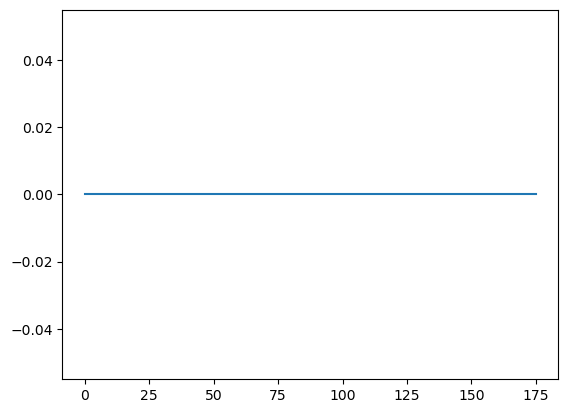

In [67]:
plt.plot((foreground_run_set[3][0]-varied_regolith_training_set[1])/varied_regolith_training_set[0]*100)

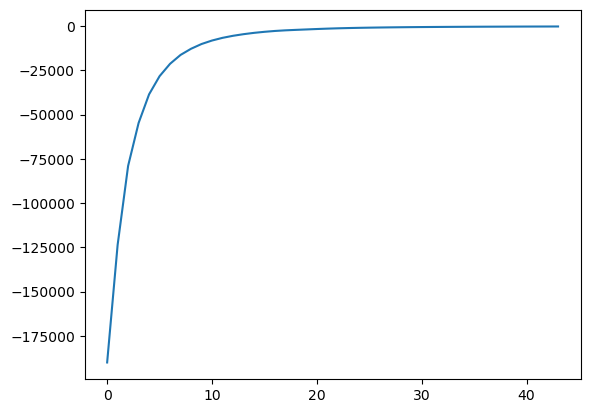

In [79]:
plt.plot(varied_regolith_training_set_raw[1][0][6:]-simulation_test_beam_1[0][2::4])

In [80]:
frequencies

array([ 6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22,
       23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39,
       40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50])

In [ ]:
varied